In [100]:
# modules/tools
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits import mplot3d

# methods
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut,LeavePOut
from sklearn.model_selection import KFold
import sklearn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV


# algorithms
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# performance metrics
from numpy import absolute
import statistics
from statistics import mean,stdev
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, \
explained_variance_score, confusion_matrix, accuracy_score, precision_score, recall_score
from scipy import stats
from scipy.stats.stats import pearsonr
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.metrics import mean_squared_error as mse


import warnings
warnings.filterwarnings('ignore')

### 1.DATASETS

### 1.1. Participant data

In [31]:
# reading data
df = pd.read_excel('Creativity_data.xlsx')

In [32]:
# checking missing values
df = df.fillna(0)

# collecting responses in a list
df_response = df.drop(['ID','Age','Gender','Intelligence_score','Creativity_score','Category'], axis=1)
df_clean = df[['Age','Gender','Intelligence_score','Creativity_score']]
df_clean['Responses'] = df_response.values.tolist()

In [33]:
### functions

# converting to string
def convert_type(x):
    
    new = []
    for word in x:
        w = str(word)
        new.append(w)
        
    return new

# removing nan values in a fluency list
def remove_nan(x):
    
    new = []
    for word in x:
        if word != 0:
            new.append(f'{str(word)}')
        
    return new
        
# get type of a value  
def return_type(x):
    
    return type(x)



In [34]:
# cleaning participant data
df_clean['Responses'] = df_clean['Responses'].apply(lambda x: remove_nan(x))
df_clean['Creativity_score'] = df_clean['Creativity_score'].apply(lambda x: round(x,1))
pd.set_option('display.max_colwidth', None)
df_clean

Age  Gender  Intelligence_score  Creativity_score  \
0     18       1              14.573               0.8   
1     20       1              16.603               0.5   
2     18       1               8.975               0.8   
3     18       1              16.902               0.8   
4     18       1              16.768               0.9   
..   ...     ...                 ...               ...   
177   19       1              19.582               1.5   
178   18       1              22.148               1.2   
179   18       1              19.541               1.6   
180   18       1              20.568               1.1   
181   18       0              22.692               1.2   

                                                                                                                                                                                                 Responses  
0                                                                                                  [dog, cat, bird, giraffe, monkey, zebra, hedgehog, donkey, elephant, tiger, bear, snake, lizard, hippo]  
1                                                                                [cat, dog, horse, sea lion, turtle, frog, tiger, bear, bird, camel, giraffe, scorpion, monkey, elephant, kangaroo, koala]  
2                                                                                                   [zebra, lion, tiger, bear, goose, duck, bird, squirrel, frog, mouse, raccoon, rabbit, dog, cat, snake]  
3                                                            [cheetah, lion, bear, rat, giraffe, snake, beaver, zebra, octopus, whale, dolphin, starfish, crab, lobster, snail, pig, goat, lamb, bat, cat]  
4                                                                                 [giraffe, lion, dog, cat, zebra, elephant, cougar, tiger, panda, monkey, koala, gorilla, bird, kangaroo, buffalo, horse]  
..                                                                                                                                                                                                     ...  
177                            [llama, alpaca, dog, hedgehog, porcupine, cat, fish, dolphin, whale, cow, camel, skunk, octopus, dinosaur, snake, panda, bear, polar bear, parrot, bird, spider, butterfly]  
178  [dog, cat, fish, giraffe, elephant, bear, donkey, gorilla, monkey, duck, chicken, cow, goose, pig, horse, rabbit, hare, tortoise, turtle, frog, cricket, spider, snake, kangaroo, koala, sheep, goat]  
179                                                                                                    [dog, cat, mouse, hamster, bird, tiger, goose, duck, monkey, giraffe, dinosaur, turtle, fish, lion]  
180         [ant, armadillo, cat, dog, mouse, horse, cow, bird, zebra, elephant, tier, lion, bear, squirrel, frog, lizard, pig, donkey, goat, lamb, sheep, rat, mongoose, moose, deer, rabbit, salamander]  
181                                                                               [cat, dog, elephant, mouse, bird, eagle, owl, donkey, human, whale, dolphin, fish, lion, zebra, monkey, snake, anteater]  

[182 rows x 5 columns]

### 1.2. Multiplex Network

In [35]:
# layers

free_associations = pd.read_csv('MultiplexLayers/FreeAssociationsM1.txt', sep='\t', header=None, names=['word1', 'word2'])
hyponyms = pd.read_csv('MultiplexLayers/HypernymsHyponymsM1.txt', sep='\t', header=None, names=['word1', 'word2'])
phonological =  pd.read_csv('MultiplexLayers/PhonologicalSimilaritiesM1.txt', sep='\t', header=None, names=['word1', 'word2'])
synonyms = pd.read_csv('MultiplexLayers/SynonymsM1.txt', sep='\t', header=None, names=['word1', 'word2'])


In [36]:
# node list for free associations

nodelist_free = free_associations['word1']
nodelist_free = pd.concat([nodelist_free, free_associations['word2']])
nodelist_free = nodelist_free.drop_duplicates()

In [37]:
# node list for hyponyms

nodelist_hypo = hyponyms['word1']
nodelist_hypo = pd.concat([nodelist_hypo, hyponyms['word2']])
nodelist_hypo = nodelist_hypo.drop_duplicates()

In [38]:
# node list for phonological

nodelist_pho = phonological['word1']
nodelist_pho = pd.concat([nodelist_pho, phonological['word2']])
nodelist_pho = nodelist_pho.drop_duplicates()

In [39]:
# node list for synonyms

nodelist_syn = synonyms['word1']
nodelist_syn = pd.concat([nodelist_syn, synonyms['word2']])
nodelist_syn = nodelist_syn.drop_duplicates()

In [40]:
# free associations graph

G_fa = nx.from_pandas_edgelist(free_associations,
                           source='word1',
                           target='word2')

print("No of unique characters:", len(G_fa.nodes))
print("No of connections:", len(G_fa.edges))

No of unique characters: 11525
No of connections: 36383


In [41]:
# hyponyms graph

G_h = nx.from_pandas_edgelist(hyponyms,
                           source='word1',
                           target='word2')

print("No of unique characters:", len(G_h.nodes))
print("No of connections:", len(G_h.edges))

No of unique characters: 10786
No of connections: 52003


In [42]:
# phonological Similarities graph

G_p = nx.from_pandas_edgelist(phonological,
                           source='word1',
                           target='word2')

print("No of unique characters:", len(G_p.nodes))
print("No of connections:", len(G_p.edges))

No of unique characters: 11049
No of connections: 35803


In [43]:
# synonyms graph

G_s = nx.from_pandas_edgelist(synonyms,
                           source='word1',
                           target='word2')

print("No of unique characters:", len(G_s.nodes))
print("No of connections:", len(G_s.edges))

No of unique characters: 9699
No of connections: 18890


In [44]:
# multiplex network
Un= nx.compose_all([G_fa,G_h,G_p,G_s])
print("No of unique characters:", len(Un.nodes))
print("No of connections:", len(Un.edges))

No of unique characters: 15886
No of connections: 134129


#### LVC

The LVC will be the largest viable cluster of "nodes connected by paths made only of colour" and this condition needs to hold for all colours/layers. A way to compute is iteratively:
* 1: Check the intersection M = {node_1, node_2, ... node_N} of nodes being present in all largest connected components across all four layers;
* 2: Create subgraphs for each layer induced by M;
* 3: Again check the intersection of largest connected components in the above subgraphs. Iterate 2 and 3 until convergence to a final list of nodes: the LVC.

In [45]:
### functions

# create subgraphs
def sub_graphs(glist,m):
    
    subg = []
    for g in glist:
        H = g.subgraph(m)
        subg.append(H)
    
    return subg
    
# largest connected components
def lcc(graphs):
    
    lcc = []
    for l in graphs:
        lcc_ = max(nx.connected_components(l), key=len)
        lcc.append(lcc_)
        
    return lcc

# take intersection
def intersection(lcc_list):
    
    M = set.intersection(lcc_list[0],lcc_list[1],lcc_list[2],lcc_list[3])
    
    return M
    
# create LVC    
def lvc(graphs,m1):
    
    subgraphs = sub_graphs(graphs,m1)
    
    return intersection(lcc(subgraphs))
   

In [46]:
# STEP 1

lcc_f = max(nx.connected_components(G_fa), key=len)
lcc_h = max(nx.connected_components(G_h), key=len)
lcc_s = max(nx.connected_components(G_s), key=len)
lcc_p = max(nx.connected_components(G_p), key=len)

M = set.intersection(lcc_f,lcc_h,lcc_s,lcc_p)
print(len(M))

2712


In [47]:
# STEP 2 & 3 

result = True

graphs = [G_fa,G_h,G_s,G_p]
M
m1 = lvc(graphs,M)

i = 0
while result:

    if m1 != M:
    
        M = lvc(graphs,m1)
        m1 = lvc(graphs, M)
        i += 1
    else:
        result = False
        
LVC = m1        
print(len(LVC))
        
        

1030


###  2. DATA CLEANING AND PROCESSING

##### FLUENCY LIST FEATURES

- Number of responses
- Number of repeated responses
- Average word length in the fluency list

In [48]:
### functions

# the number of responses
def count_response(x):
    
    return len(x)

# average word length
def avg_length(x):
    
    sum_ = 0
    count = 0
    for word in x:
        sum_ += len(word)
        count += 1
        
    return round(sum_ / count)

# the number of repeated responses
def repeated(x):
    
    freq = {}
    for word in x:
        if word not in freq.keys():
            freq[word] = 1
        else:
            freq[word] += 1
            
    count = 0
    for value in freq.values():
        if value > 1:
            count += value
        
    return count

In [49]:
# add features to dataset 
df_clean['Number_of_response'] = df_clean['Responses'].apply(lambda x: count_response(x))
df_clean['Avg_word_length'] = df_clean['Responses'].apply(lambda x: avg_length(x))
df_clean['Repeated_word'] = df_clean['Responses'].apply(lambda x: repeated(x))

##### NETWORK METRICS

- Fraction of responses in LVC : 'Fraction_in_lvc'
- Jaccard Similarity between fluency list and each layer (J(FL-L1), J(FL-L2), J(FL-L3), J(FL-L4)) : 'Jaccard_L1'..
- Global average of degree of the nodes in the fluency list, using multiplex network as a whole : 'Degree_centrality'
- LVC Coverage per response: 'lvc_coverage'
- Average number of visited nodes in the multiplex shortest path between a response and “animal”: 'coverage_animal'
- Fraction of word-word links in flueny list in layers: 'links_in_L1'..

In [50]:
### functions 

# fraction of responses being part of LVC
def fraction_in_lvc(x, lvc):
    
    count = 0
    for word in x:
        if str(word) in lvc:
            count += 1
            
    return round(count/len(x),3)


# jaccard similarity between fluency list and layer nodes
def jaccard_set(list1, list2):
    
    """Define Jaccard Similarity function for two sets"""
    intersect = set(list1).intersection(set(list2))
    union = set(list1).union(set(list2))
    return len(intersect) / len(union)


# median degree centrality for a fluency list
def degree_centrality(list1):
    
    n = nx.degree_centrality(Un)
    
    cent = []
    for word in list1:
        if word in n.keys():
            cent.append(n[word])
        else:
            cent.append(0)
    
    return statistics.median(cent)


# LVC coverage per response
def lvc_coverage(list1, lvc, G):
    
    m = len(list1)
    
    mean = 0
    for i in range(m-1):
        s=list1[i]
        t=list1[i+1]
        if s in G and t in G:
            shortest = nx.shortest_path(G, source=s, target=t)
            count = 0
            for word in shortest:
                if word in lvc:
                    count += 1 
            mean += count/m
        
    return mean
 
# coverage from “animal” per response
def coverage_animal(list1,G):
    
    m = len(list1)
    
    mean = 0
    for i in range(m-1):
        s=list1[i]
        t='animal'
        if s in G and t in G:
            shortest = nx.shortest_path(G, source=s, target=t)
            count = len(shortest)
            mean += count/m
        
    return mean

# links_in_L1, links_in_L2 ..
def link_in_layer(list1,layer):
    
    l = len(list1)
    
    count = 0
    for i in range(l-1):
        w1 = list1[i]
        w2 = list1[i+1]
        
        edge = (w1,w2)
        
        if edge in layer.edges:
            count += 1
            
    return count/(l-1)


In [51]:
# add networks features to dataset

df_clean['Fraction_in_lvc'] = df_clean['Responses'].apply(lambda x: fraction_in_lvc(x,LVC))

df_clean['Jaccard_L1'] = df_clean['Responses'].apply(lambda x: jaccard_set(x, nodelist_free))
df_clean['Jaccard_L2'] = df_clean['Responses'].apply(lambda x: jaccard_set(x, nodelist_hypo))
df_clean['Jaccard_L3'] = df_clean['Responses'].apply(lambda x: jaccard_set(x, nodelist_pho))
df_clean['Jaccard_L4'] = df_clean['Responses'].apply(lambda x: jaccard_set(x, nodelist_syn))

df_clean['Degree_centrality'] = df_clean['Responses'].apply(lambda x: degree_centrality(x))

df_clean['Coverage_lvc'] = df_clean['Responses'].apply(lambda x: lvc_coverage(x, LVC, Un))

df_clean['Coverage_animal'] = df_clean['Responses'].apply(lambda x: coverage_animal(x, Un))

df_clean['Links_in_L1'] = df_clean['Responses'].apply(lambda x: link_in_layer(x, G_fa))
df_clean['Links_in_L2'] = df_clean['Responses'].apply(lambda x: link_in_layer(x, G_h))
df_clean['Links_in_L3'] = df_clean['Responses'].apply(lambda x: link_in_layer(x, G_p))
df_clean['Links_in_L4'] = df_clean['Responses'].apply(lambda x: link_in_layer(x, G_s))

In [52]:
# see final dataset
df_clean.head(5)

Age  Gender  Intelligence_score  Creativity_score  \
0   18       1              14.573               0.8   
1   20       1              16.603               0.5   
2   18       1               8.975               0.8   
3   18       1              16.902               0.8   
4   18       1              16.768               0.9   

                                                                                                                                       Responses  \
0                                        [dog, cat, bird, giraffe, monkey, zebra, hedgehog, donkey, elephant, tiger, bear, snake, lizard, hippo]   
1                      [cat, dog, horse, sea lion, turtle, frog, tiger, bear, bird, camel, giraffe, scorpion, monkey, elephant, kangaroo, koala]   
2                                         [zebra, lion, tiger, bear, goose, duck, bird, squirrel, frog, mouse, raccoon, rabbit, dog, cat, snake]   
3  [cheetah, lion, bear, rat, giraffe, snake, beaver, zebra, octopus, whale, dolphin, starfish, crab, lobster, snail, pig, goat, lamb, bat, cat]   
4                       [giraffe, lion, dog, cat, zebra, elephant, cougar, tiger, panda, monkey, koala, gorilla, bird, kangaroo, buffalo, horse]   

   Number_of_response  Avg_word_length  Repeated_word  Fraction_in_lvc  \
0                  14                5              0            0.286   
1                  16                6              0            0.312   
2                  15                5              0            0.333   
3                  20                5              0            0.300   
4                  16                6              0            0.250   

   Jaccard_L1  Jaccard_L2  Jaccard_L3  Jaccard_L4  Degree_centrality  \
0    0.001215    0.001020    0.000995    0.000824           0.001102   
1    0.001301    0.001298    0.001086    0.000721           0.001070   
2    0.001302    0.001298    0.000995    0.001031           0.002203   
3    0.001735    0.001576    0.001357    0.001133           0.001920   
4    0.001388    0.001019    0.000995    0.000618           0.000787   

   Coverage_lvc  Coverage_animal  Links_in_L1  Links_in_L2  Links_in_L3  \
0      0.857143         2.500000     0.076923          0.0     0.000000   
1      0.812500         2.375000     0.066667          0.0     0.000000   
2      1.266667         2.533333     0.285714          0.0     0.000000   
3      0.950000         2.950000     0.105263          0.0     0.052632   
4      1.125000         2.500000     0.066667          0.0     0.000000   

   Links_in_L4  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

## Exploration

In [53]:
# check for possible null values
df_clean.isnull().sum()

Age                   0
Gender                0
Intelligence_score    0
Creativity_score      0
Responses             0
Number_of_response    0
Avg_word_length       0
Repeated_word         0
Fraction_in_lvc       0
Jaccard_L1            0
Jaccard_L2            0
Jaccard_L3            0
Jaccard_L4            0
Degree_centrality     0
Coverage_lvc          0
Coverage_animal       0
Links_in_L1           0
Links_in_L2           0
Links_in_L3           0
Links_in_L4           0
dtype: int64

#### Univariate Analysis

In [54]:
# create a data without the fluency list 
data = df_clean.drop(['Responses'],axis=1)

(array([0, 1]), [Text(0, 0, 'Male'), Text(0, 1, 'Female')])

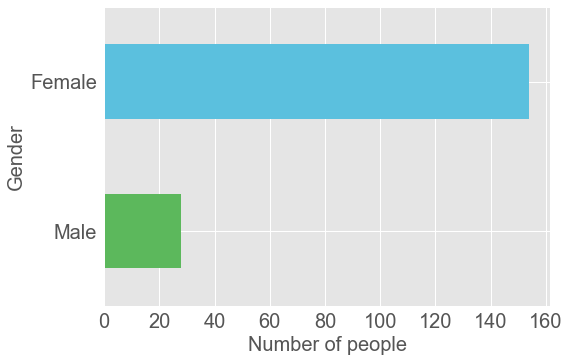

In [107]:
# gender ratio
test_data = pd.DataFrame()
test_data['Gender'] = data['Gender']

test_data[test_data['Gender'] == 0] = 'Male'
test_data[test_data['Gender'] == 1] = 'Female'

test_data['Gender'].value_counts().sort_values().plot(kind = 'barh', color=['#5cb85c','#5bc0de'])
plt.xlabel("Number of people", fontdict={'fontsize': 20})
plt.ylabel("Gender",fontdict={'fontsize': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [55]:
# descriptive table 1
data[['Creativity_score', 'Age','Intelligence_score', 'Number_of_response','Avg_word_length','Repeated_word']].describe()

Creativity_score         Age  Intelligence_score  Number_of_response  \
count        182.000000  182.000000          182.000000          182.000000   
mean           0.922527   19.000000           19.602104           18.021978   
std            0.448310    2.650967            4.769932            4.057537   
min            0.000000   18.000000            8.285000            9.000000   
25%            0.600000   18.000000           16.393250           15.000000   
50%            1.000000   18.000000           19.226000           18.000000   
75%            1.200000   19.000000           22.545000           21.000000   
max            2.100000   45.000000           31.380000           28.000000   

       Avg_word_length  Repeated_word  
count       182.000000     182.000000  
mean          5.175824       0.269231  
std           0.567896       0.866209  
min           4.000000       0.000000  
25%           5.000000       0.000000  
50%           5.000000       0.000000  
75%           5.000000       0.000000  
max           8.000000       6.000000

In [179]:
# descriptive table 2
data[['Jaccard_L1', 'Jaccard_L2', 'Jaccard_L3', 'Jaccard_L4', 'Links_in_L1',
       'Links_in_L2', 'Links_in_L3', 'Links_in_L4']].describe()

Jaccard_L1  Jaccard_L2  Jaccard_L3  Jaccard_L4  Links_in_L1  \
count     182.000     182.000     182.000     182.000      182.000   
mean        0.001       0.001       0.001       0.001        0.155   
std         0.000       0.000       0.000       0.000        0.074   
min         0.001       0.001       0.000       0.000        0.000   
25%         0.001       0.001       0.001       0.001        0.100   
50%         0.001       0.001       0.001       0.001        0.143   
75%         0.002       0.002       0.001       0.001        0.206   
max         0.002       0.002       0.002       0.002        0.429   

       Links_in_L2  Links_in_L3  Links_in_L4  
count      182.000      182.000      182.000  
mean         0.020        0.003        0.003  
std          0.034        0.014        0.012  
min          0.000        0.000        0.000  
25%          0.000        0.000        0.000  
50%          0.000        0.000        0.000  
75%          0.043        0.000        0.000  
max          0.143        0.111        0.083

In [180]:
# descriptive table 3
data[['Fraction_in_lvc','Degree_centrality', 'Coverage_lvc', 'Coverage_animal']].describe()

Fraction_in_lvc  Degree_centrality  Coverage_lvc  Coverage_animal
count          182.000            182.000       182.000          182.000
mean             0.274              0.002         0.942            2.647
std              0.084              0.001         0.245            0.223
min              0.095              0.001         0.316            2.091
25%              0.217              0.001         0.767            2.500
50%              0.271              0.002         0.933            2.667
75%              0.333              0.002         1.110            2.800
max              0.538              0.005         1.692            3.261

Skewness: 6.273512
Kurtosis: 53.117873


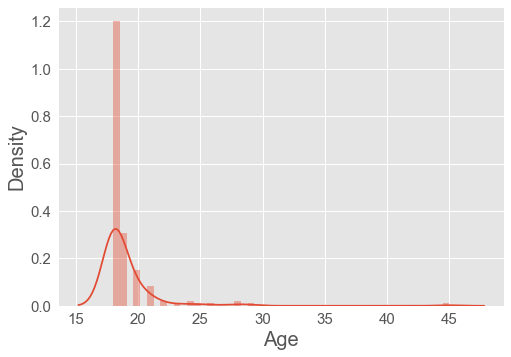

Skewness: -1.934789
Kurtosis: 1.762659


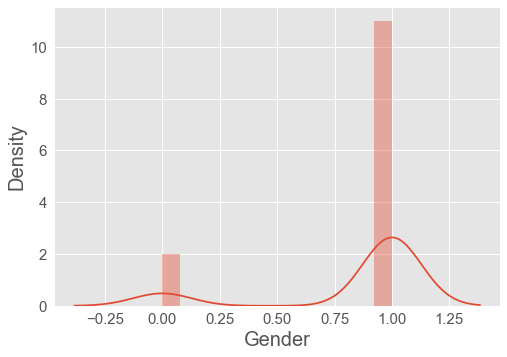

Skewness: 0.216003
Kurtosis: -0.048206


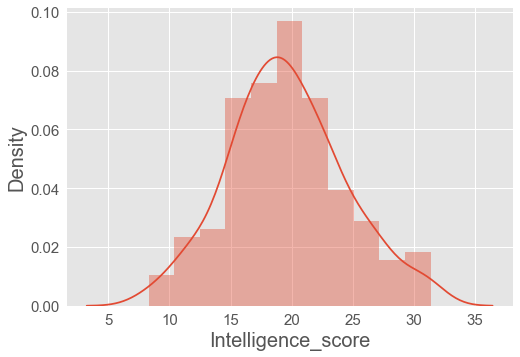

Skewness: -0.318525
Kurtosis: -0.417816


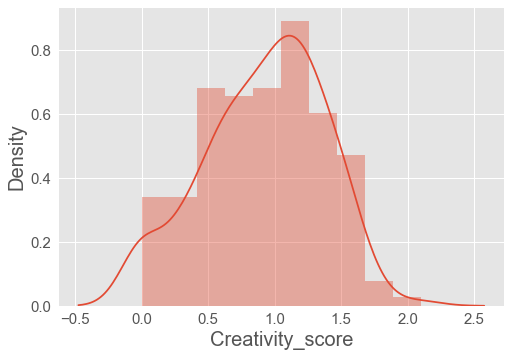

Skewness: 0.313551
Kurtosis: -0.635944


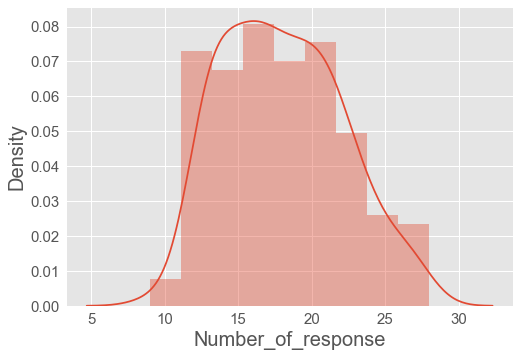

Skewness: 0.921746
Kurtosis: 3.305040


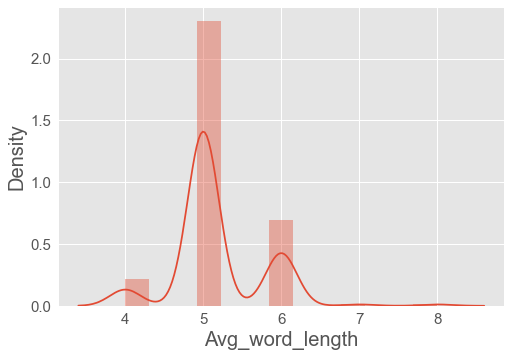

Skewness: 3.728194
Kurtosis: 15.634170


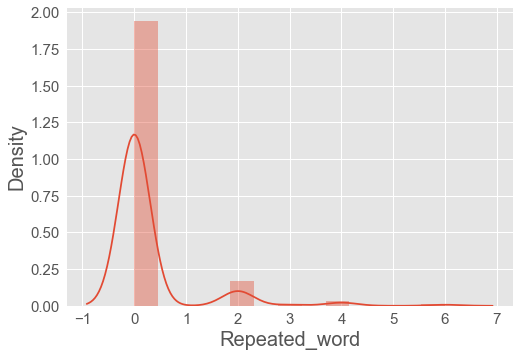

Skewness: 0.416217
Kurtosis: 0.507517


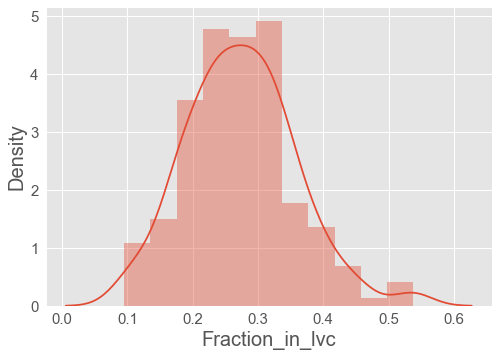

Skewness: 0.267835
Kurtosis: -0.250117


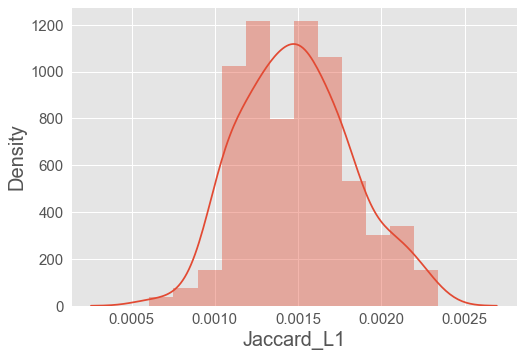

Skewness: 0.441179
Kurtosis: -0.021817


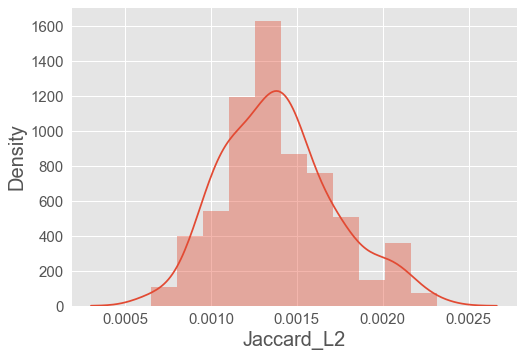

Skewness: 0.169117
Kurtosis: -0.223085


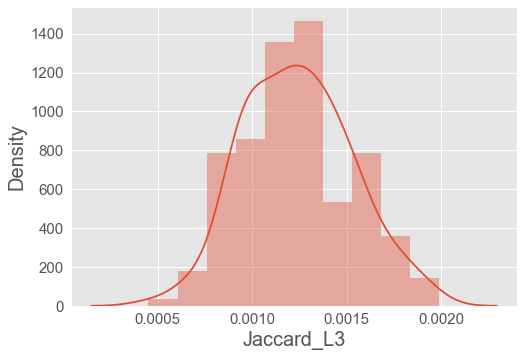

Skewness: 0.259189
Kurtosis: -0.466465


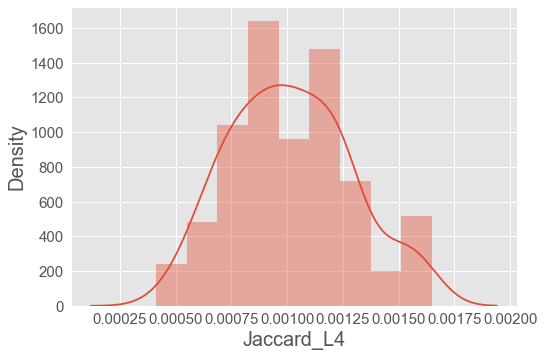

Skewness: 0.566045
Kurtosis: 0.649593


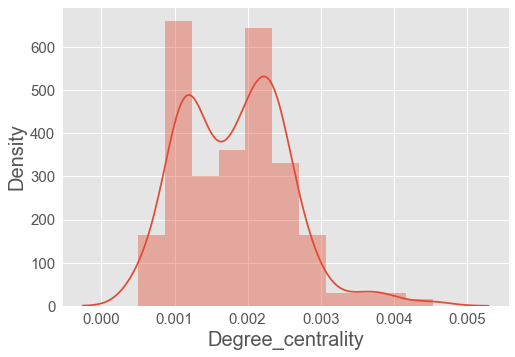

Skewness: 0.174526
Kurtosis: 0.331079


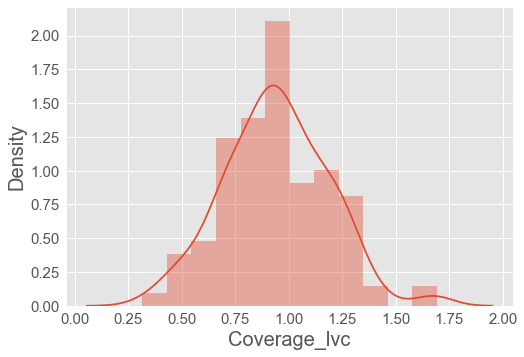

Skewness: 0.063727
Kurtosis: -0.381031


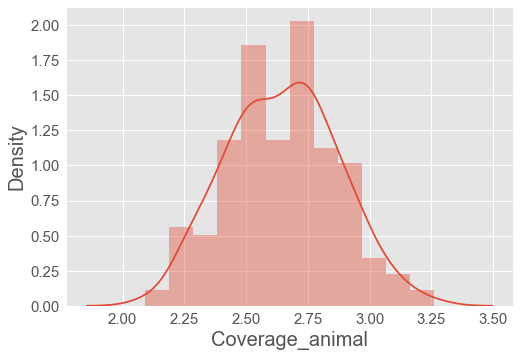

Skewness: 0.723820
Kurtosis: 0.830256


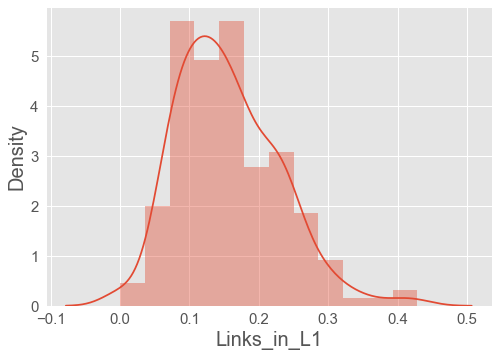

Skewness: 1.536181
Kurtosis: 1.469842


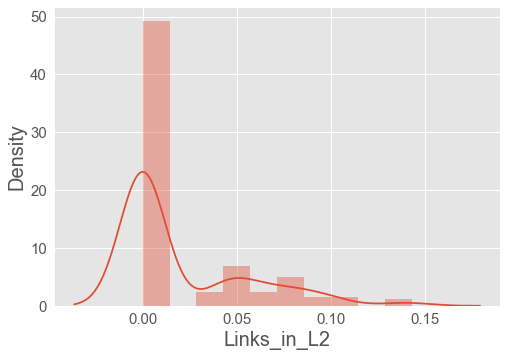

Skewness: 5.164496
Kurtosis: 28.674149


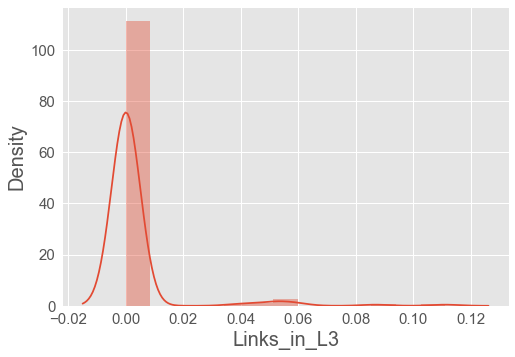

Skewness: 3.853646
Kurtosis: 15.133677


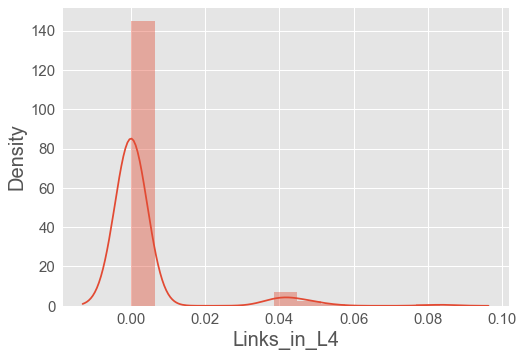

In [144]:
# distribution plots for each feature
for column in data:
    
    print("Skewness: %f" % data[column].skew())
    print("Kurtosis: %f" % data[column].kurt())
     
    b =sns.distplot(data[column]) #hist_kws=dict(color='plum', edgecolor="k", linewidth=1)
    b.set_xlabel("{}".format(column),fontsize=20)
    b.set_ylabel("Density",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()



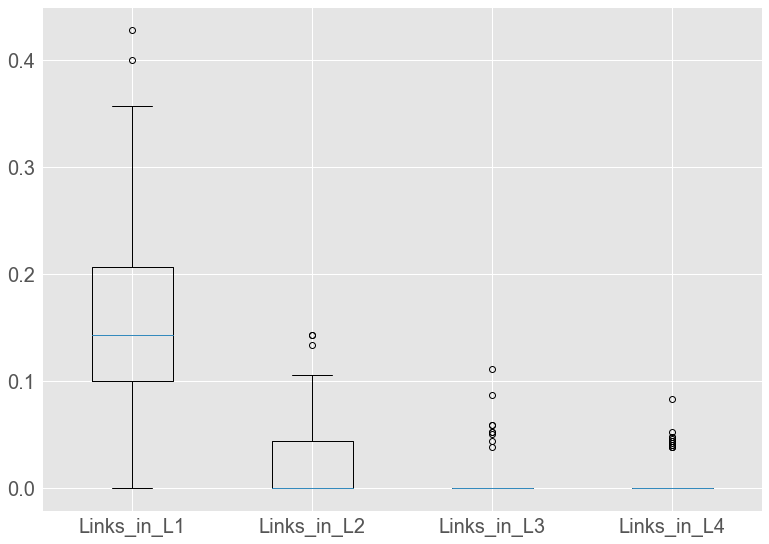

In [143]:
# box plots for feaures:
cols = ['Links_in_L1','Links_in_L2', 'Links_in_L3', 'Links_in_L4']

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data[cols])

ax.set_xticklabels(['Links_in_L1','Links_in_L2', 'Links_in_L3', 'Links_in_L4'],fontsize=20)
ax.tick_params(axis='y', labelsize=20) 
# show plot
plt.show()

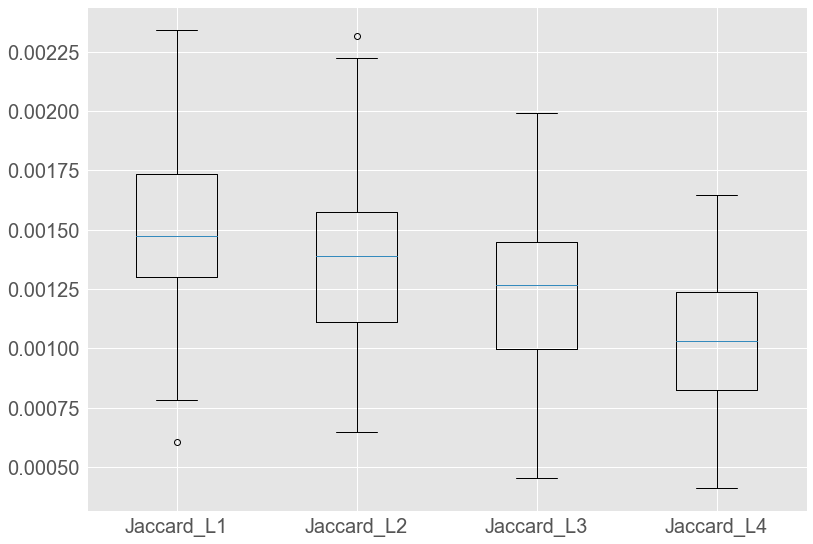

In [146]:
cols = ['Jaccard_L1', 'Jaccard_L2', 'Jaccard_L3', 'Jaccard_L4']

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data[cols])

ax.set_xticklabels(cols,fontsize=20)
ax.tick_params(axis='y', labelsize=20) 
# show plot
plt.show()

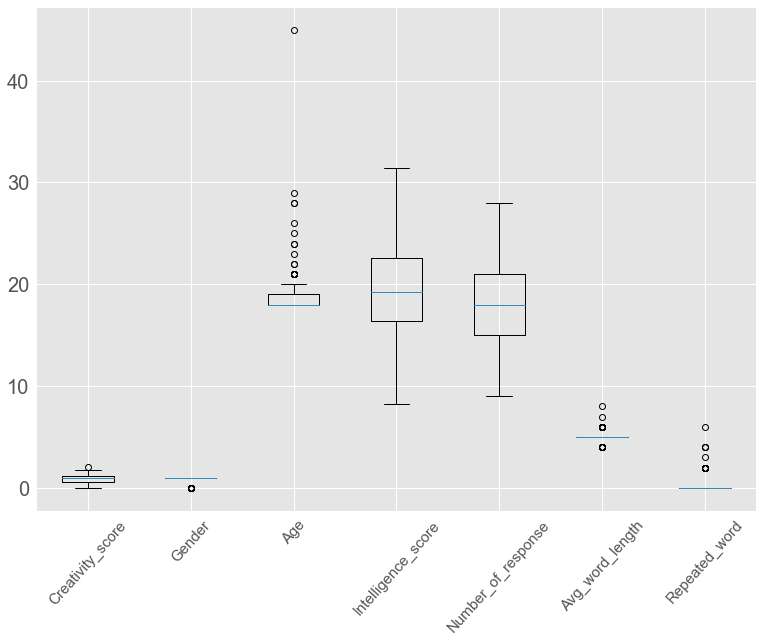

In [151]:
cols = ['Creativity_score', 'Gender','Age','Intelligence_score', 'Number_of_response','Avg_word_length','Repeated_word']

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data[cols])

ax.set_xticklabels(cols,fontsize=15)
ax.tick_params(axis='y', labelsize=20) 
ax.tick_params(axis='x', rotation=48) 
# show plot
plt.show()

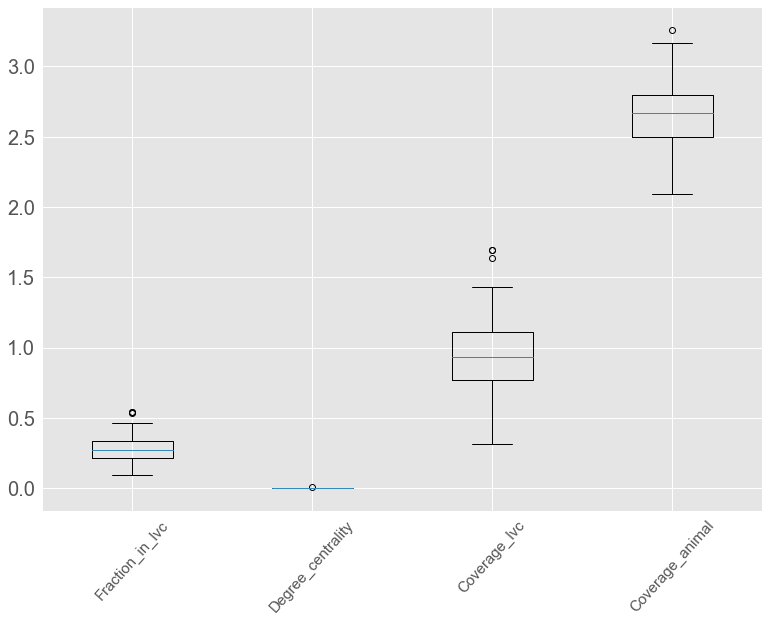

In [152]:
cols = ['Fraction_in_lvc','Degree_centrality', 'Coverage_lvc', 'Coverage_animal']

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data[cols])

ax.set_xticklabels(cols,fontsize=15)
ax.tick_params(axis='y', labelsize=20) 
ax.tick_params(axis='x', rotation=48) 
# show plot
plt.show()

#### Bivariate and Multivariate Analysis

In [181]:
# correlation between dependent variable and features
df_corr = data.corr()['Creativity_score'].abs().sort_values(ascending=False)
df_corr

Creativity_score     1.000
Links_in_L3          0.159
Links_in_L1          0.118
Jaccard_L1           0.092
Links_in_L4          0.079
Number_of_response   0.078
Repeated_word        0.077
Fraction_in_lvc      0.075
Jaccard_L2           0.073
Intelligence_score   0.067
Coverage_lvc         0.053
Coverage_animal      0.050
Links_in_L2          0.048
Jaccard_L3           0.044
Avg_word_length      0.041
Age                  0.040
Degree_centrality    0.026
Gender               0.021
Jaccard_L4           0.004
Name: Creativity_score, dtype: float64

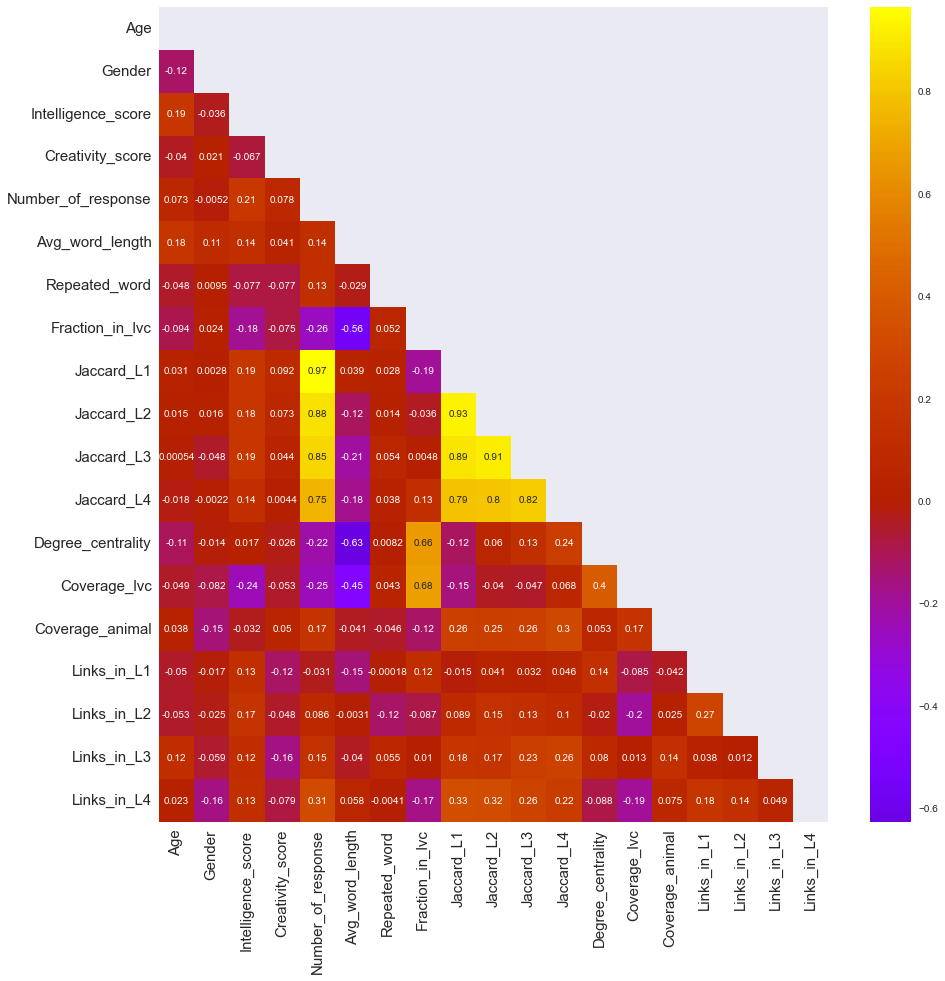

In [170]:
# correlations with a heatmap

# save correlations to variable
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# generate heatmap
plt.figure(figsize= (15,15))
sns.heatmap(corr, annot=True, center=0, mask=mask, cmap='gnuplot')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175.]),
 [Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, '')])

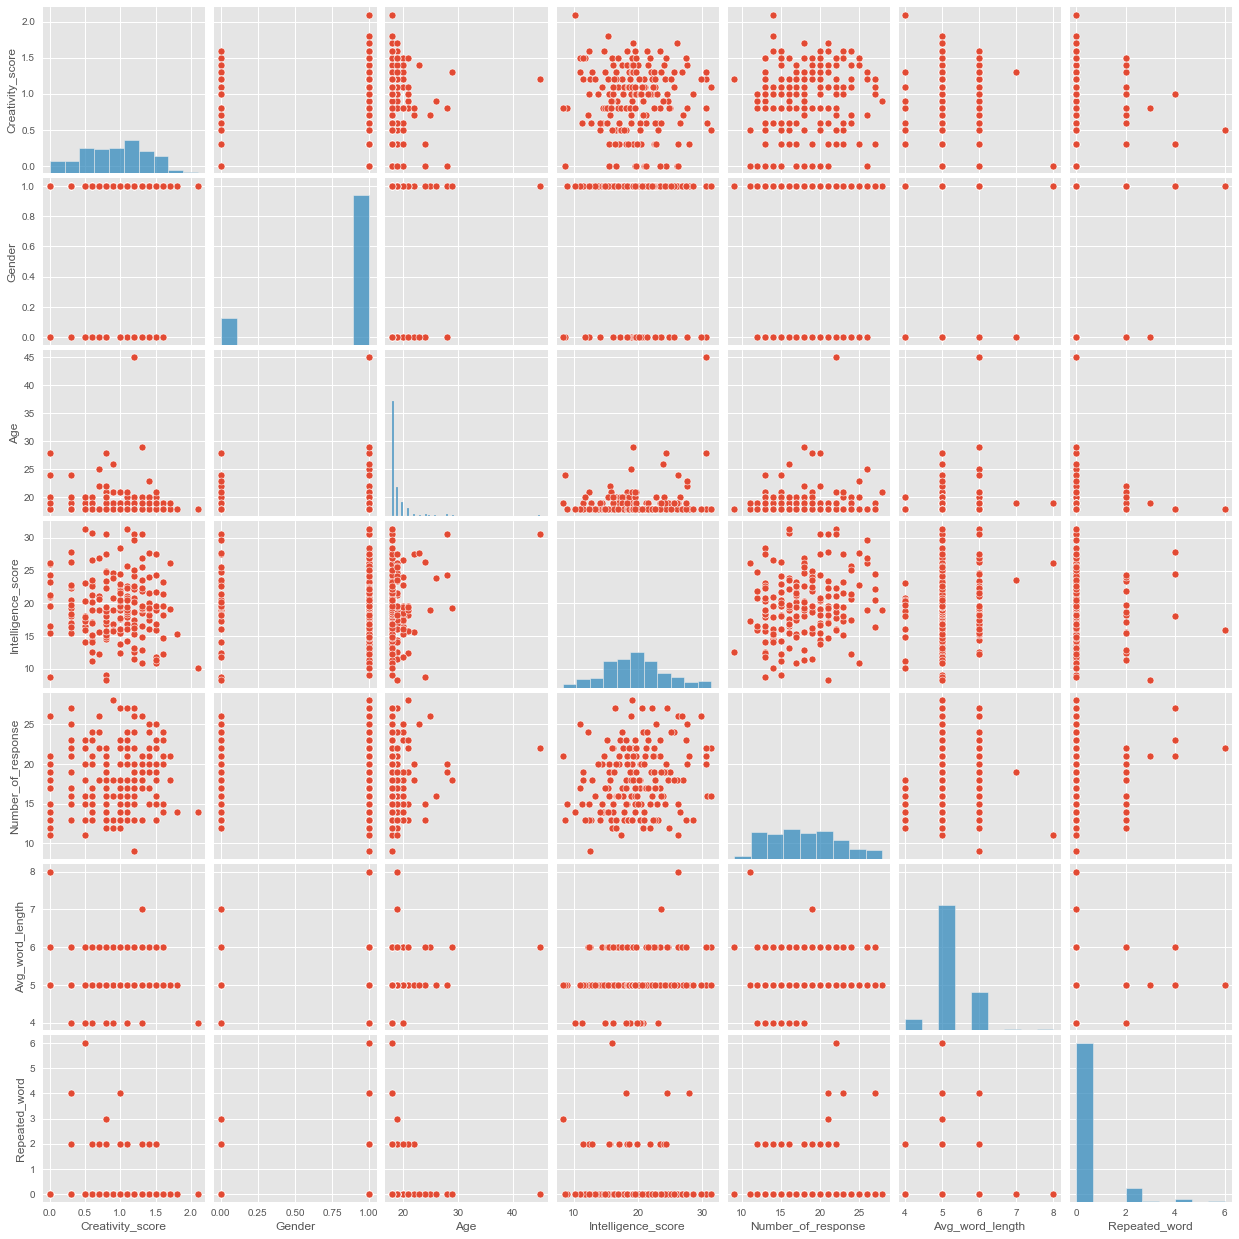

In [155]:
# pair plots for variables
cols = ['Creativity_score', 'Gender','Age','Intelligence_score', 'Number_of_response','Avg_word_length','Repeated_word']

sns.pairplot(data[cols])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([ 0., 10., 20., 30., 40., 50.]),
 [Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, '')])

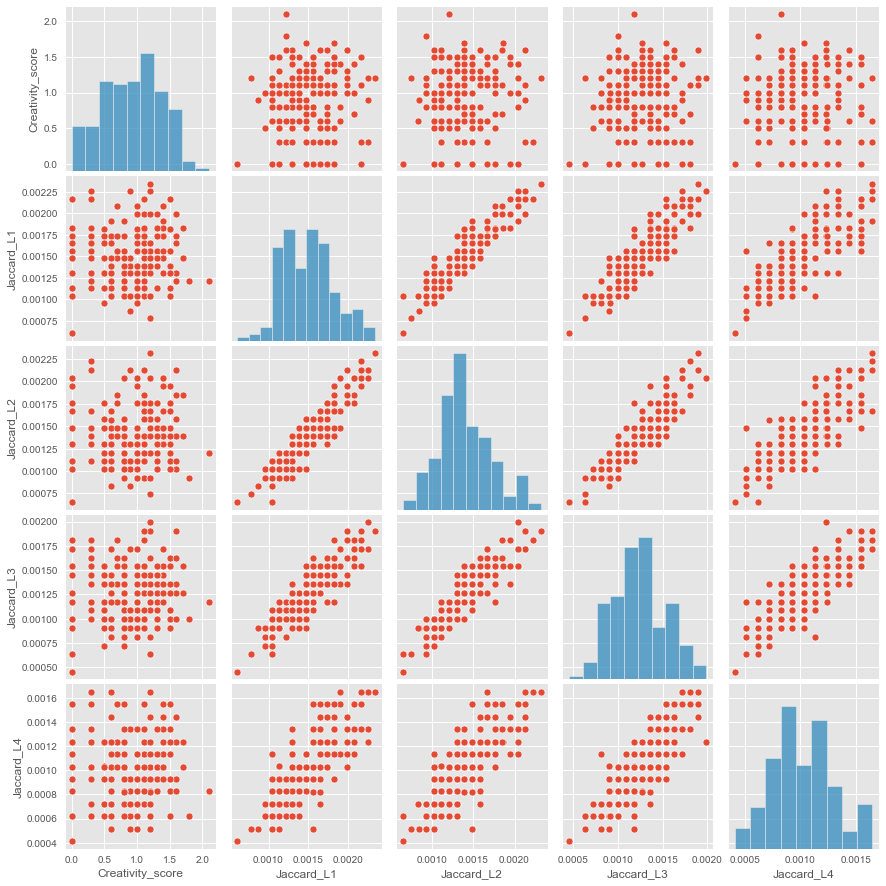

In [64]:
# pair plots for variables
cols2 = ['Creativity_score','Jaccard_L1', 'Jaccard_L2', 'Jaccard_L3', 'Jaccard_L4']

sns.pairplot(data[cols2])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

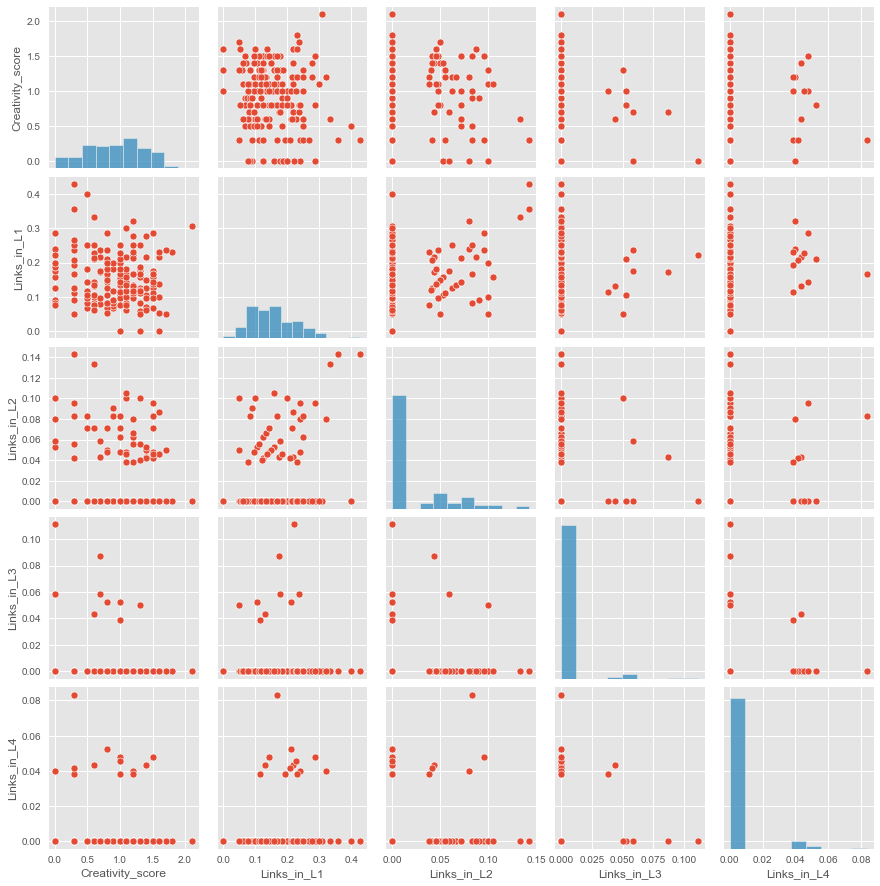

In [154]:
# pair plots for variables
cols3 = ['Creativity_score','Links_in_L1',
       'Links_in_L2', 'Links_in_L3', 'Links_in_L4']

g = sns.pairplot(data[cols3])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

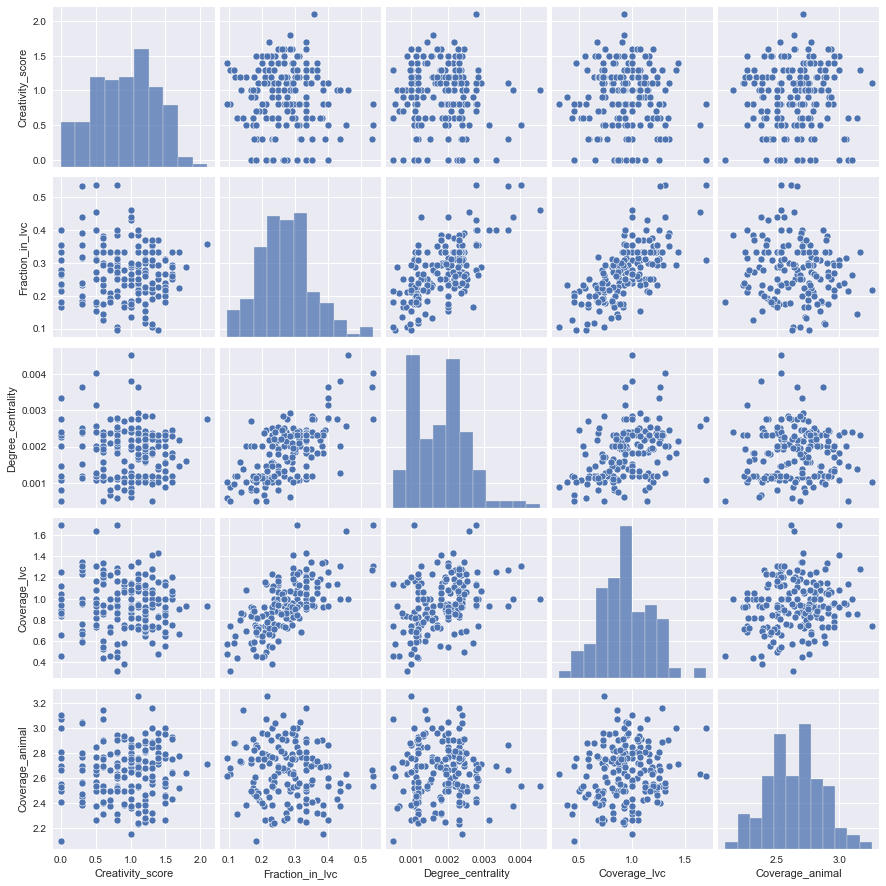

In [461]:
# pair plots for variables
cols4 = ['Creativity_score','Fraction_in_lvc','Degree_centrality', 'Coverage_lvc', 'Coverage_animal']

sns.pairplot(data[cols4])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

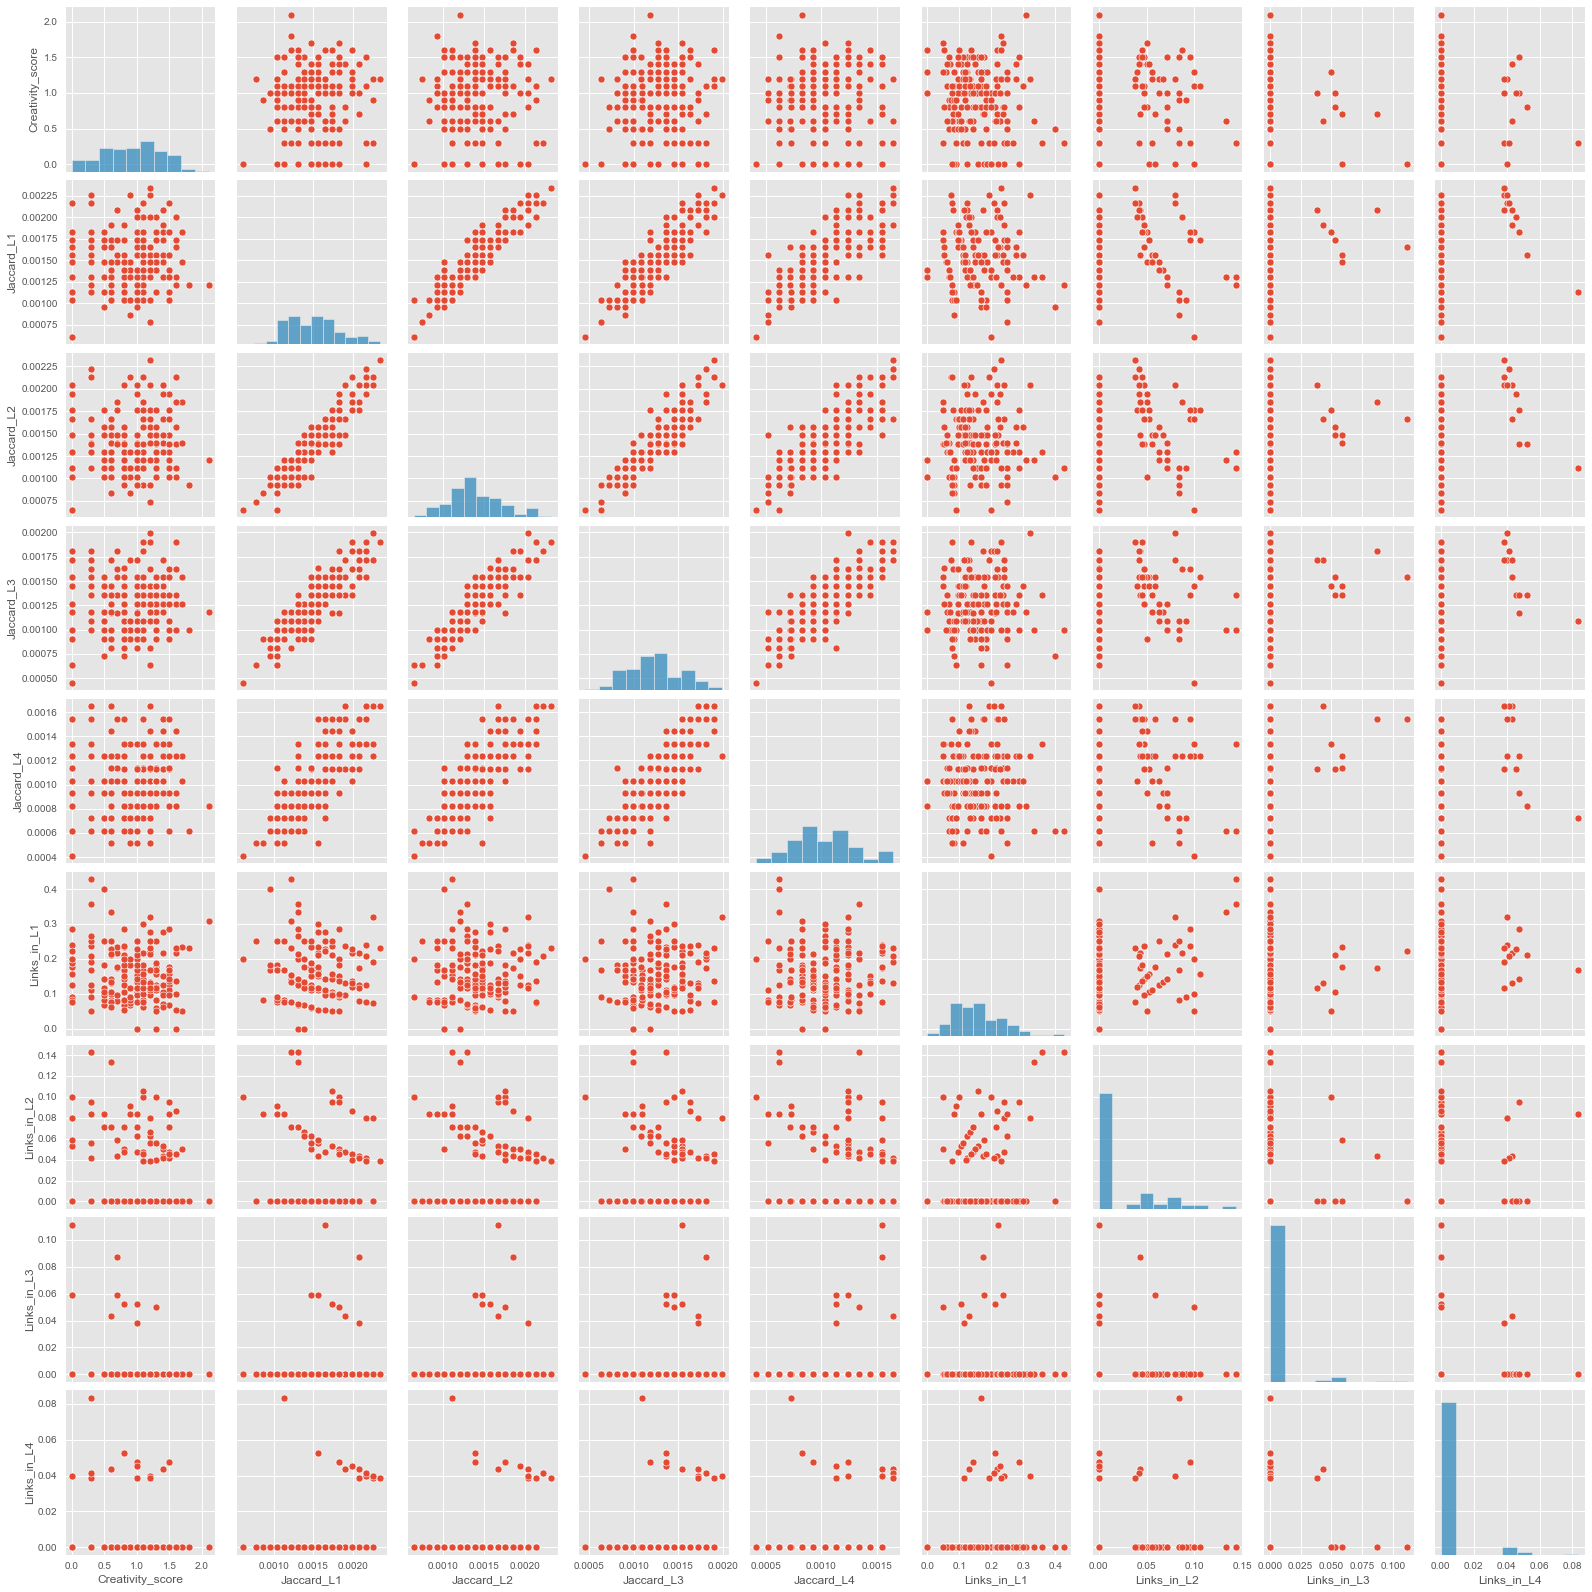

In [109]:
# pair plots for variables
cols5 = ['Creativity_score','Jaccard_L1', 'Jaccard_L2', 'Jaccard_L3', 'Jaccard_L4','Links_in_L1',
       'Links_in_L2', 'Links_in_L3', 'Links_in_L4']

#plt.figure(figsize= (20,20))
sns.pairplot(data[cols5])

In [184]:
### function for Variance Inflation Factor
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})


In [511]:
# calculate VIF
features = data.drop('Creativity_score',axis=1)
calculate_vif(data,features)

VIF  Tolerance
Age                 1.156      0.865
Gender              1.172      0.853
Intelligence_score  1.257      0.796
Number_of_response 33.990      0.029
Avg_word_length     2.315      0.432
Repeated_word       1.402      0.713
Fraction_in_lvc     3.801      0.263
Jaccard_L1         34.139      0.029
Jaccard_L2         11.344      0.088
Jaccard_L3          9.799      0.102
Jaccard_L4          4.639      0.216
Degree_centrality   3.274      0.305
Coverage_lvc        2.921      0.342
Coverage_animal     1.489      0.672
Links_in_L1         1.230      0.813
Links_in_L2         1.237      0.808
Links_in_L3         1.169      0.856
Links_in_L4         1.283      0.779

In [512]:
# calculate VIF after reducing the features with high VIF
features2 = data.drop(['Creativity_score', 'Number_of_response'],axis=1)
calculate_vif(data,features2)

VIF  Tolerance
Age                 1.119      0.894
Gender              1.145      0.874
Intelligence_score  1.255      0.797
Avg_word_length     2.217      0.451
Repeated_word       1.045      0.957
Fraction_in_lvc     3.747      0.267
Jaccard_L1         14.263      0.070
Jaccard_L2         11.298      0.089
Jaccard_L3          9.363      0.107
Jaccard_L4          4.400      0.227
Degree_centrality   2.820      0.355
Coverage_lvc        2.636      0.379
Coverage_animal     1.402      0.713
Links_in_L1         1.226      0.816
Links_in_L2         1.235      0.809
Links_in_L3         1.133      0.882
Links_in_L4         1.261      0.793

In [513]:
# calculate VIF after reducing the features with high VIF
features3 = data.drop(['Creativity_score', 'Number_of_response','Jaccard_L2','Jaccard_L3'],axis=1)
calculate_vif(data,features3)

VIF  Tolerance
Age                1.114      0.898
Gender             1.111      0.900
Intelligence_score 1.248      0.801
Avg_word_length    1.961      0.510
Repeated_word      1.034      0.967
Fraction_in_lvc    3.727      0.268
Jaccard_L1         4.142      0.241
Jaccard_L4         4.252      0.235
Degree_centrality  2.710      0.369
Coverage_lvc       2.529      0.395
Coverage_animal    1.399      0.715
Links_in_L1        1.218      0.821
Links_in_L2        1.179      0.848
Links_in_L3        1.115      0.897
Links_in_L4        1.237      0.808

Skewness: -0.318525
Kurtosis: -0.417816


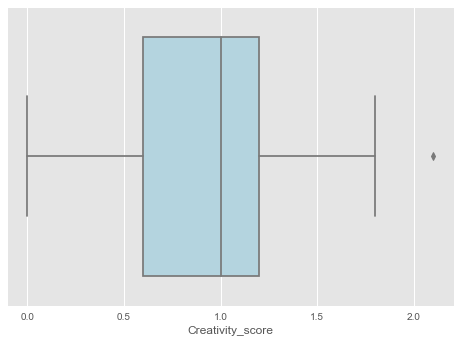

<AxesSubplot:xlabel='Creativity_score', ylabel='Density'>

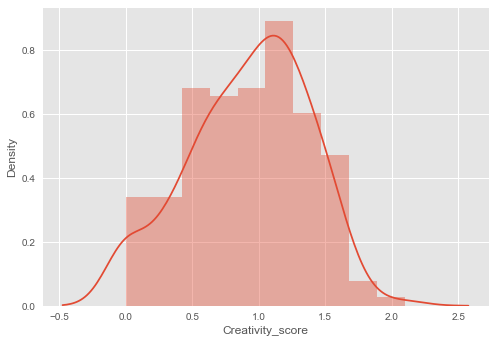

In [508]:
#response variable analysis, boxplot and distribution plot for Creativity Score

#skewness and kurtosis
print("Skewness: %f" % data['Creativity_score'].skew())
print("Kurtosis: %f" % data['Creativity_score'].kurt())

plt.style.use('ggplot')
sns.boxplot(data['Creativity_score'], color='lightblue')
plt.show()


sns.distplot(data['Creativity_score'])

#### Mediation and Suppression Analysis

In [19]:
def jaccard(A, B):
    
    """Define Jaccard Similarity function for two sets"""
    intersect = set(A.edges).intersection(set(B.edges))
    union = set(A.edges).union(set(B.edges))
    return len(intersect) / len(union)

def partial_jaccard(A,B,C):
    
    e1 = set(A.edges) - set(C.edges)
    e2 = set(B.edges) - set(C.edges)
 
    intersect = e1.intersection(e2)
    union = e1.union(e2)
    return len(intersect) / len(union)
    
    
def delta(A,B,C):
    
    
    J = jaccard(A,B)
    Jp = partial_jaccard(A,B,C)
    delta = Jp - J
    
    #if delta == 0:
    #   print("3. layer is independent of the relation between 1 and 2")
    #elif delta > 0:
    #    print("3. layer acts as a suppressor")
    #else: 
    #   print("3. layer mediates or confounds the relation between 1 and 2")

    return delta

  
def findTriplets(lst):
          
    return list(combinations(lst, 3))

def replace(x):
    
    return  x.replace("'","")

def convert(x):
    layer_name_str = ['G_fa.edges', 'G_h.edges', 'G_p.edges', 'G_s.edges']
    layer_name_org = [G_fa.edges, G_h.edges, G_p.edges, G_s.edges]
    

##### Node alignment

In [16]:
G_free = G_fa.copy()
G_hypo = G_h.copy()
G_phon = G_p.copy()
G_syn = G_s.copy()

In [17]:
nodes = list(Un.nodes)

def align(network):
    for i in nodes:
        if i not in network.nodes:
            network.add_node(i)
            
layers = [G_free,G_hypo,G_phon,G_syn]

for l in layers:
    align(l)

##### Jaccard Similarity 

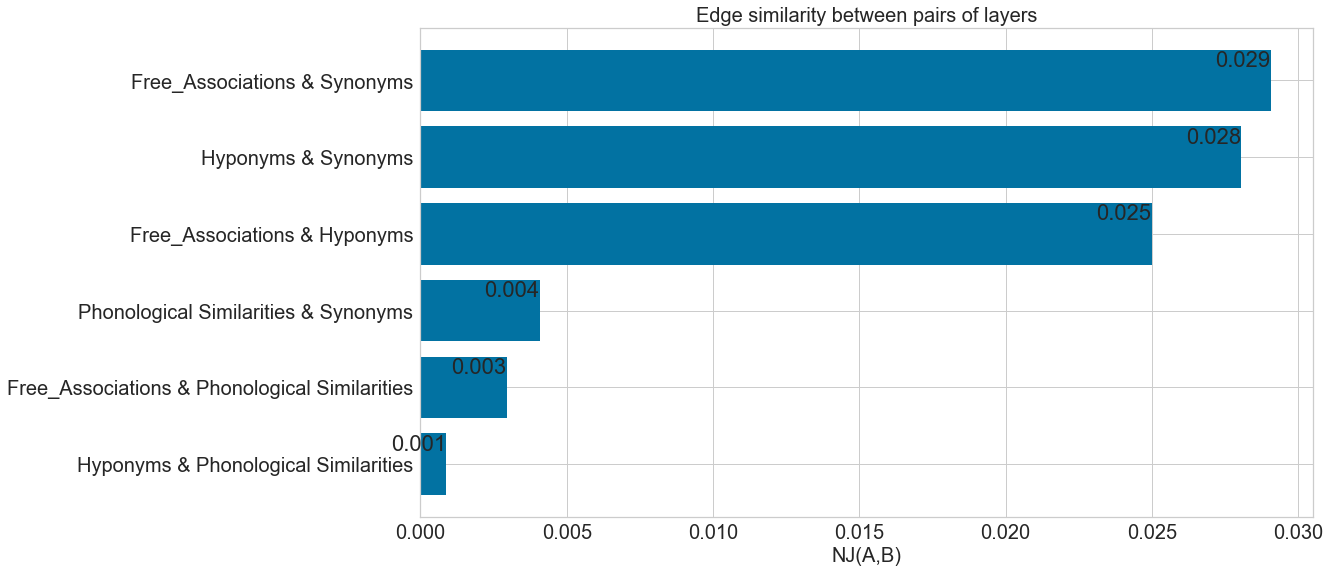

In [27]:
layer_names = ['G_free.edges', 'G_hypo.edges', 'G_phon.edges', 'G_syn.edges']
names = list(combinations(layer_names,2))

layers = {'G_free.edges':[G_free,'Free_Associations'],'G_hypo.edges':[G_hypo,'Hyponyms'], 
          'G_phon.edges':[G_phon,'Phonological Similarities'], 'G_syn.edges':[G_syn,'Synonyms']}


jaccards = {}
for i in names:
    
    a = i[0]
    b = i[1]
    j = jaccard(layers[a][0],layers[b][0])
    name = f'{layers[a][1]} & {layers[b][1]}'
    jaccards[name] = j


sorted_jaccard = {k: v for k, v in sorted(jaccards.items(), key=lambda item: item[1])}

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))


xs = list(sorted_jaccard.keys())
ys = list(sorted_jaccard.values())
 
# Horizontal Bar Plot
ax.barh(xs, ys)
plt.xlabel('NJ(A,B)',fontdict={'fontsize': 20})
#plt.ylabel('')
plt.title('Edge similarity between pairs of layers',fontdict={'fontsize': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


for x,y in zip(xs,ys):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (y,x), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,14), # distance from text to points (x,y)
                 ha='right') # horizontal alignment can be left, right or center

plt.show()

##### Mediation and Suppression

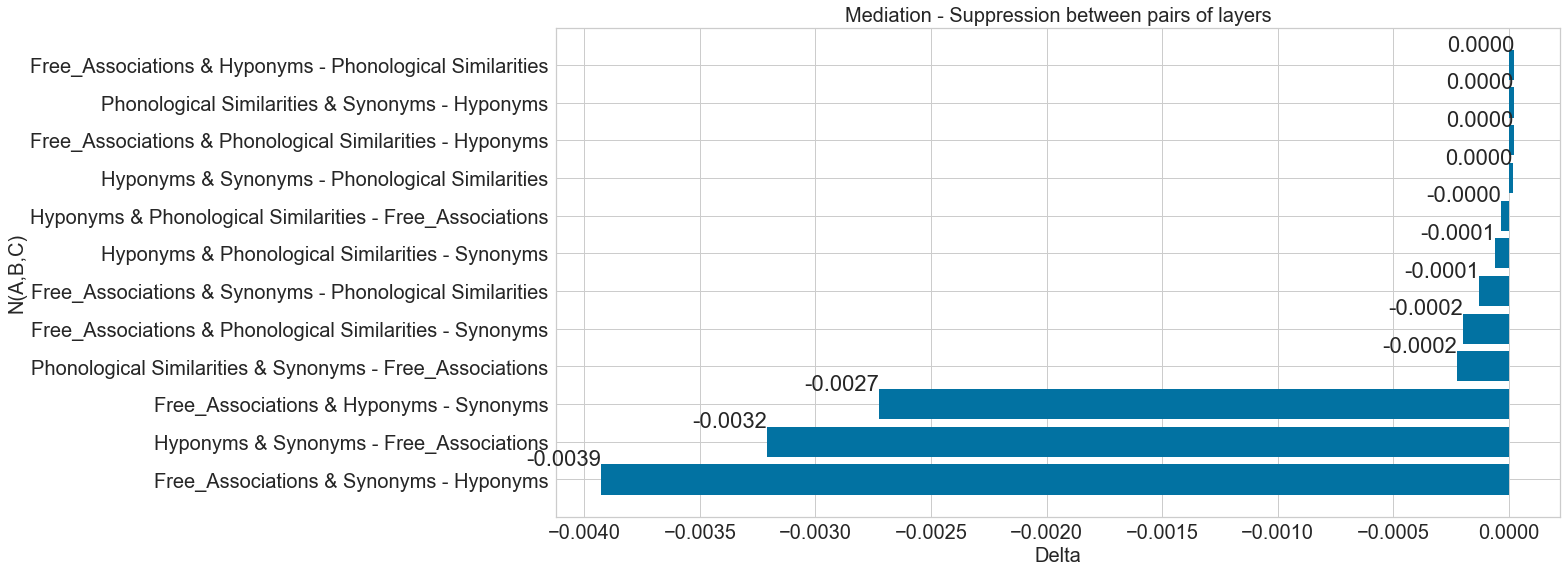

In [28]:
l = [('G_free.edges','G_hypo.edges','G_phon.edges'),
     ('G_free.edges','G_hypo.edges','G_syn.edges'),
     ('G_free.edges','G_phon.edges','G_syn.edges'),
     ('G_free.edges','G_phon.edges','G_hypo.edges'), 
     ('G_free.edges','G_syn.edges','G_hypo.edges'),
     ('G_free.edges','G_syn.edges','G_phon.edges'), 
     ('G_hypo.edges','G_phon.edges','G_syn.edges'),
     ('G_hypo.edges','G_phon.edges','G_free.edges'),
     ('G_hypo.edges','G_syn.edges','G_phon.edges'),
     ('G_hypo.edges','G_syn.edges','G_free.edges'),
     ('G_phon.edges','G_syn.edges','G_hypo.edges'),
     ('G_phon.edges','G_syn.edges','G_free.edges')]


layers = {'G_free.edges':[G_free,'Free_Associations'],'G_hypo.edges':[G_hypo,'Hyponyms'], 
          'G_phon.edges':[G_phon,'Phonological Similarities'], 'G_syn.edges':[G_syn,'Synonyms']}

delta_scores = {}
for i in l:
    
    a = i[0]
    b = i[1]
    c = i[2]
    
    ds = delta(layers[a][0],layers[b][0],layers[c][0])
    name = f'{layers[a][1]} & {layers[b][1]} - {layers[c][1]}'
    
    delta_scores[name] = ds

    
sorted_delta = {k: v for k, v in sorted(delta_scores.items(), key=lambda item: item[1])}

# Figure Size
fig, ax = plt.subplots(figsize =(18, 9))

xs = list(sorted_delta.keys())
ys = list(sorted_delta.values())
 
# Horizontal Bar Plot
ax.barh(xs, ys)
plt.xlabel('Delta',fontdict={'fontsize': 20})
plt.ylabel('N(A,B,C)',fontdict={'fontsize': 20})
plt.title('Mediation - Suppression between pairs of layers',fontdict={'fontsize': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

for x,y in zip(xs,ys):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (y,x), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,14), # distance from text to points (x,y)
                 ha='right') # horizontal alignment can be left, right or center

plt.show()

# METHODS

### Transformations 

In [70]:
# reduced data: features with high VIF are removed
data_vif = data.drop(['Number_of_response','Jaccard_L2','Jaccard_L3'],axis=1)

In [71]:
# transformed data: square root transformation  
sqrt_data = data.copy()
sqrt_data['Avg_word_length'] = sqrt_data['Avg_word_length'].apply(lambda x: np.sqrt(x))
sqrt_data['Repeated_word'] = sqrt_data['Repeated_word'].apply(lambda x: np.sqrt(x))
sqrt_data['Links_in_L2'] = sqrt_data['Links_in_L2'].apply(lambda x: np.sqrt(x))
sqrt_data['Links_in_L3'] = sqrt_data['Links_in_L3'].apply(lambda x: np.sqrt(x))
sqrt_data['Links_in_L4'] = sqrt_data['Links_in_L4'].apply(lambda x: np.sqrt(x))

In [72]:
# reduced and transformed data
sqrt_data_vif = data_vif.copy()
sqrt_data_vif['Avg_word_length'] = sqrt_data_vif['Avg_word_length'].apply(lambda x: np.sqrt(x))
sqrt_data_vif['Repeated_word'] = sqrt_data_vif['Repeated_word'].apply(lambda x: np.sqrt(x))
sqrt_data_vif['Links_in_L2'] = sqrt_data_vif['Links_in_L2'].apply(lambda x: np.sqrt(x))
sqrt_data_vif['Links_in_L3'] = sqrt_data_vif['Links_in_L3'].apply(lambda x: np.sqrt(x))
sqrt_data_vif['Links_in_L4'] = sqrt_data_vif['Links_in_L4'].apply(lambda x: np.sqrt(x))

##### Explore transformed data after transformation

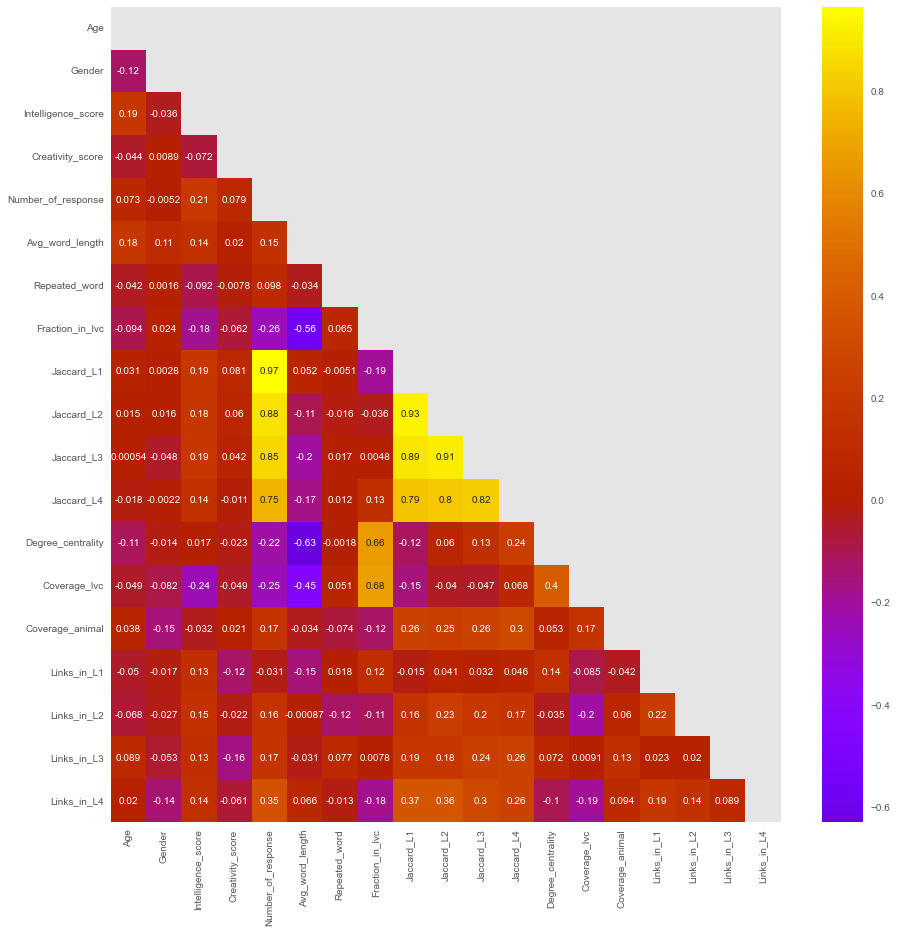

In [194]:
# correlation heatmap
corr = sqrt_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# generate heatmap
plt.figure(figsize= (15,15))
sns.heatmap(corr, annot=True, center=0, mask=mask, cmap='gnuplot')
plt.show()

Skewness: 0.593957
Kurtosis: 2.467950


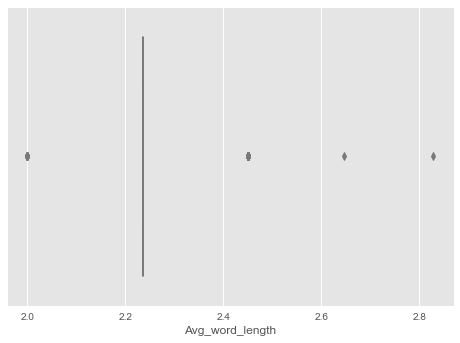

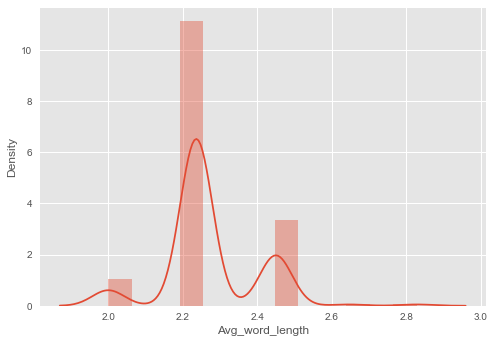

Skewness: 2.832635
Kurtosis: 6.737601


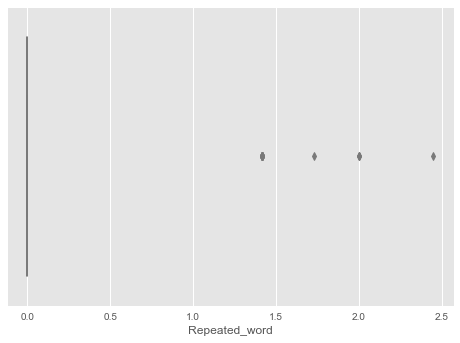

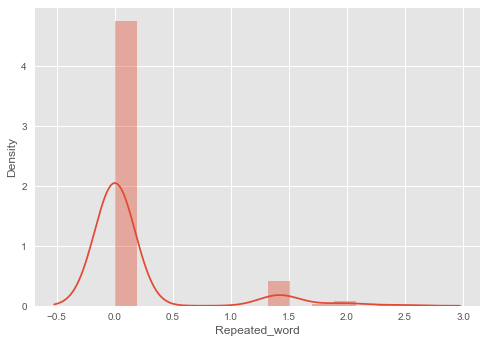

Skewness: 1.053360
Kurtosis: -0.647275


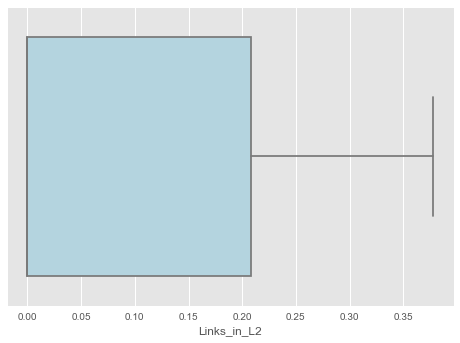

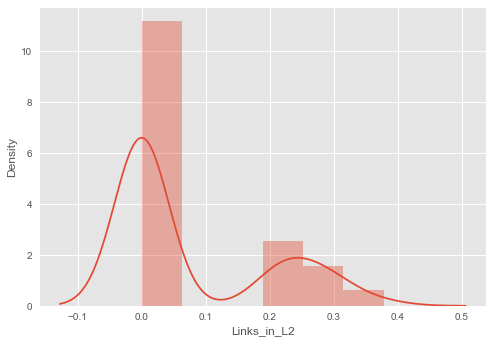

Skewness: 4.408378
Kurtosis: 18.420248


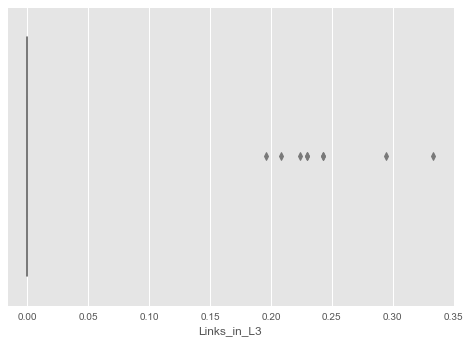

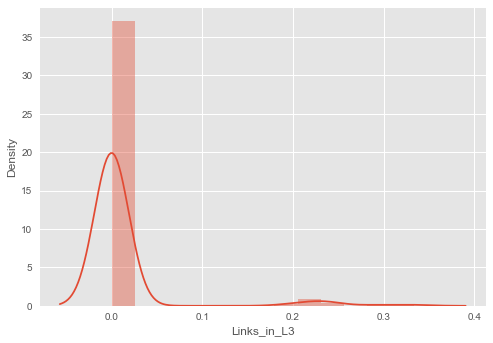

Skewness: 3.445778
Kurtosis: 10.294693


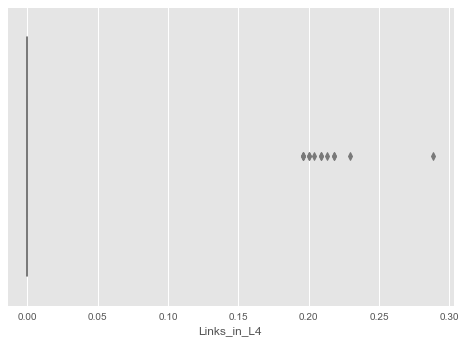

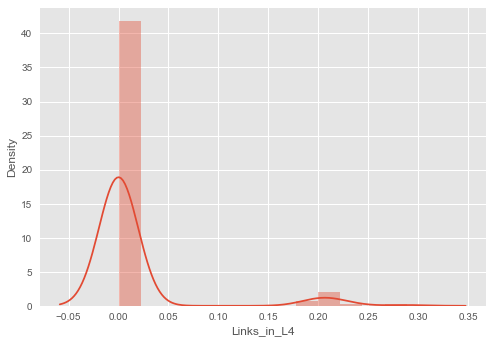

In [514]:
# box and density plots for the fatures
cols = ['Avg_word_length', 'Repeated_word', 'Links_in_L2', 'Links_in_L3', 'Links_in_L4']
for column in cols:
    
    print("Skewness: %f" % sqrt_data[column].skew())
    print("Kurtosis: %f" % sqrt_data[column].kurt())
    
    plt.style.use('ggplot')
    sns.boxplot(sqrt_data[column], color='lightblue')
    plt.show()
    
    sns.distplot(sqrt_data[column]) #hist_kws=dict(color='plum', edgecolor="k", linewidth=1)
    plt.show()

### Data Split

In [73]:
# constant values
random_state = 1
test_size = 0.2

In [74]:
# function to apply Staandard Scaling 
def scale(X):
    transformer = StandardScaler().fit(X)
    x_scaled = transformer.transform(X)
    return x_scaled

In [75]:
# Splitting the original data

X = data.drop('Creativity_score',axis=1)
y = data['Creativity_score']

x_scaled = scale(X)

#Left a part of the data apart as a test data set
x_org_m, x_org_test, y_org_m, y_org_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
x_org_s, x_org_s_test, y_org_s, y_org_s_test = train_test_split(x_scaled, y, test_size=test_size, random_state=random_state)

In [76]:
# Splitting the transformed data

X_sqrt = sqrt_data.drop('Creativity_score',axis=1)
y_sqrt = sqrt_data['Creativity_score']

x_sqrt_scaled = scale(X_sqrt)

#Left a part of the data apart as a test data set
x_sqrt_m, x_sqrt_test, y_sqrt_m, y_sqrt_test = train_test_split(X_sqrt, y_sqrt, test_size=test_size, random_state=random_state)
x_sqrt_s_m, x_sqrt_s_test, y_sqrt_s_m, y_sqrt_s_test = train_test_split(x_sqrt_scaled, y_sqrt, test_size=test_size, random_state=random_state)

In [77]:
# Splitting the feature reduced data

X_vif = data_vif.drop('Creativity_score',axis=1)
y_vif = data_vif['Creativity_score']

x_vif_scaled = scale(X_vif)

#Left a part of the data apart as a test data set
x_vif_m, x_vif_test, y_vif_m, y_vif_test = train_test_split(X_vif, y_vif, test_size=test_size, random_state=random_state)
x_vif_s_m, x_vif_s_test, y_vif_s_m, y_vif_s_test = train_test_split(x_vif_scaled, y_vif, test_size=test_size, random_state=random_state)

In [78]:
# Splitting the transformed and feature reduced data

X_sqrt2 = sqrt_data_vif.drop('Creativity_score',axis=1)
y_sqrt2 = sqrt_data_vif['Creativity_score']

x_sqrt2_scaled = scale(X_sqrt2)

#Left a part of the data apart as a test data set
x_sqrt2_m, x_sqrt2_test, y_sqrt2_m, y_sqrt2_test = train_test_split(X_sqrt2, y_sqrt2, test_size=test_size, random_state=random_state)
x_sqrt2_s_m, x_sqrt2_s_test, y_sqrt2_s_m, y_sqrt2_s_test = train_test_split(x_sqrt2_scaled, y_sqrt2, test_size=test_size, random_state=random_state)

## Models

In [377]:
# kFold CV : K=5
n = ['x_org_m,y_org_m','x_scaled,y', 'x_sqrt, y_sqrt','x_sqrt_scaled,y_sqrt','X_vif, y_vif', 'x_vif_scaled,y_vif']
v = [(x_org_m,y_org_m), (x_org_s,y_org_s), (x_sqrt_m, y_sqrt_m), (x_sqrt_s_m,y_sqrt_s_m),(x_vif_m, y_vif_m), (x_vif_s_m,y_vif_s_m)]

models = [('SVR', SVR()) ,
          ('XGboost', xgb.XGBRegressor(objective="reg:squarederror", random_state=random_state)),
          ('RandomForest', RandomForestRegressor(random_state=random_state)),
          ('Ridge',  Ridge()),
          ('Lasso', Lasso()) ]


for idx,element in enumerate(v):

    print(n[idx],'\n')
    
    x_m, y_m = element[0], element[1]

    #To be able to split in the cross-validation
    x_m = pd.DataFrame(x_m)

    skf = KFold(n_splits=5, shuffle=True, random_state=random_state) 
    fold_idxs = list(skf.split(x_m))

    for name, model in models:

            r2 = []
            MSE = []
            RMSE = []
            MAE = []
            names = []
            y_vals = []

            for i, (train_idx, test_idx) in enumerate(fold_idxs): 
                    X_train = x_m.values[train_idx]
                    y_train = y_m.values[train_idx]
                    X_val = x_m.values[test_idx]
                    y_val = y_m.values[test_idx]

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    y_vals.append(y_val)

                    MSE_ = mse(y_val, y_pred)
                    RMSE_ = np.sqrt(MSE_)
                    r_square = r2_score(y_val, y_pred)
                    MAE_ = round(mean_absolute_error(y_val,y_pred),2)
                    

                    r2.append(r_square)
                    MSE.append(MSE_)
                    RMSE.append(RMSE_)
                    MAE.append(MAE_)
                    
            print(name, '\n', 'MSE:', np.round(mean(MSE),2),'\t', 'RMSE:', np.round(mean(RMSE), 2), '\t', 'R-Squared:', np.round(mean(r2), 2), '\t', 'MAE:', np.round(mean(MAE), 2),'\n')


x_org_m,y_org_m 

SVR 
 MSE: 0.21 	 RMSE: 0.46 	 R-Squared: -0.1 	 MAE: 0.36 

XGboost 
 MSE: 0.24 	 RMSE: 0.48 	 R-Squared: -0.23 	 MAE: 0.38 

RandomForest 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.08 	 MAE: 0.36 

Ridge 
 MSE: 0.22 	 RMSE: 0.47 	 R-Squared: -0.18 	 MAE: 0.38 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.05 	 MAE: 0.36 

x_scaled,y 

SVR 
 MSE: 0.22 	 RMSE: 0.47 	 R-Squared: -0.16 	 MAE: 0.37 

XGboost 
 MSE: 0.24 	 RMSE: 0.48 	 R-Squared: -0.23 	 MAE: 0.38 

RandomForest 
 MSE: 0.21 	 RMSE: 0.46 	 R-Squared: -0.1 	 MAE: 0.37 

Ridge 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.09 	 MAE: 0.37 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.05 	 MAE: 0.36 

x_sqrt, y_sqrt 

SVR 
 MSE: 0.21 	 RMSE: 0.46 	 R-Squared: -0.11 	 MAE: 0.36 

XGboost 
 MSE: 0.24 	 RMSE: 0.48 	 R-Squared: -0.23 	 MAE: 0.38 

RandomForest 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.08 	 MAE: 0.36 

Ridge 
 MSE: 0.22 	 RMSE: 0.47 	 R-Squared: -0.15 	 MAE: 0.37 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squar

x_org_m,y_org_m 

SVR


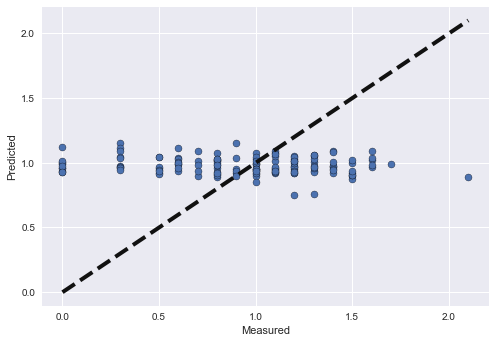

XGboost


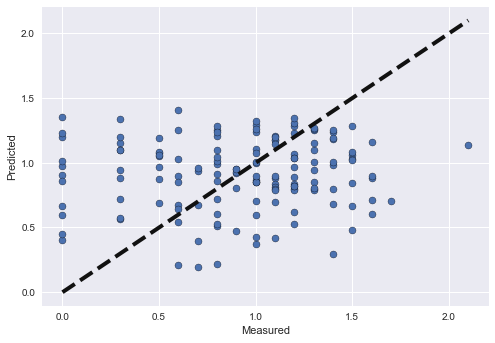

RandomForest


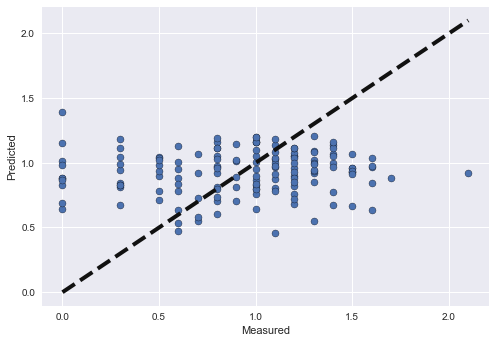

Ridge


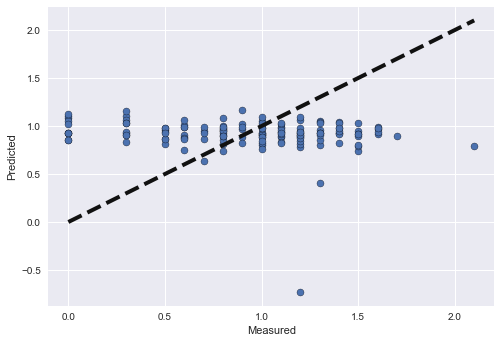

Lasso


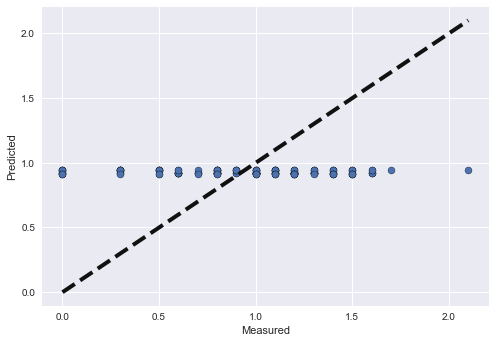

x_scaled,y 

SVR


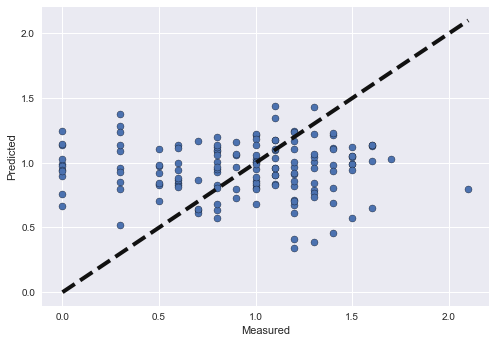

XGboost


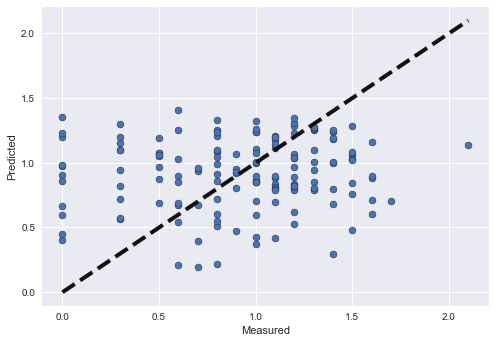

RandomForest


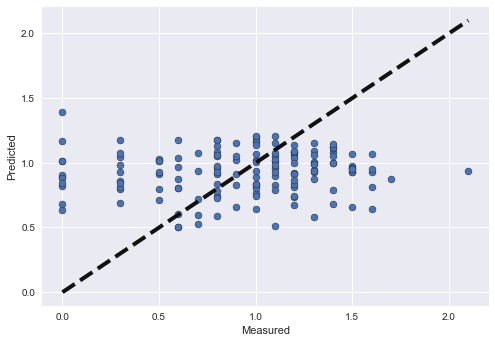

Ridge


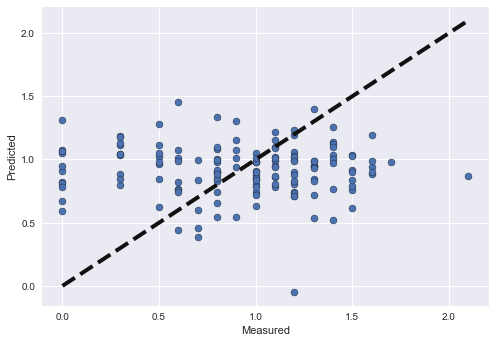

Lasso


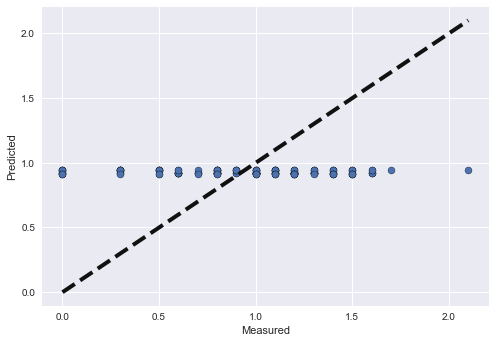

x_sqrt, y_sqrt 

SVR


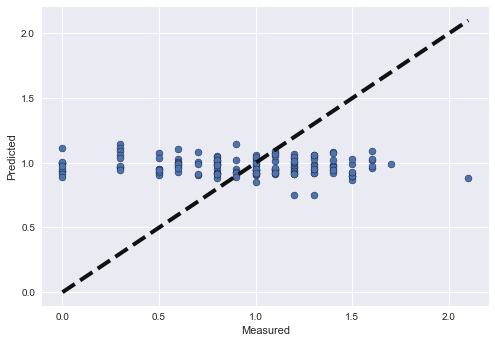

XGboost


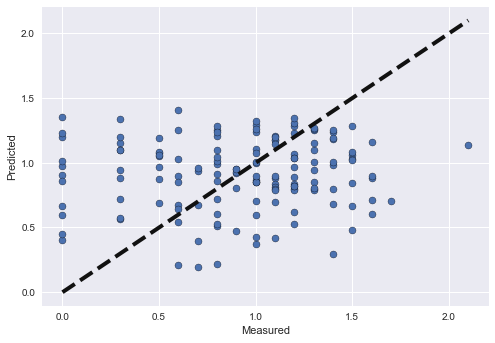

RandomForest


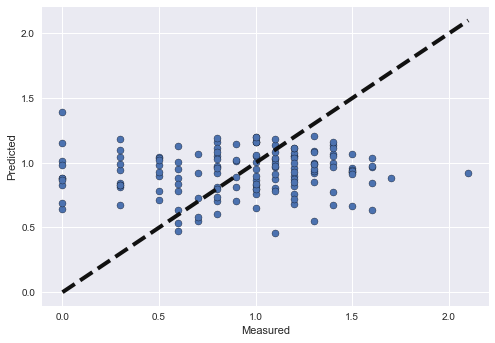

Ridge


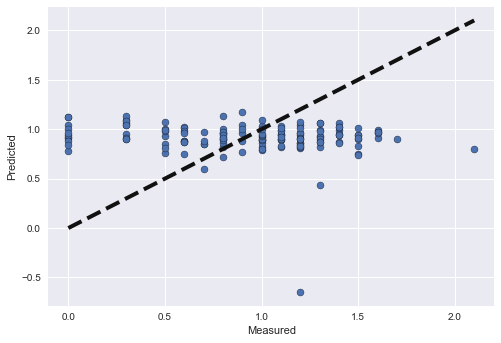

Lasso


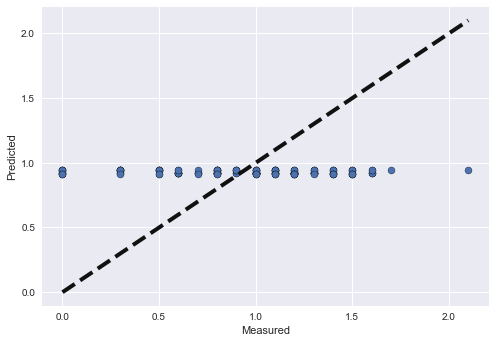

x_sqrt_scaled,y_sqrt 

SVR


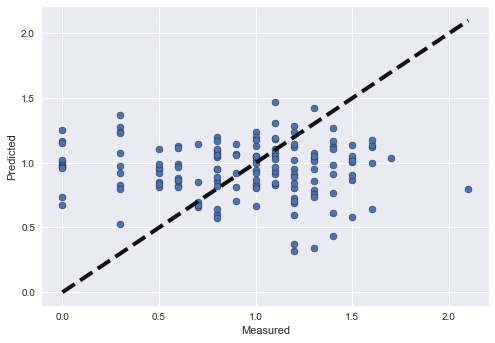

XGboost


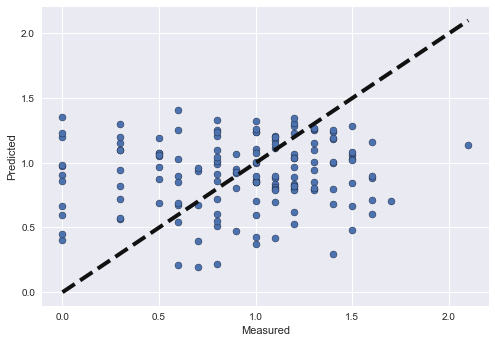

RandomForest


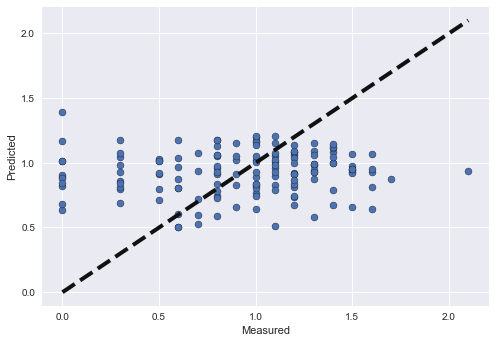

Ridge


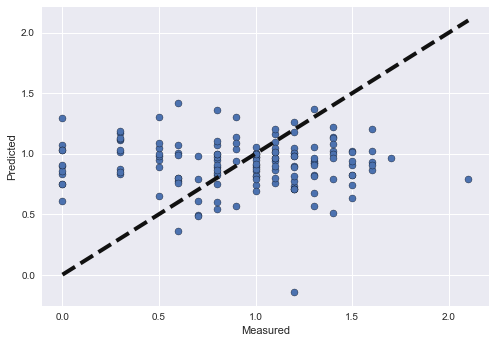

Lasso


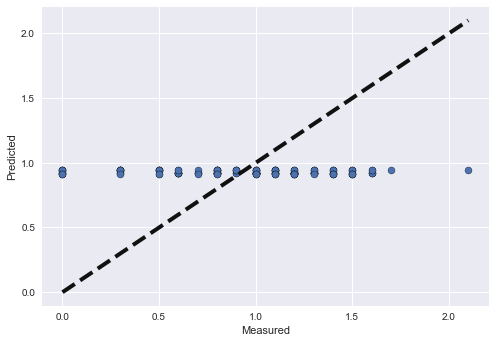

X_vif, y_vif 

SVR


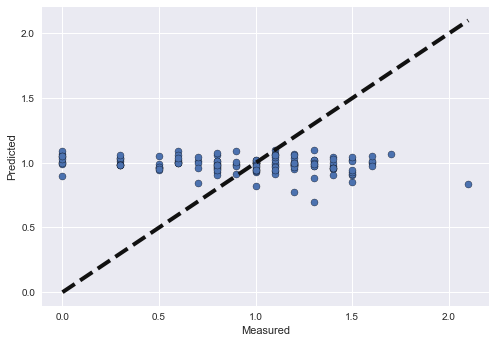

XGboost


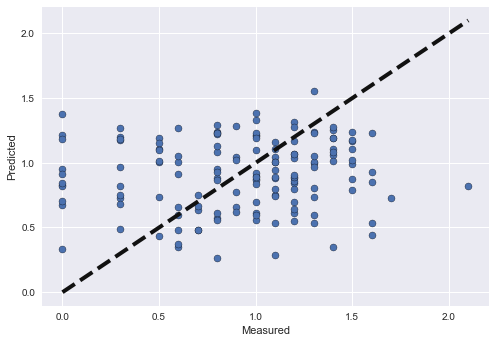

RandomForest


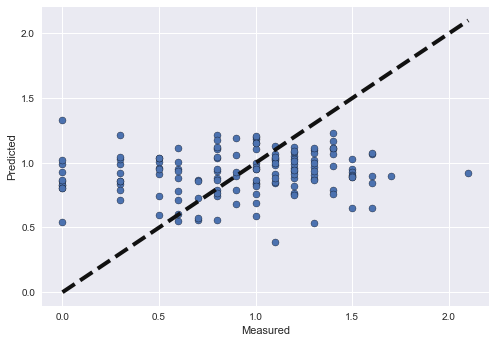

Ridge


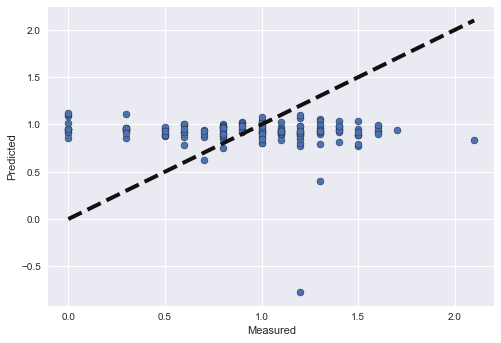

Lasso


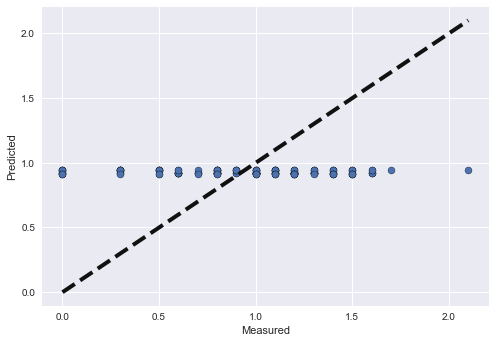

x_vif_scaled,y_vif 

SVR


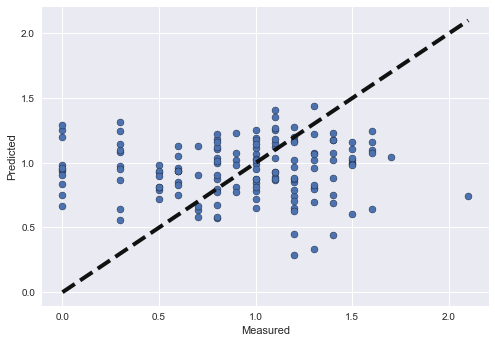

XGboost


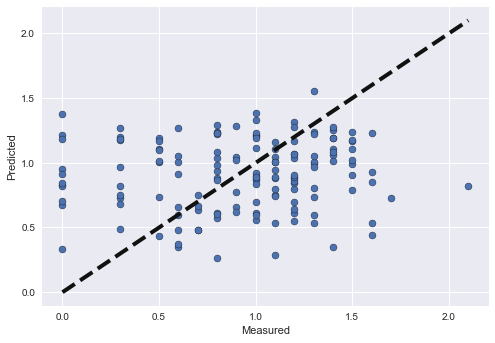

RandomForest


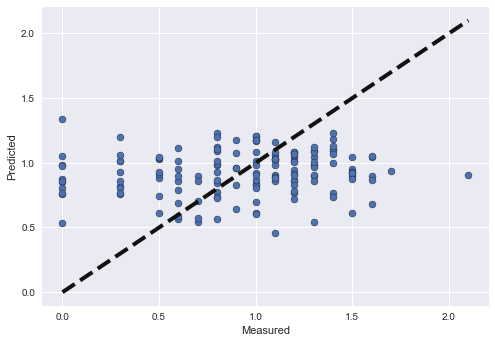

Ridge


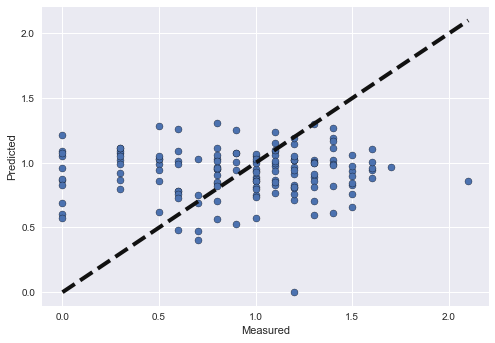

Lasso


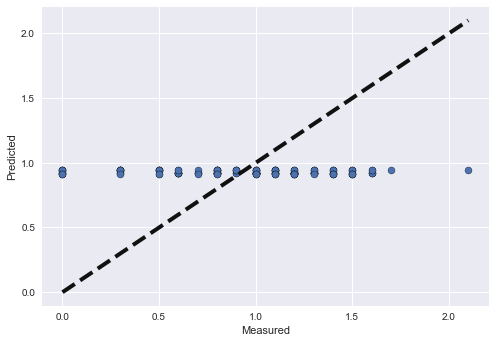

In [474]:
# Scatter plots for actual and predicted 
n = ['x_org_m,y_org_m','x_scaled,y', 'x_sqrt, y_sqrt','x_sqrt_scaled,y_sqrt','X_vif, y_vif', 'x_vif_scaled,y_vif']
v = [(x_org_m,y_org_m), (x_org_s,y_org_s), (x_sqrt_m, y_sqrt_m), (x_sqrt_s_m,y_sqrt_s_m),(x_vif_m, y_vif_m), (x_vif_s_m,y_vif_s_m)]


models = [('SVR', SVR()) ,
          ('XGboost', xgb.XGBRegressor(objective="reg:squarederror", random_state=random_state)),
          ('RandomForest', RandomForestRegressor(random_state=random_state)),
          ('Ridge',  Ridge()),
          ('Lasso', Lasso()) ]


for idx,element in enumerate(v):
    
    print(n[idx],'\n')
    #Left a part of the data apart as a test data set
    x_m, y_m = element[0], element[1]

    for name, model in models:
        print(name)
        
        predicted = cross_val_predict(model, x_m, y_m, cv=5)

        fig, ax = plt.subplots()
        ax.scatter(y_m, predicted, edgecolors=(0, 0, 0))
        ax.plot([y_m.min(), y_m.max()], [y_m.min(), y_m.max()], "k--", lw=4)
        ax.set_xlabel("Measured")
        ax.set_ylabel("Predicted")
        plt.show()



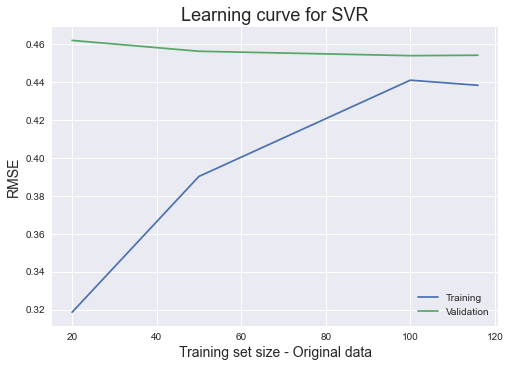

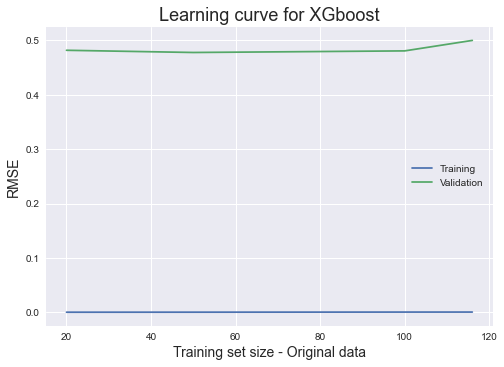

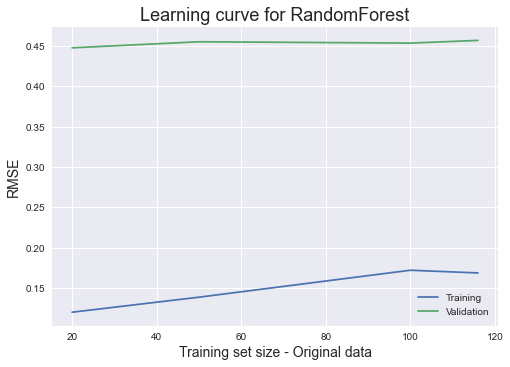

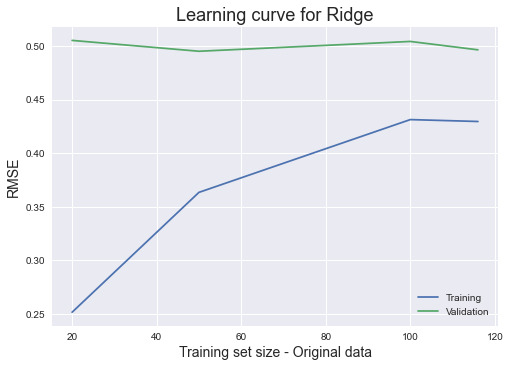

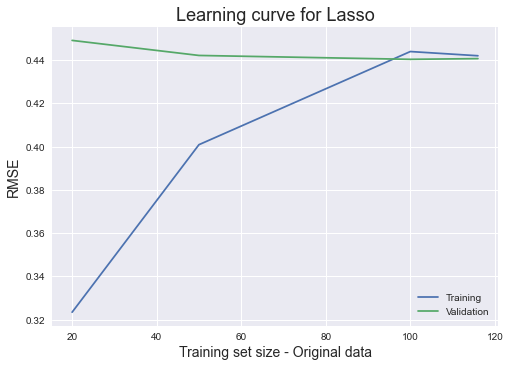

In [394]:
#Learning curves for original data

x_train = x_org_m
y_train = y_org_m

train_size = [20, 50, 100, 116]

for name, model in models:

            train_scores = []
            validation_scores = []

            train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                X = x_train, y = y_train, train_sizes = train_size , cv = 5, scoring = 'neg_root_mean_squared_error')

            train_scores_mean = -train_scores.mean(axis = 1)
            validation_scores_mean = -validation_scores.mean(axis = 1)

            plt.figure()
            plt.style.use('seaborn')
            plt.plot(train_sizes, train_scores_mean, label = 'Training')
            plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
            plt.ylabel('RMSE', fontsize = 14)
            plt.xlabel('Training set size - Original data', fontsize = 14)
            plt.title('Learning curve for ' + name, fontsize = 18)
            plt.legend()



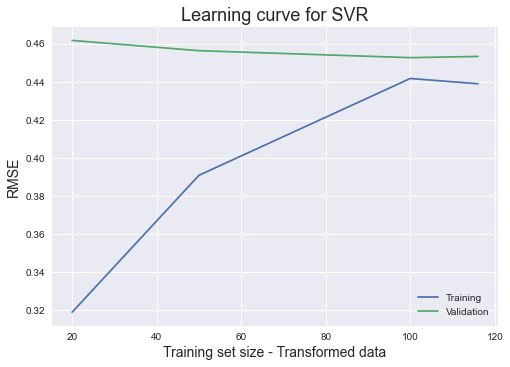

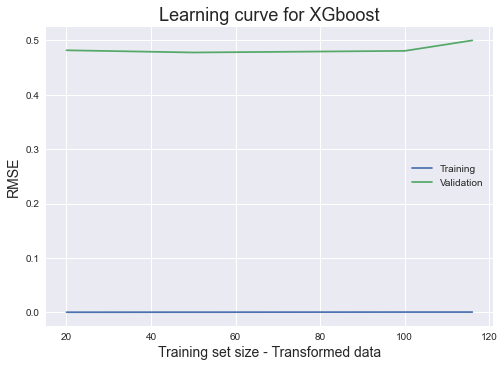

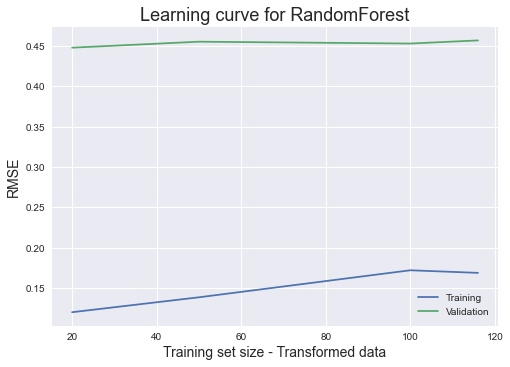

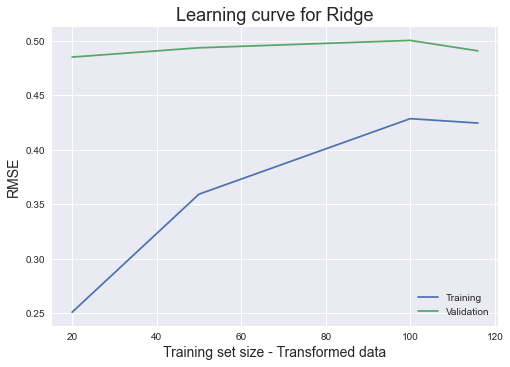

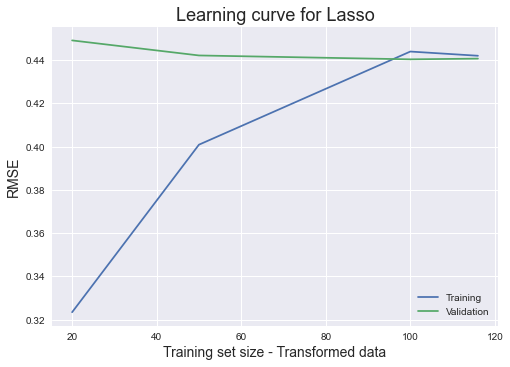

In [395]:
#Learning curves for transformed data


x_train = x_sqrt_m 
y_train = y_sqrt_m

train_size = [20, 50, 100, 116]

for name, model in models:

            train_scores = []
            validation_scores = []

            train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                X = x_train, y = y_train, train_sizes = train_size , cv = 5, scoring = 'neg_root_mean_squared_error')

            train_scores_mean = -train_scores.mean(axis = 1)
            validation_scores_mean =  -validation_scores.mean(axis = 1)

            plt.figure()
            plt.style.use('seaborn')
            plt.plot(train_sizes, train_scores_mean, label = 'Training')
            plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
            plt.ylabel('RMSE', fontsize = 14)
            plt.xlabel('Training set size - Transformed data', fontsize = 14)
            plt.title('Learning curve for ' + name, fontsize = 18)
            plt.legend()


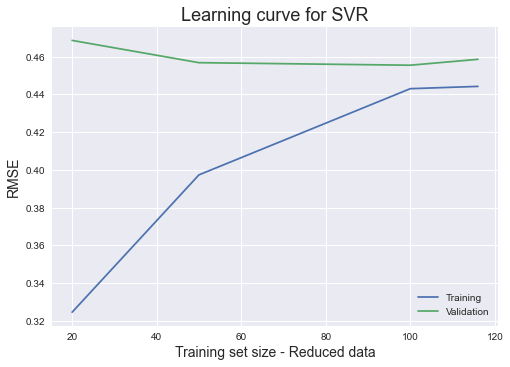

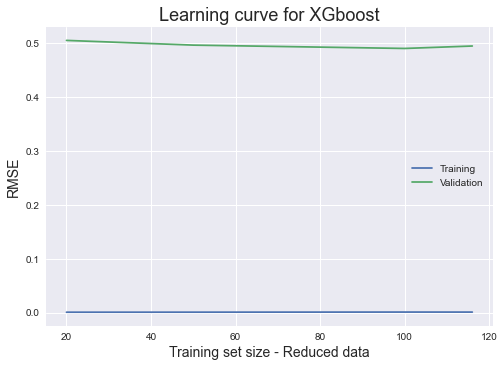

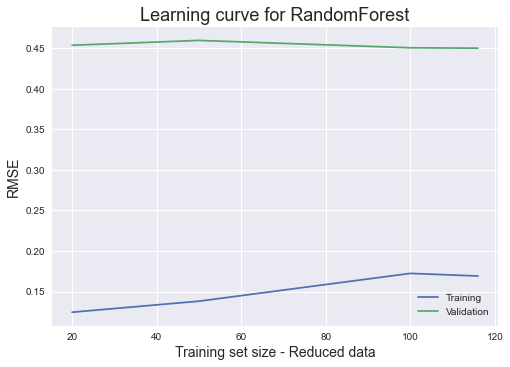

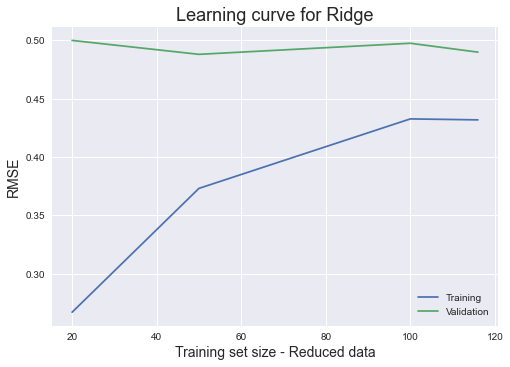

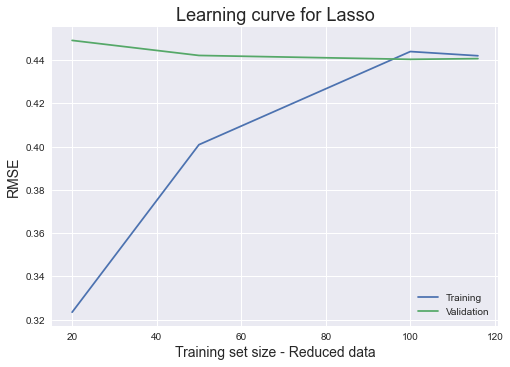

In [396]:
#Learning curves for reduced data


x_train = x_vif_m 
y_traim = y_vif_m

train_size = [20, 50, 100, 116]

for name, model in models:

            train_scores = []
            validation_scores = []

            train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                X = x_train, y = y_train, train_sizes = train_size , cv = 5, scoring = 'neg_root_mean_squared_error')

            train_scores_mean = -train_scores.mean(axis = 1)
            validation_scores_mean = -validation_scores.mean(axis = 1)

            plt.figure()
            plt.style.use('seaborn')
            plt.plot(train_sizes, train_scores_mean, label = 'Training')
            plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
            plt.ylabel('RMSE', fontsize = 14)
            plt.xlabel('Training set size - Reduced data', fontsize = 14)
            plt.title('Learning curve for ' + name, fontsize = 18)
            plt.legend()



In [397]:
# GridSearch CV - original, transformed, reduced data - Random Forest Regressor

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


n = ['x_org, y_org', 'X_sqrt, y_sqrt','X_vif, y_vif']
v = [(x_org_m, y_org_m), (x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m)]

for idx,element in enumerate(v):
    
    X_train, y_train = element[0], element[1]

    grid = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=1)
    grid.fit(X_train,y_train)

    print(n[idx])
    print(grid.best_estimator_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
x_org, y_org
RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=200)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
X_sqrt, y_sqrt
RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
X_vif, y_vif
RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10)


In [404]:
# GridSearch CV - transformed and reduced - Random Forest Regressor

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


n = ['X_sqrt2, y_sqrt2']
v = [(x_sqrt2_m,y_sqrt2_m)]

for idx,element in enumerate(v):
    
    X_train, y_train = element[0], element[1]

    grid = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=1)
    grid.fit(X_train,y_train)

    print(n[idx])
    print(grid.best_estimator_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
X_sqrt2, y_sqrt2
RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10)


In [398]:
# GridSearch CV - original, transformed, reduced data - Support Vector Regressor


param_grid = {'C': [1, 10, 50, 100], 'epsilon': [0.1,0.5,0.9,1],'kernel': ['rbf', 'poly', 'sigmoid']}

n = ['x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif',]
v = [(x_org_m, y_org_m), (x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m)]

for idx,element in enumerate(v):
    
    #Left a part of the data apart as a test data set
    X_train, y_train = element[0], element[1]

    grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=1)
    grid.fit(X_train,y_train)

    print(n[idx])
    print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
x_org, y_org
SVR(C=1, epsilon=1, kernel='sigmoid')
Fitting 5 folds for each of 48 candidates, totalling 240 fits
X_sqrt, y_sqrt
SVR(C=1, epsilon=1, kernel='sigmoid')
Fitting 5 folds for each of 48 candidates, totalling 240 fits
X_vif, y_vif
SVR(C=1, epsilon=1, kernel='sigmoid')


In [399]:
# GridSearch CV - original, transformed, reduced data - Ridge Regressor

param_grid = {'alpha': [1, 10, 50, 100]}

n = ['x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif',]
v = [(x_org_m, y_org_m),(x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m)]

for idx,element in enumerate(v):
    
    X_train, y_train = element[0], element[1]

    grid = GridSearchCV(Ridge(),param_grid,refit=True,verbose=1)
    grid.fit(X_train,y_train)

    print(n[idx])
    print(grid.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
x_org, y_org
Ridge(alpha=100)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
X_sqrt, y_sqrt
Ridge(alpha=100)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
X_vif, y_vif
Ridge(alpha=100)


In [400]:
# GridSearch CV - original, transformed, reduced data - Lasso Regressor

param_grid = {'max_iter': [10, 50, 100, 1000], 'alpha': [1, 10, 50, 100], }

n = [ 'x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif',]
v = [ (x_org_m, y_org_m),(x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m)]

for idx,element in enumerate(v):
    
    #Left a part of the data apart as a test data set
    X_train, y_train = element[0], element[1]

    grid = GridSearchCV(Lasso(),param_grid,refit=True,verbose=1)
    grid.fit(X_train,y_train)

    print(n[idx])
    print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
x_org, y_org
Lasso(alpha=1, max_iter=10)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
X_sqrt, y_sqrt
Lasso(alpha=1, max_iter=10)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
X_vif, y_vif
Lasso(alpha=1, max_iter=10)


In [401]:
# Parameter tuning - Kfold - SVR, Ridge, Lasso


n = [ 'x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif', 'X_sqrt2, y_sqrt2']
v = [(x_org_m, y_org_m),(x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m), (x_sqrt2_m,y_sqrt2_m)]


models = [('SVR', SVR(C=1, epsilon=1)) ,
          ('Ridge',  Ridge(alpha=100)),
          ('Lasso', Lasso(alpha=1, max_iter=10)) ]

for idx,element in enumerate(v):
    
    print(n[idx],'\n')
    x_m, y_m = element[0], element[1]

    #To be able to split in the cross-validation
    x_m = pd.DataFrame(x_m)

    skf = KFold(n_splits=5, shuffle=True, random_state=random_state) 
    fold_idxs = list(skf.split(x_m))

    for name, model in models:

            r2 = []
            MSE = []
            RMSE = []
            MAE = [] 
            names = []
            y_vals = []

            for i, (train_idx, test_idx) in enumerate(fold_idxs): 
                    X_train = x_m.values[train_idx]
                    y_train = y_m.values[train_idx]
                    X_val = x_m.values[test_idx]
                    y_val = y_m.values[test_idx]

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    y_vals.append(y_val)

                    MSE_ = mse(y_val, y_pred)
                    RMSE_ = np.sqrt(MSE_)
                    r_square = r2_score(y_val, y_pred)
                    MAE_ = round(mean_absolute_error(y_val,y_pred),2)

                    r2.append(r_square)
                    MSE.append(MSE_)
                    RMSE.append(RMSE_)
                    MAE.append(MAE_)
                    
            print(name, '\n', 'MSE:', np.round(mean(MSE),2),'\t', 'RMSE:', np.round(mean(RMSE), 2), '\t', 'R-Squared:', np.round(mean(r2), 2), '\t', 'MAE:', np.round(mean(MAE), 2),'\n')

            #print("Residual Skew: "+str(round(stats.skew((y_pred)-(y_val)),2)))
            #print("Residual Kurtosis: "+str(round(stats.kurtosis((y_pred)-(y_val)),2)),':\n')

x_org, y_org 

SVR 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.09 	 MAE: 0.36 

Ridge 
 MSE: 0.21 	 RMSE: 0.46 	 R-Squared: -0.1 	 MAE: 0.37 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.05 	 MAE: 0.36 

X_sqrt, y_sqrt 

SVR 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.09 	 MAE: 0.36 

Ridge 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.1 	 MAE: 0.37 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.05 	 MAE: 0.36 

X_vif, y_vif 

SVR 
 MSE: 0.2 	 RMSE: 0.45 	 R-Squared: -0.08 	 MAE: 0.36 

Ridge 
 MSE: 0.21 	 RMSE: 0.46 	 R-Squared: -0.1 	 MAE: 0.37 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.05 	 MAE: 0.36 

X_sqrt2, y_sqrt2 

SVR 
 MSE: 0.2 	 RMSE: 0.45 	 R-Squared: -0.07 	 MAE: 0.36 

Ridge 
 MSE: 0.21 	 RMSE: 0.45 	 R-Squared: -0.09 	 MAE: 0.37 

Lasso 
 MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.05 	 MAE: 0.36 



x_org, y_org 

SVR


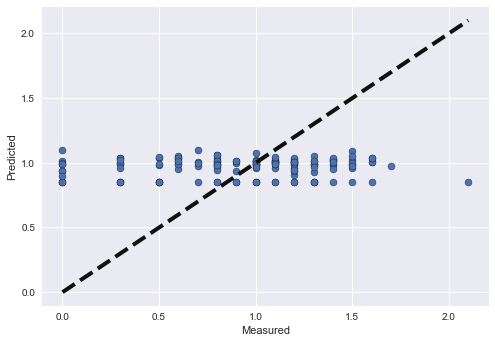

Ridge


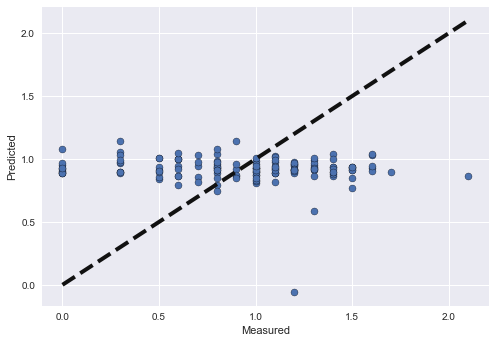

Lasso


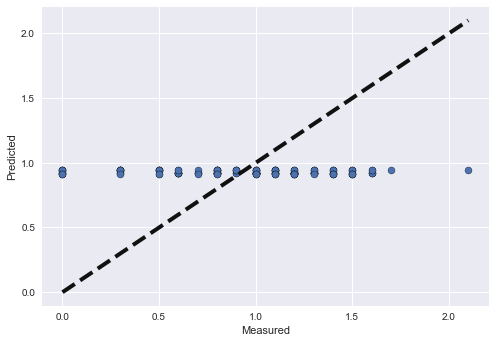

X_sqrt, y_sqrt 

SVR


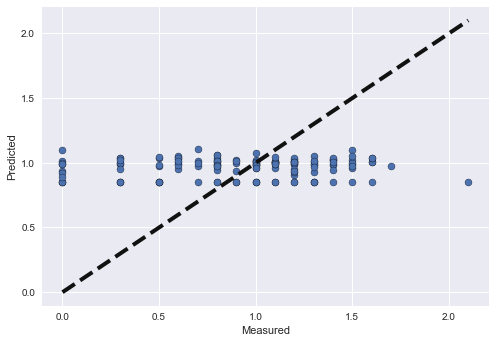

Ridge


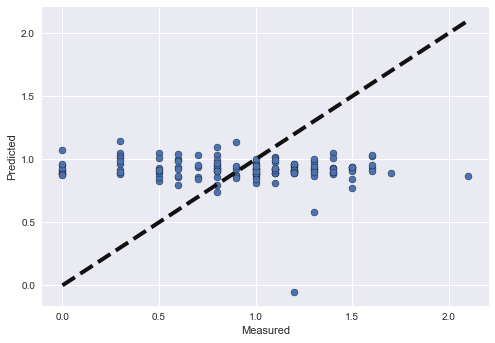

Lasso


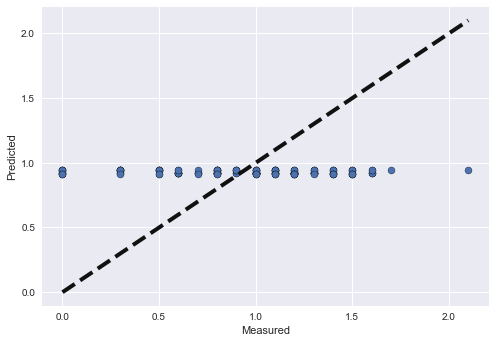

X_vif, y_vif 

SVR


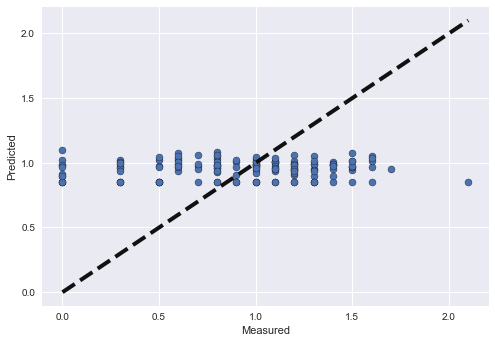

Ridge


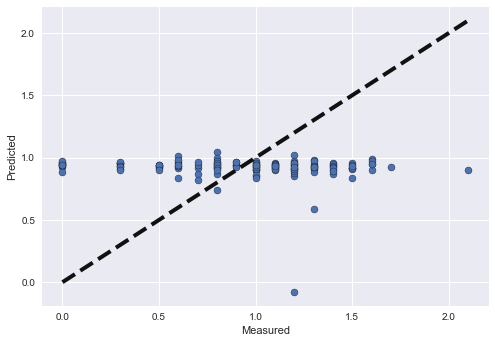

Lasso


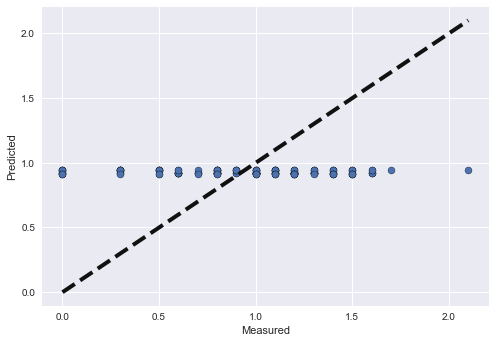

X_sqrt2, y_sqrt2 

SVR


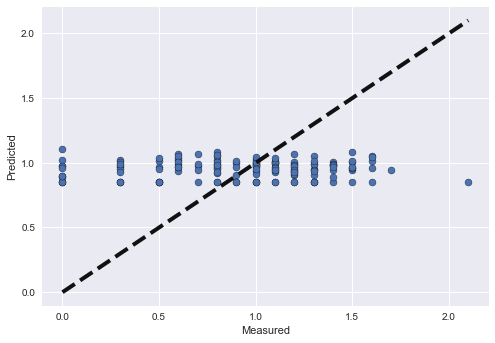

Ridge


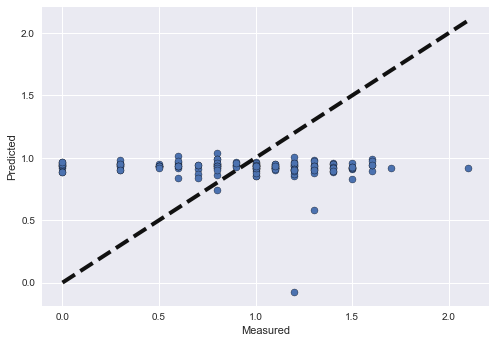

Lasso


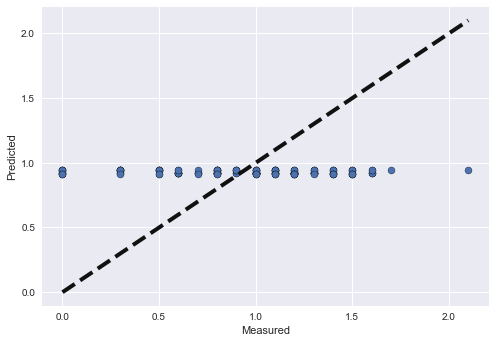

In [475]:
# Scatter plots for actual and predicted - SVR, Ridge, Lasso
n = [ 'x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif', 'X_sqrt2, y_sqrt2']
v = [(x_org_m, y_org_m),(x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m), (x_sqrt2_m,y_sqrt2_m)]


models = [('SVR', SVR(C=1, epsilon=1)) ,
          ('Ridge',  Ridge(alpha=100)),
          ('Lasso', Lasso(alpha=1, max_iter=10)) ]

for idx,element in enumerate(v):
    
    print(n[idx],'\n')
    x_m, y_m = element[0], element[1]

    for name, model in models:
        print(name)
        
        predicted = cross_val_predict(model, x_m, y_m, cv=5)

        fig, ax = plt.subplots()
        ax.scatter(y_m, predicted, edgecolors=(0, 0, 0))
        ax.plot([y_m.min(), y_m.max()], [y_m.min(), y_m.max()], "k--", lw=4)
        ax.set_xlabel("Measured")
        ax.set_ylabel("Predicted")
        plt.show()



In [427]:
# Parameter tuning Kfold - Random Forest Regressor

n = [ 'x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif', 'X_sqrt2, y_sqrt2']
v = [(x_org_m, y_org_m),(x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m), (x_sqrt2_m,y_sqrt2_m)]


models = [ ('Original:', RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=200, random_state=random_state)) ,
          ('Transformed:', RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, random_state=random_state)),
          ('Reduced:' ,RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, random_state=random_state)), 
          ('Transformed & Reduced:' , RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, random_state=random_state))]

for idx,element in enumerate(v):
    
    x_m, y_m = element[0], element[1]

    #To be able to split in the cross-validation
    x_m = pd.DataFrame(x_m)

    skf = KFold(n_splits=5, shuffle=True, random_state=random_state) 
    fold_idxs = list(skf.split(x_m))

    r2 = []
    MSE = []
    RMSE = []
    MAE = []
    names = []
    y_vals = []

    model = models[idx][1]
    print(models[idx][0])
    for i, (train_idx, test_idx) in enumerate(fold_idxs): 
            X_train = x_m.values[train_idx]
            y_train = y_m.values[train_idx]
            X_val = x_m.values[test_idx]
            y_val = y_m.values[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            y_vals.append(y_val)

            MSE_ = mse(y_val, y_pred)
            RMSE_ = np.sqrt(MSE_)
            r_square = r2_score(y_val, y_pred)
            MAE_ = round(mean_absolute_error(y_val,y_pred),2)
            
            r2.append(r_square)
            MSE.append(MSE_)
            RMSE.append(RMSE_)
            MAE.append(MAE_)
    
    print('MSE:', np.round(mean(MSE),2),'\t', 'RMSE:', np.round(mean(RMSE), 2), '\t', 'R-Squared:', np.round(mean(r2), 2), '\t', 'MAE:', np.round(mean(MAE), 2),'\n')

    #print("Residual Skew: "+str(round(stats.skew((y_pred)-(y_val)),2)))
    #print("Residual Kurtosis: "+str(round(stats.kurtosis((y_pred)-(y_val)),2)),':\n')

Original:
MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.04 	 MAE: 0.36 

Transformed:
MSE: 0.2 	 RMSE: 0.44 	 R-Squared: -0.04 	 MAE: 0.36 

Reduced:
MSE: 0.19 	 RMSE: 0.44 	 R-Squared: -0.02 	 MAE: 0.35 

Transformed & Reduced:
MSE: 0.19 	 RMSE: 0.44 	 R-Squared: -0.01 	 MAE: 0.35 



x_org, y_org 

Original:


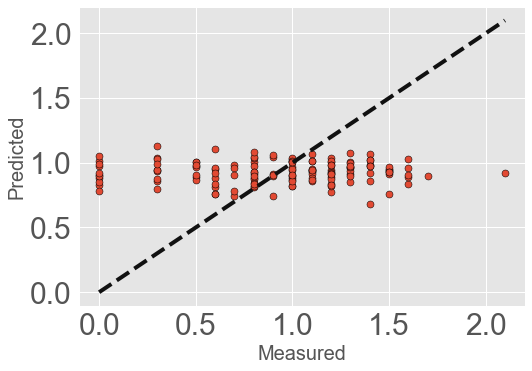

Transformed:


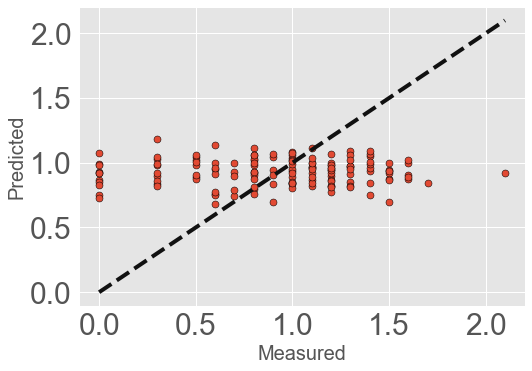

Reduced:


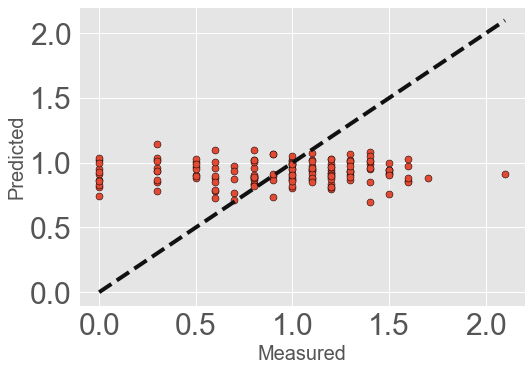

Transformed & Reduced:


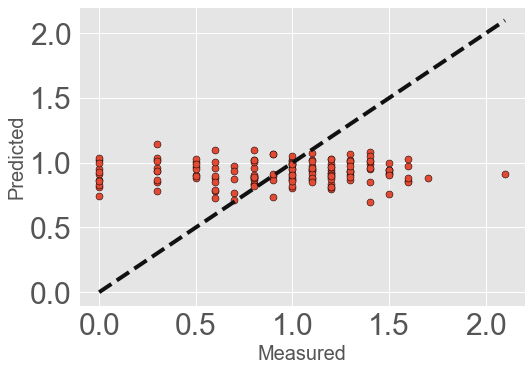

X_sqrt, y_sqrt 

Original:


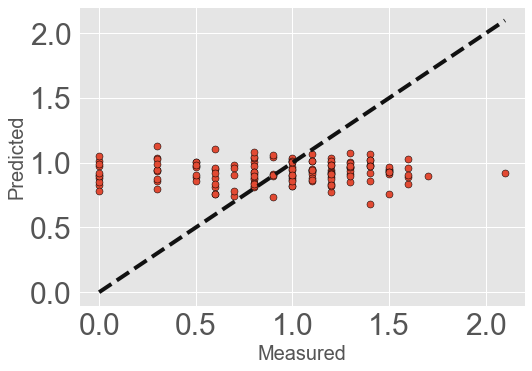

Transformed:


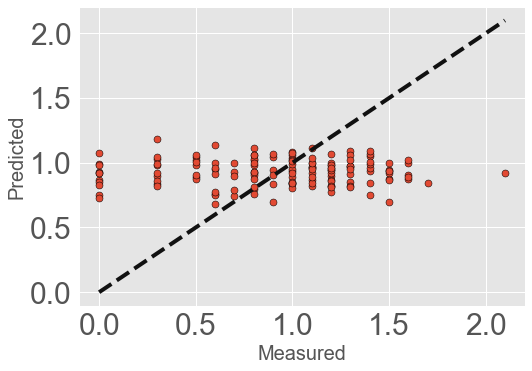

Reduced:


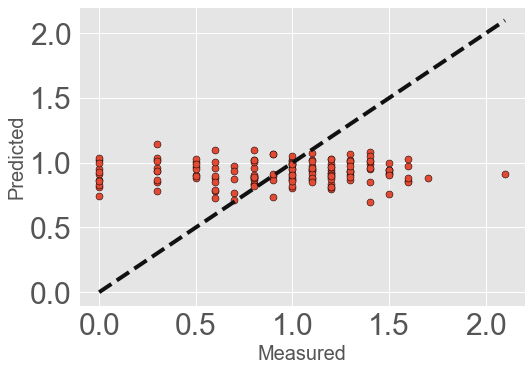

Transformed & Reduced:


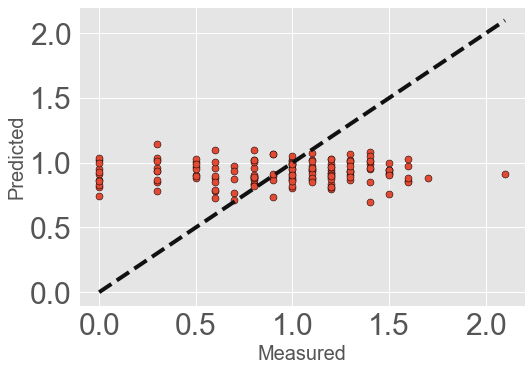

X_vif, y_vif 

Original:


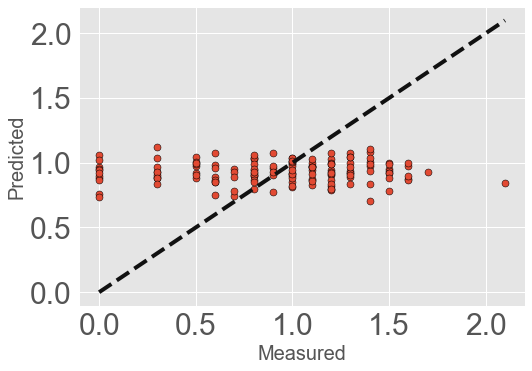

Transformed:


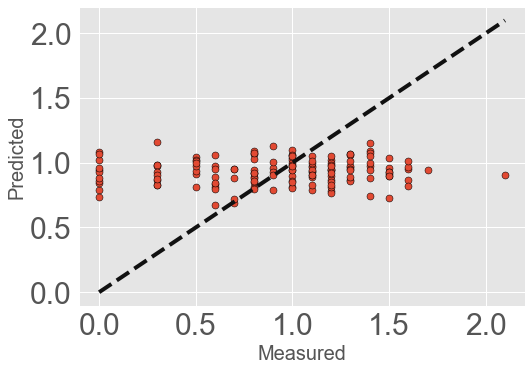

Reduced:


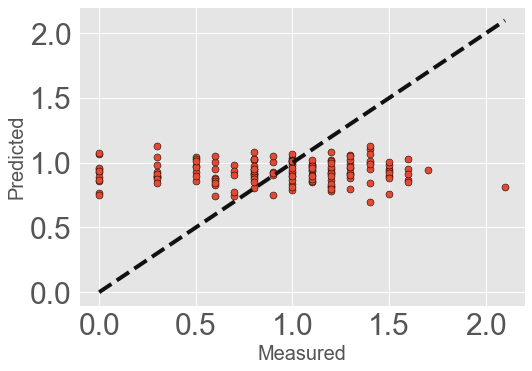

Transformed & Reduced:


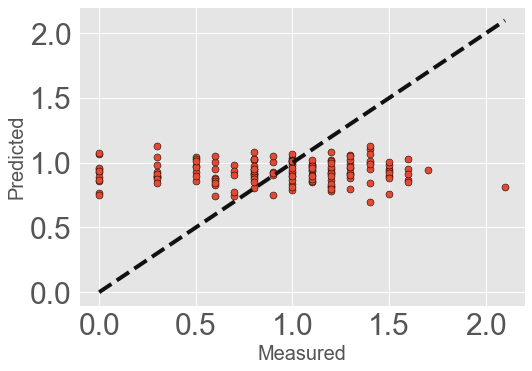

X_sqrt2, y_sqrt2 

Original:


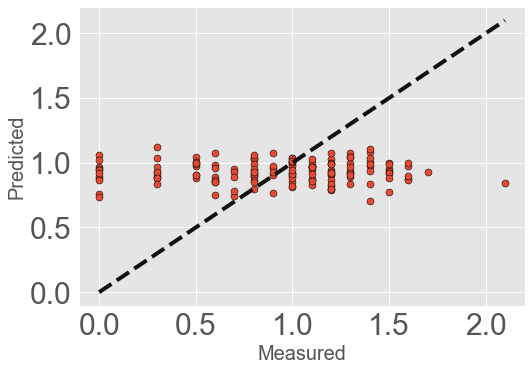

Transformed:


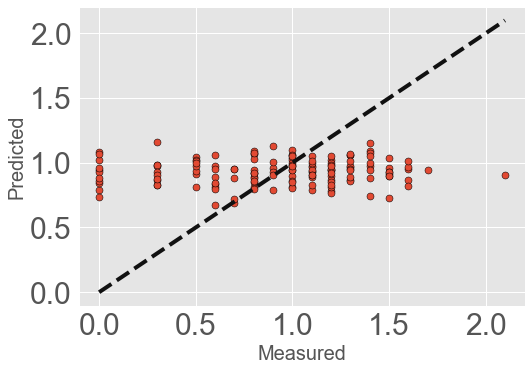

Reduced:


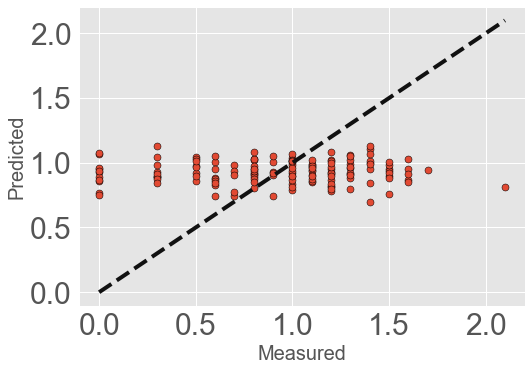

Transformed & Reduced:


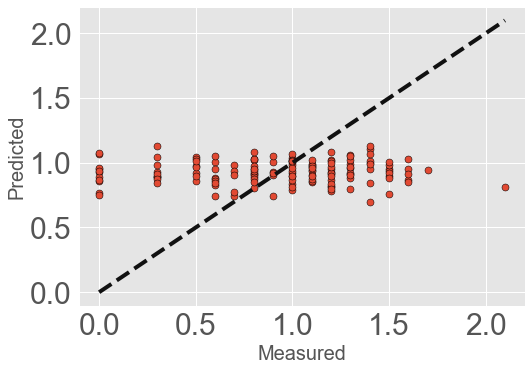

In [159]:
# Scatter plots for actual and predicted - Random Forest Regressor
n = [ 'x_org, y_org','X_sqrt, y_sqrt','X_vif, y_vif', 'X_sqrt2, y_sqrt2']
v = [(x_org_m, y_org_m),(x_sqrt_m, y_sqrt_m), (x_vif_m, y_vif_m), (x_sqrt2_m,y_sqrt2_m)]


models = [ ('Original:', RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=200, random_state=random_state)) ,
          ('Transformed:', RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, random_state=random_state)),
          ('Reduced:' ,RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, random_state=random_state)), 
          ('Transformed & Reduced:' , RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, random_state=random_state))]

for idx,element in enumerate(v):
    
    print(n[idx],'\n')
    #Left a part of the data apart as a test data set
    x_m, y_m = element[0], element[1]

    for name, model in models:
        print(name)
        
        predicted = cross_val_predict(model, x_m, y_m, cv=5)

        fig, ax = plt.subplots()
        ax.scatter(y_m, predicted, edgecolors=(0, 0, 0))
        ax.plot([y_m.min(), y_m.max()], [y_m.min(), y_m.max()], "k--", lw=4)
        ax.set_xlabel("Measured", fontsize=20)
        ax.set_ylabel("Predicted",fontsize=20)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.show()



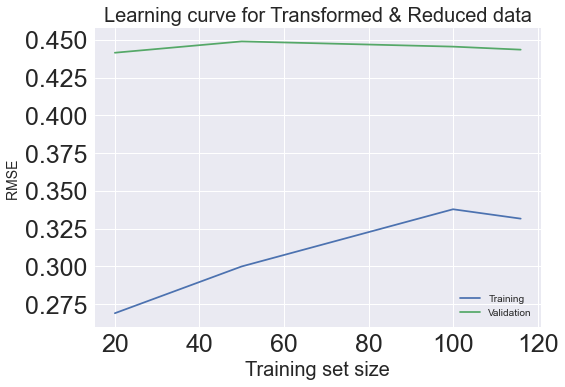

In [162]:
# learning curves for transformed data - RMSE


models = [('Transformed & Reduced data', RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10,random_state=random_state))]

x_train = x_sqrt2_m
y_train = y_sqrt2_m

train_size = [20, 50, 100, 116]

for name, model in models:

            train_scores = []
            validation_scores = []

            train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                X = x_train, y = y_train, train_sizes = train_size , cv = 5, scoring = 'neg_root_mean_squared_error')

            train_scores_mean = -train_scores.mean(axis = 1)
            validation_scores_mean = -validation_scores.mean(axis = 1)

            plt.figure()
            plt.style.use('seaborn')
            plt.plot(train_sizes, train_scores_mean, label = 'Training')
            plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
            plt.ylabel('RMSE ', fontsize = 14)
            plt.xlabel('Training set size', fontsize = 20)
            plt.title('Learning curve for ' + name, fontsize = 20)
            plt.xticks(fontsize=25)
            plt.yticks(fontsize=25)
            
            plt.legend()

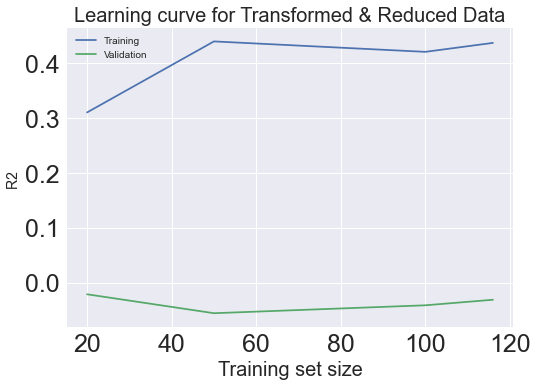

In [163]:
# learning curves for transformed data - R2


models = [('Transformed & Reduced Data', RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10,random_state=random_state))]

x_train = x_sqrt2_m
y_train = y_sqrt2_m

train_size = [20, 50, 100, 116]

for name, model in models:

            train_scores = []
            validation_scores = []

            train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                X = x_train, y = y_train, train_sizes = train_size , cv = 5, scoring = 'r2')

            train_scores_mean = train_scores.mean(axis = 1)
            validation_scores_mean = validation_scores.mean(axis = 1)

            plt.figure()
            plt.style.use('seaborn')
            plt.plot(train_sizes, train_scores_mean, label = 'Training')
            plt.plot(train_sizes, validation_scores_mean, label = 'Validation')
            plt.ylabel('R2 ', fontsize = 14)
            plt.xlabel('Training set size', fontsize = 20)
            plt.title('Learning curve for ' + name, fontsize = 20)
            plt.xticks(fontsize=25)
            plt.yticks(fontsize=25)
            plt.legend()

In [195]:
# function to train models and get performance metrics and plots without cross-validation. 

def train_model(model, X, y, cv_folds_int, x_left, x_right, y_bottom, y_top):
    
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size = 0.1, random_state = 1)
        
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    MSE = mse(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R_squared = r2_score(y_test, y_pred)

    print("MSE: ", np.round(MSE,2))
    print("RMSE: ", np.round(RMSE, 2))
    print("R-Squared: ", np.round(R_squared, 2))
    print("MAE (in original units): "+str(round(mean_absolute_error((y_test),(y_pred)),2)))
    print('Accuracy (MAE):', 100 - round(metrics.mean_absolute_error(y_test, y_pred) / y_test.mean()*100, 2), '%')
    print('Accuracy (RMSE):', 100 - round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)) / y_test.mean()*100, 2), '%')
    print("Median Absolute Error (in original units): "+str(round(median_absolute_error((y_test),(y_pred)),2)))
    print("Residual Skew: "+str(round(stats.skew((y_pred)-(y_test)),2)))
    print("Residual Kurtosis: "+str(round(stats.kurtosis((y_pred)-(y_test)),2)))
    
    dft = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    dft.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.ylabel('Concentration', fontsize = 14)
    plt.xlabel('index', fontsize = 14)
    plt.show()

    
    # Making the Residuals Plot
    print("\nResiduals Plot")
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure
    
        
    fig, axs = plt.subplots(ncols=(3), nrows=(1), figsize=(15,4))
    plt.subplots_adjust(top = 0.95, bottom=0.01, hspace=0.4, wspace=0.16)
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    
    axs[0].scatter((y_test), (y_pred),c='crimson')
    axs[0].plot([p1, p2], [p1, p2], 'b-')
    axs[0].set_title('Actuals (x) vs Predicteds (y)',fontweight = 'bold')
    axs[0].set_xlim([x_left, x_right])
    axs[0].set_ylim([y_bottom, y_top])
    axs[1].scatter ((y_pred),((y_pred)-(y_test)))
    axs[1].set_title('Predicted (x) vs Residuals [pred. - actual] (y)',fontweight = 'bold')
    axs[1].set_xlim([x_left, x_right])
    axs[1].set_ylim([y_bottom, y_top])
    axs[2].hist(((y_pred)-(y_test)), bins=100)
    axs[2].set_title('Histogram of Residuals [predicted - actual]',fontweight = 'bold')
    plt.show()
    print("Cross-Validation Scoring")
    print('Mean Mean Absolute Error: {}'.format(-1*round(cross_val_score(model, X_train, y_train, \
                                                    cv=cv_folds_int, scoring='neg_mean_absolute_error').mean(),2)))
    print('Median Mean Absolute Error: {}'.format(-1*round(np.median(cross_val_score(model, X_train,\
                                                                                     y_train, \
                                                     cv=cv_folds_int, scoring='neg_mean_absolute_error')),2)))      
    print('Mean R^2: {}'.format(round(cross_val_score(model, X_train, y_train, cv=cv_folds_int,\
                                                      scoring='r2').mean(),3)))
    print('Median R^2: {}'.format(round(np.median(cross_val_score(model,\
                                             X_train, y_train, cv=cv_folds_int, scoring='r2')),3)))
    print('Max R^2: {}'.format(round(np.max(cross_val_score(model,\
                                             X_train, y_train, cv=cv_folds_int, scoring='r2')),3)))
    print('Min R^2: {}'.format(round(np.min(cross_val_score(model,\
                                             X_train, y_train, cv=cv_folds_int, scoring='r2')),3)))
    
    # FEATURE IMPORTANCE
    #feats = {} # a dict to hold feature_name: feature_importance
    #for importance,feature in zip(model.feature_importances_,X_train.columns,):
    #    feats[feature] = importance #add the name/value pair 

    #importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    #importances.sort_values(by='Gini-importance').plot(kind='barh', figsize=(15,8),fontsize=20)
    #plt.legend(loc=4,fontsize=16)
    #plt.xticks(fontsize=15)
    #plt.yticks(fontsize=15)
    
    
    

MSE:  0.19
RMSE:  0.43
R-Squared:  0.05
MAE (in original units): 0.37
Accuracy (MAE): 61.69 %
Accuracy (RMSE): 55.45 %
Median Absolute Error (in original units): 0.23
Residual Skew: -0.02
Residual Kurtosis: -1.04


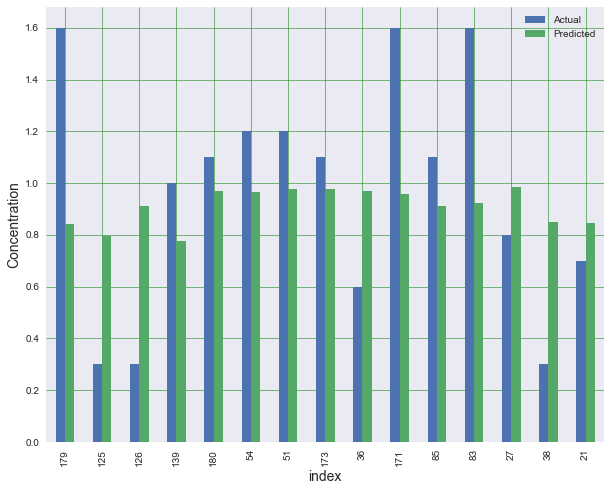


Residuals Plot


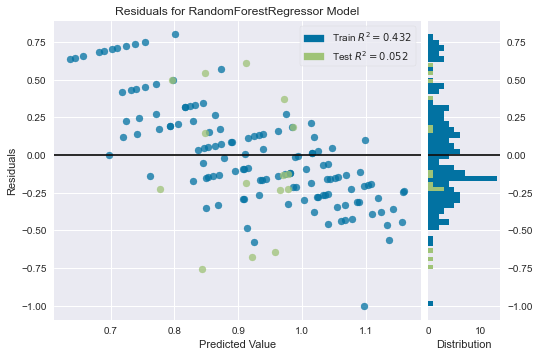

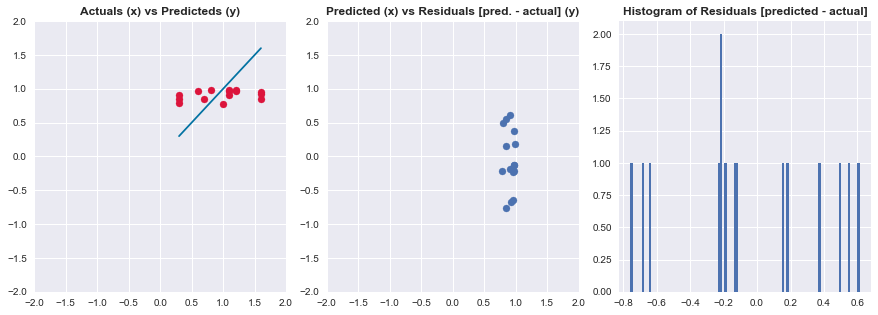

Cross-Validation Scoring
Mean Mean Absolute Error: 0.36
Median Mean Absolute Error: 0.35
Mean R^2: -0.041
Median R^2: -0.017
Max R^2: 0.06
Min R^2: -0.139


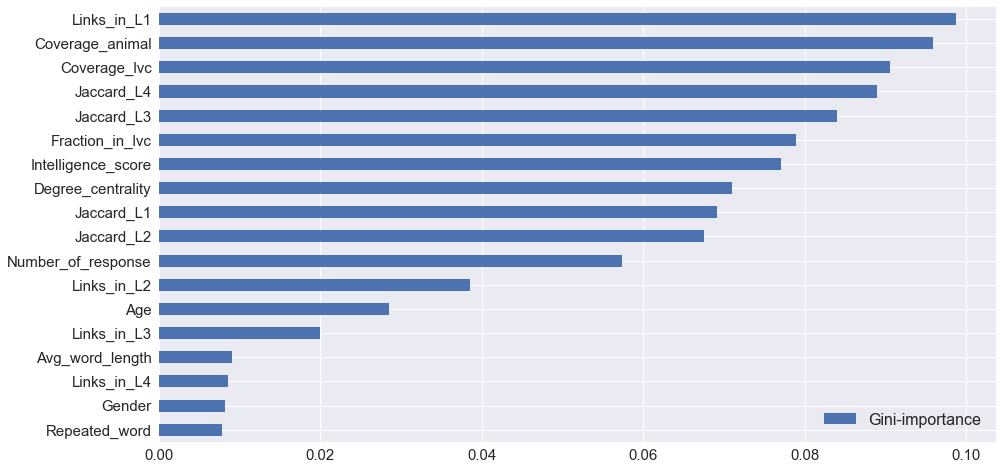

In [178]:
# Parameter tuned RF with original data
model = RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=200, random_state=random_state)
train_model(model, X=x_org_m, y=y_org_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.17
RMSE:  0.41
R-Squared:  0.13
MAE (in original units): 0.35
Accuracy (MAE): 63.58 %
Accuracy (RMSE): 57.41 %
Median Absolute Error (in original units): 0.24
Residual Skew: 0.09
Residual Kurtosis: -1.03


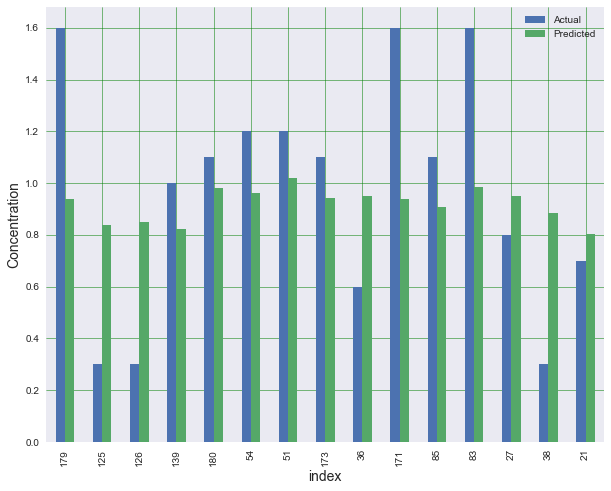


Residuals Plot


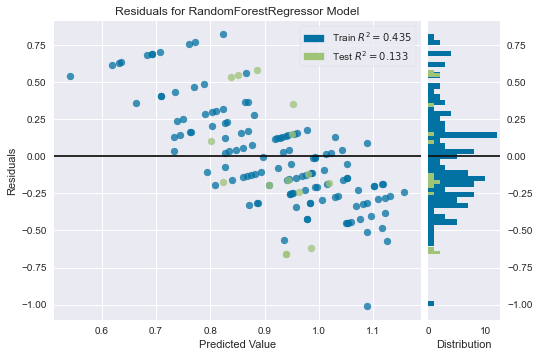

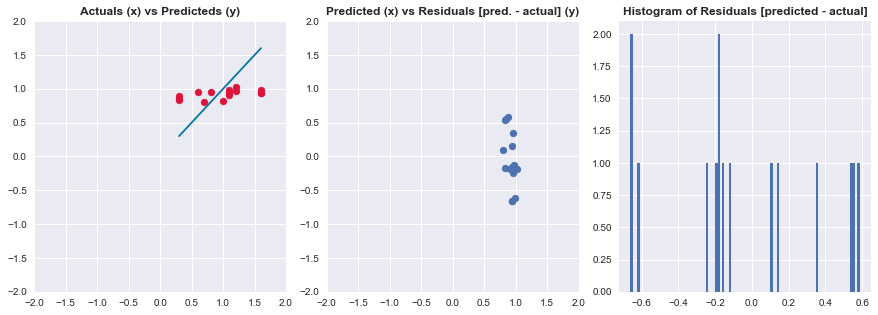

Cross-Validation Scoring
Mean Mean Absolute Error: 0.37
Median Mean Absolute Error: 0.36
Mean R^2: -0.069
Median R^2: -0.007
Max R^2: 0.028
Min R^2: -0.231


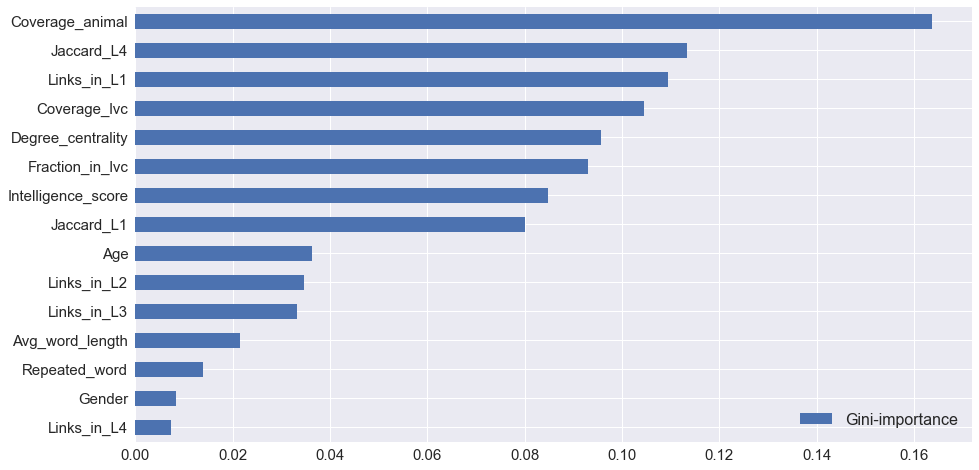

In [179]:
# Parameter tuned RF with reduced and transformed data
model = RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, random_state=random_state)
train_model(model, X=x_sqrt2_m, y=y_sqrt2_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.18
RMSE:  0.43
R-Squared:  0.06
MAE (in original units): 0.37
Accuracy (MAE): 62.07 %
Accuracy (RMSE): 55.61 %
Median Absolute Error (in original units): 0.24
Residual Skew: -0.03
Residual Kurtosis: -1.05


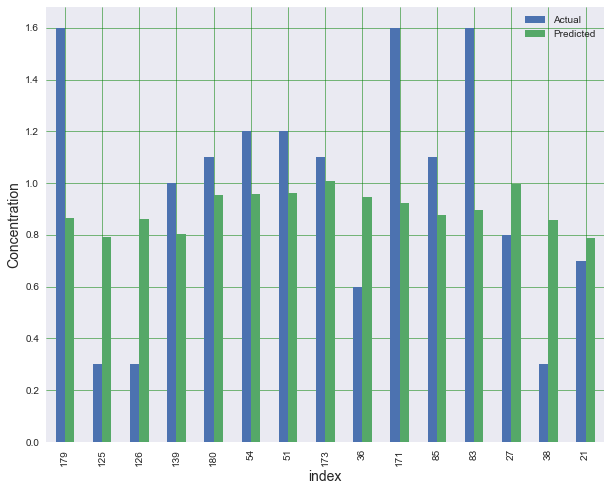


Residuals Plot


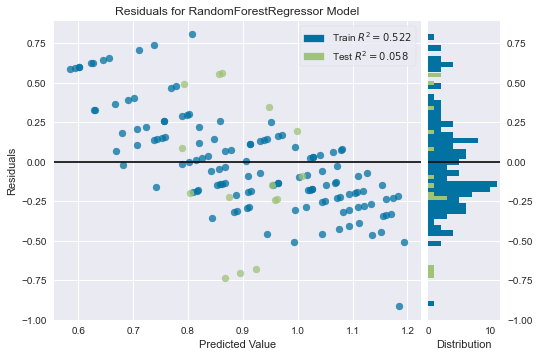

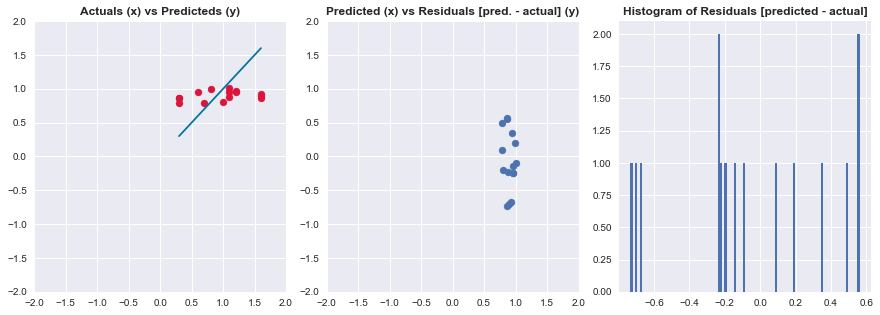

Cross-Validation Scoring
Mean Mean Absolute Error: 0.36
Median Mean Absolute Error: 0.36
Mean R^2: -0.053
Median R^2: 0.004
Max R^2: 0.049
Min R^2: -0.218


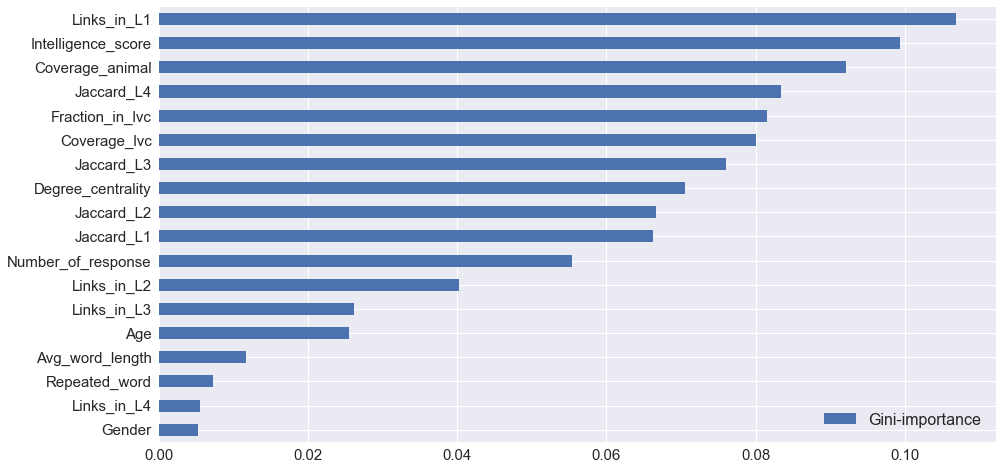

In [180]:
# Parameter tuned RF with transformed data
model = RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, random_state=random_state)
train_model(model, X=x_sqrt_m, y=y_sqrt_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.17
RMSE:  0.41
R-Squared:  0.13
MAE (in original units): 0.35
Accuracy (MAE): 63.58 %
Accuracy (RMSE): 57.41 %
Median Absolute Error (in original units): 0.24
Residual Skew: 0.09
Residual Kurtosis: -1.03


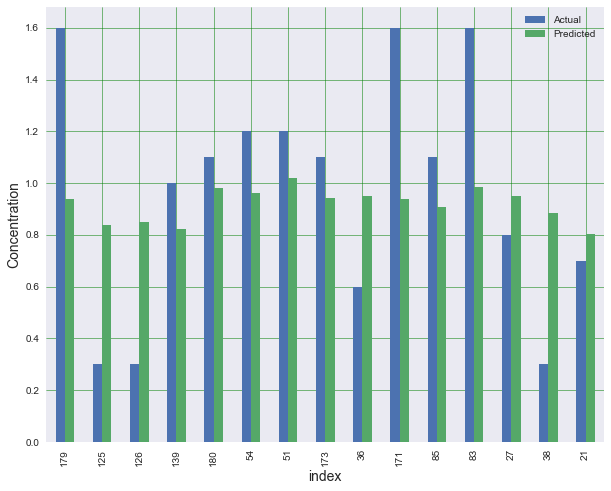


Residuals Plot


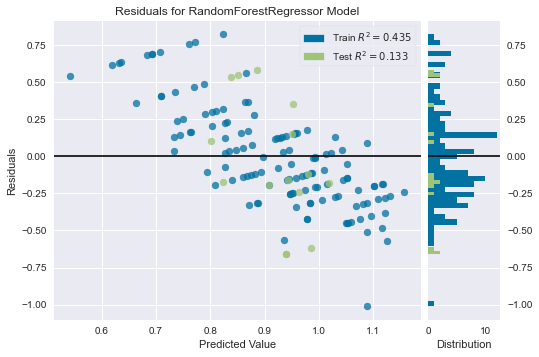

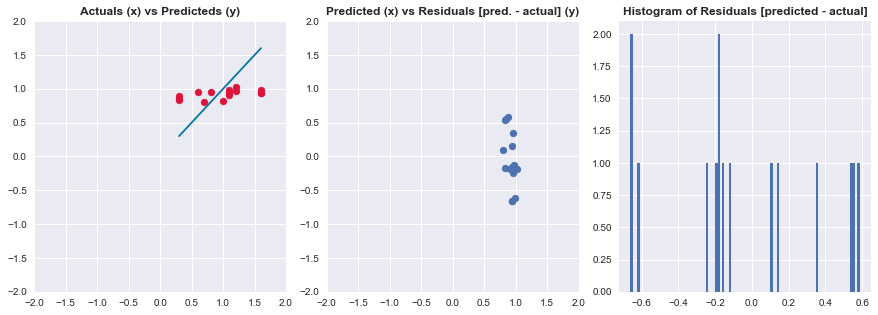

Cross-Validation Scoring
Mean Mean Absolute Error: 0.37
Median Mean Absolute Error: 0.36
Mean R^2: -0.069
Median R^2: -0.009
Max R^2: 0.028
Min R^2: -0.231


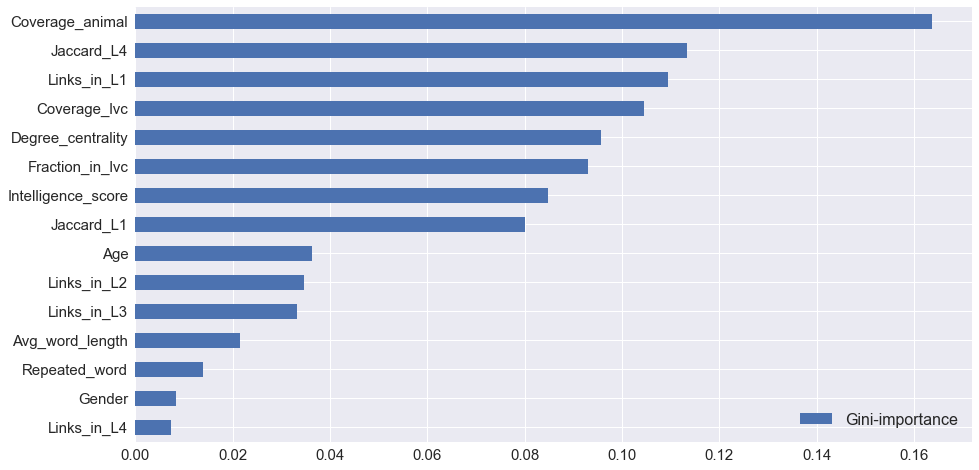

In [181]:
# Parameter tuned RF with reduced data
model = RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, random_state=random_state)
train_model(model, X=x_vif_m, y=y_vif_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.19
RMSE:  0.44
R-Squared:  0.03
MAE (in original units): 0.35
Accuracy (MAE): 63.35 %
Accuracy (RMSE): 54.87 %
Median Absolute Error (in original units): 0.23
Residual Skew: -0.13
Residual Kurtosis: -0.79


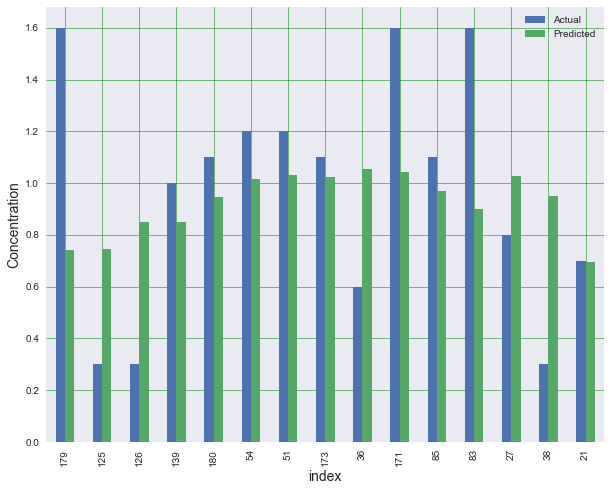


Residuals Plot


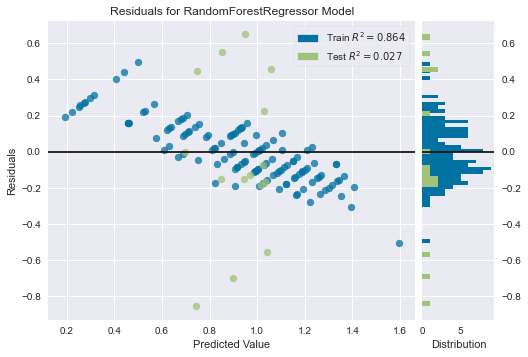

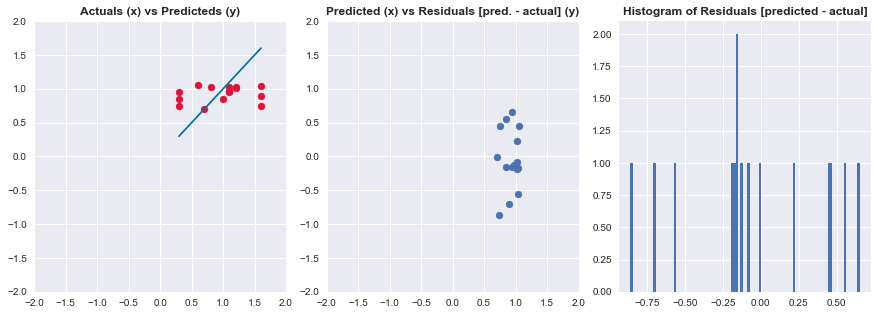

Cross-Validation Scoring
Mean Mean Absolute Error: 0.36
Median Mean Absolute Error: 0.34
Mean R^2: -0.051
Median R^2: -0.092
Max R^2: 0.185
Min R^2: -0.273


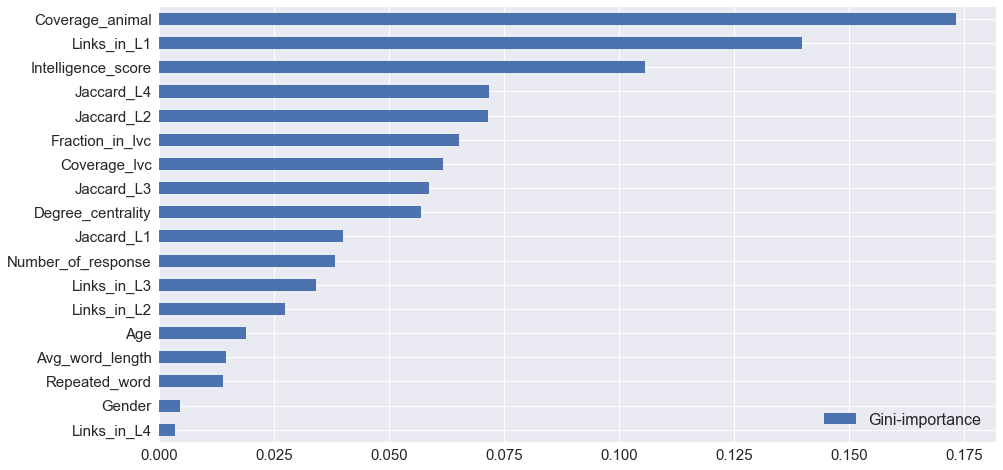

In [182]:
# RF with original data
model = RandomForestRegressor(random_state=random_state)
train_model(model, X=x_org_m, y=y_org_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.19
RMSE:  0.43
R-Squared:  0.05
MAE (in original units): 0.34
Accuracy (MAE): 64.36 %
Accuracy (RMSE): 55.32 %
Median Absolute Error (in original units): 0.2
Residual Skew: -0.13
Residual Kurtosis: -0.73


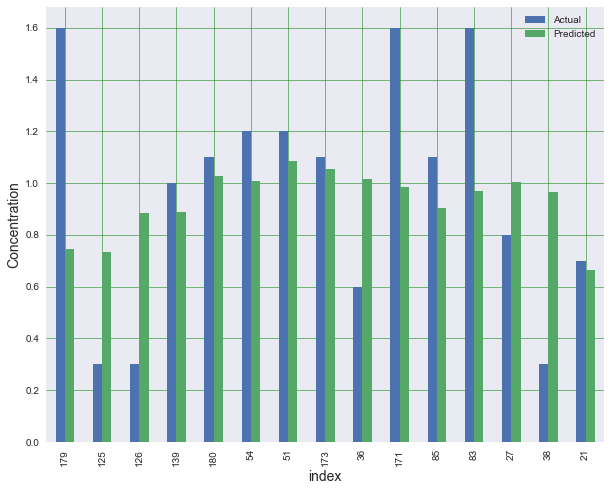


Residuals Plot


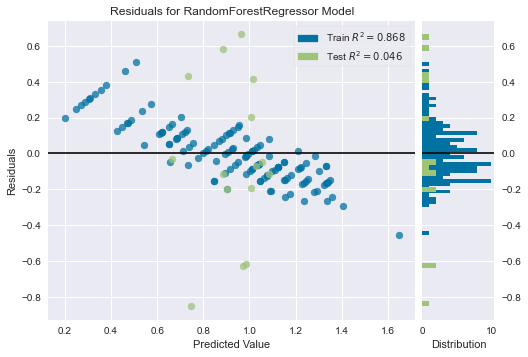

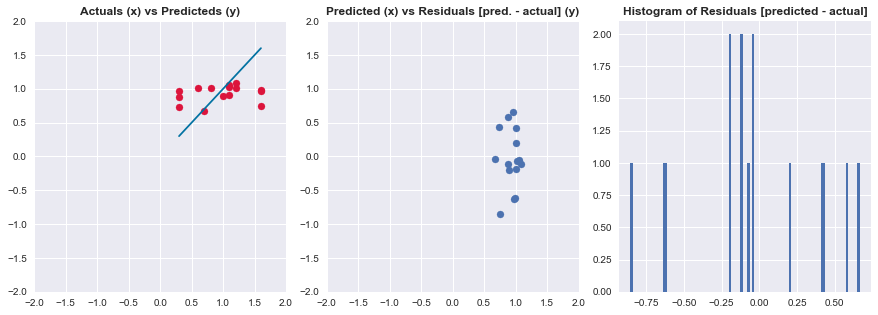

Cross-Validation Scoring
Mean Mean Absolute Error: 0.36
Median Mean Absolute Error: 0.36
Mean R^2: -0.074
Median R^2: -0.104
Max R^2: 0.115
Min R^2: -0.258


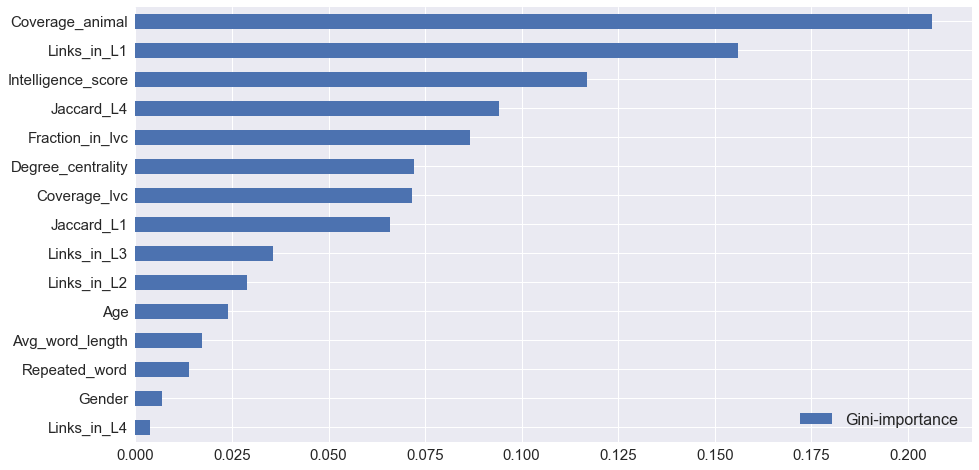

In [183]:
# RF with reduced and transformed data
model = RandomForestRegressor(random_state=random_state)
train_model(model, X=x_sqrt2_m, y=y_sqrt2_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.19
RMSE:  0.44
R-Squared:  0.03
MAE (in original units): 0.35
Accuracy (MAE): 63.39 %
Accuracy (RMSE): 54.88 %
Median Absolute Error (in original units): 0.23
Residual Skew: -0.13
Residual Kurtosis: -0.78


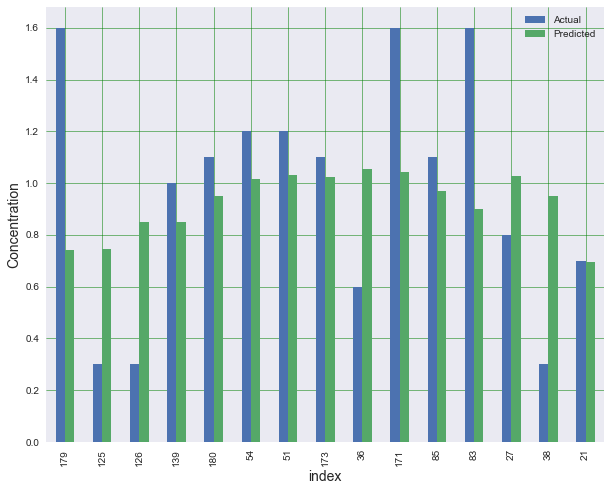


Residuals Plot


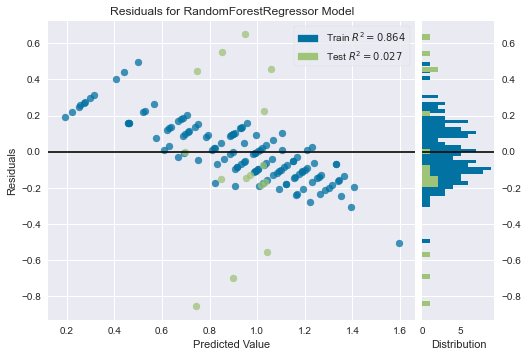

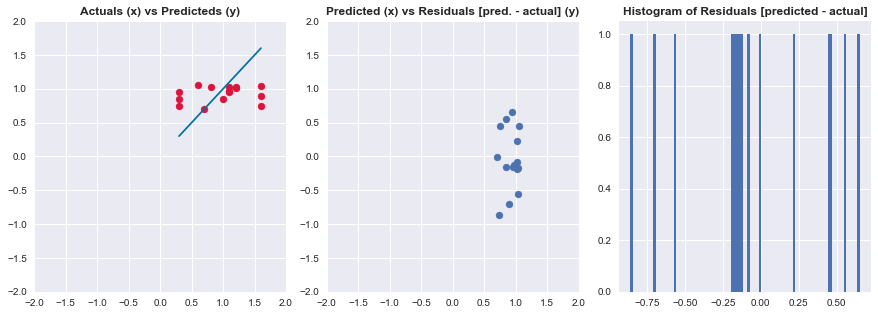

Cross-Validation Scoring
Mean Mean Absolute Error: 0.36
Median Mean Absolute Error: 0.34
Mean R^2: -0.05
Median R^2: -0.092
Max R^2: 0.185
Min R^2: -0.273


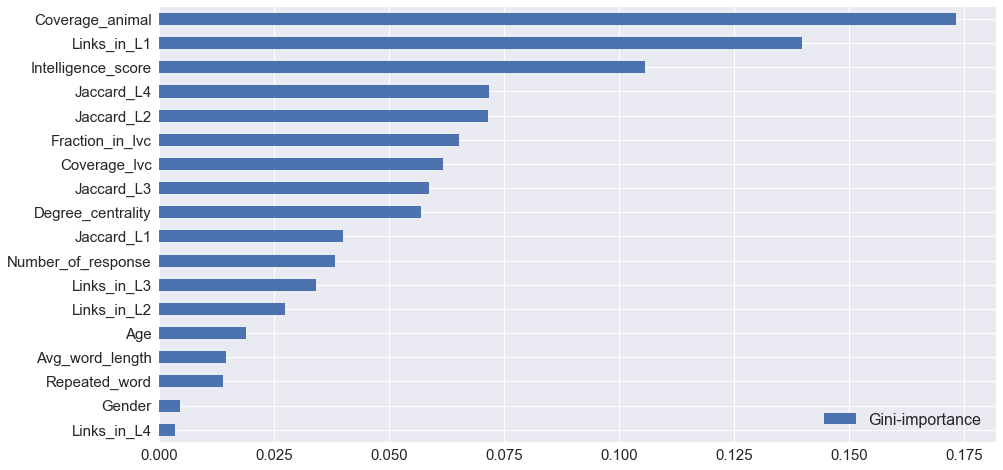

In [184]:
# RF with transformed data
model = RandomForestRegressor(random_state=random_state)
train_model(model, X=x_sqrt_m, y=y_sqrt_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.19
RMSE:  0.43
R-Squared:  0.05
MAE (in original units): 0.34
Accuracy (MAE): 64.33 %
Accuracy (RMSE): 55.31 %
Median Absolute Error (in original units): 0.2
Residual Skew: -0.13
Residual Kurtosis: -0.73


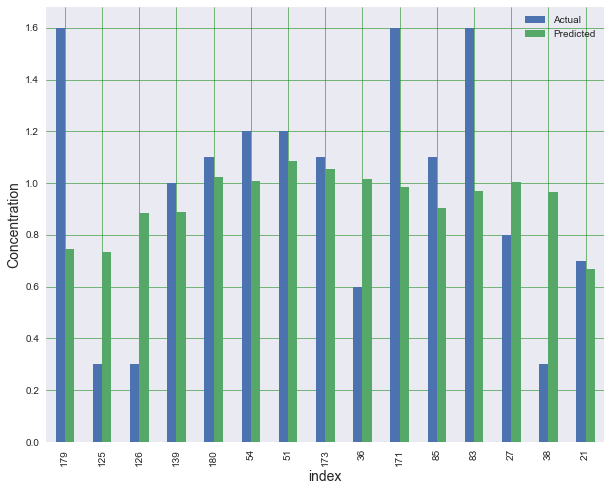


Residuals Plot


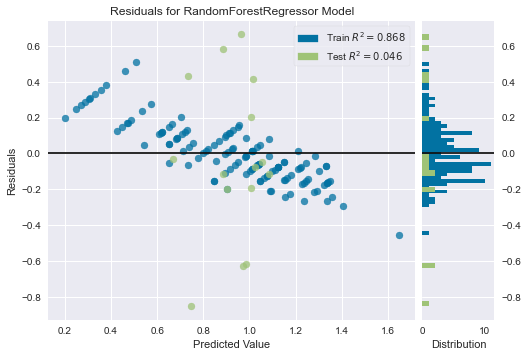

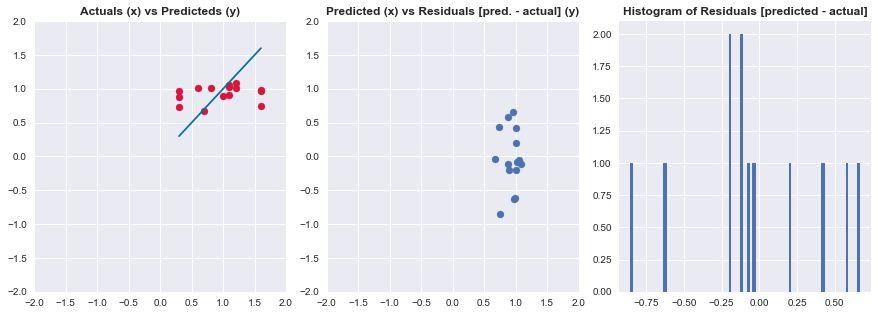

Cross-Validation Scoring
Mean Mean Absolute Error: 0.36
Median Mean Absolute Error: 0.36
Mean R^2: -0.074
Median R^2: -0.108
Max R^2: 0.115
Min R^2: -0.255


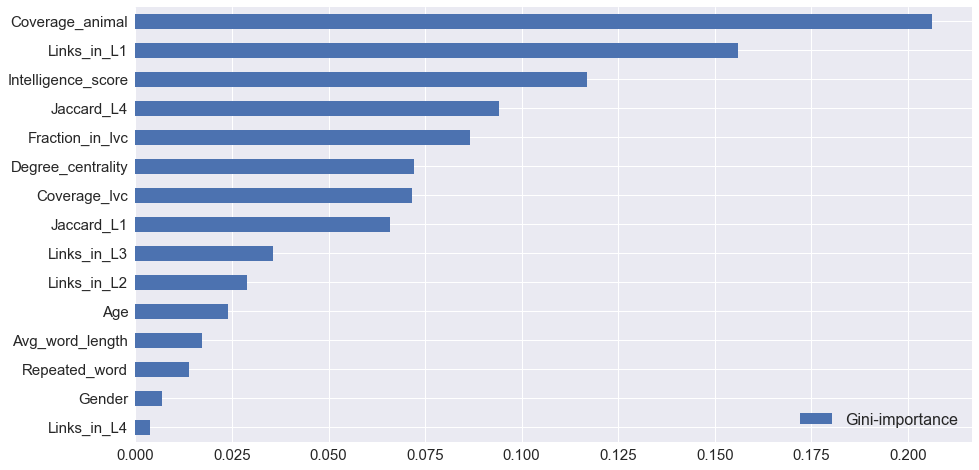

In [185]:
# RF with reduced data
model = RandomForestRegressor(random_state=random_state)
train_model(model, X=x_vif_m, y=y_vif_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.18
RMSE:  0.43
R-Squared:  0.06
MAE (in original units): 0.37
Accuracy (MAE): 61.93 %
Accuracy (RMSE): 55.54 %
Median Absolute Error (in original units): 0.27
Residual Skew: 0.21
Residual Kurtosis: -1.04


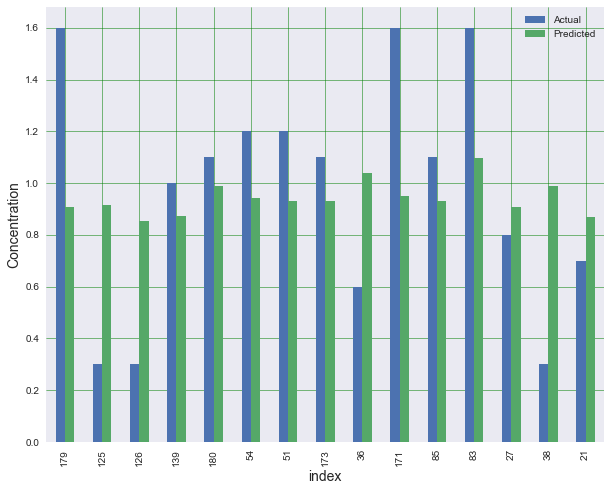


Residuals Plot


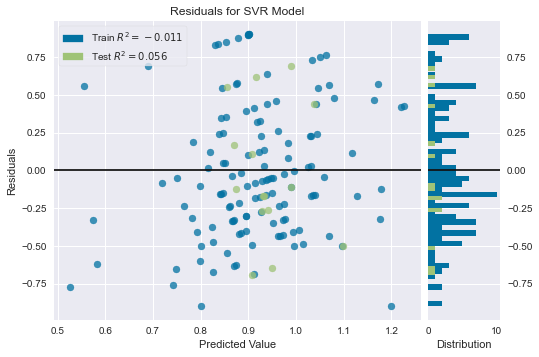

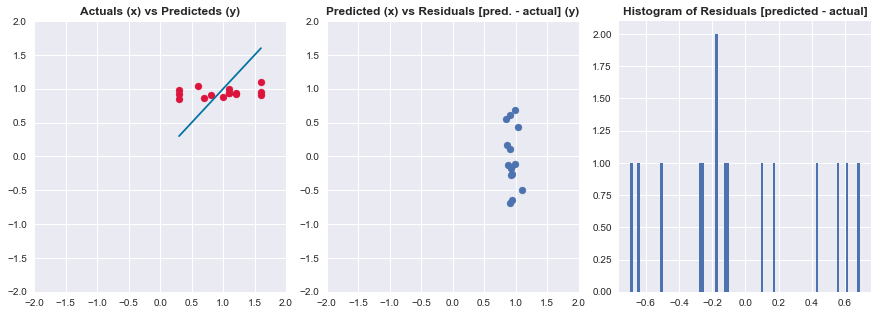

Cross-Validation Scoring
Mean Mean Absolute Error: 0.37
Median Mean Absolute Error: 0.38
Mean R^2: -0.087
Median R^2: -0.048
Max R^2: -0.04
Min R^2: -0.251


In [196]:
# Parameter tuned SVR with original data
model = SVR(C=10, epsilon=0.9)
train_model(model, X=x_org_m, y=y_org_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.19
RMSE:  0.43
R-Squared:  0.04
MAE (in original units): 0.37
Accuracy (MAE): 61.29 %
Accuracy (RMSE): 55.13 %
Median Absolute Error (in original units): 0.32
Residual Skew: 0.25
Residual Kurtosis: -1.0


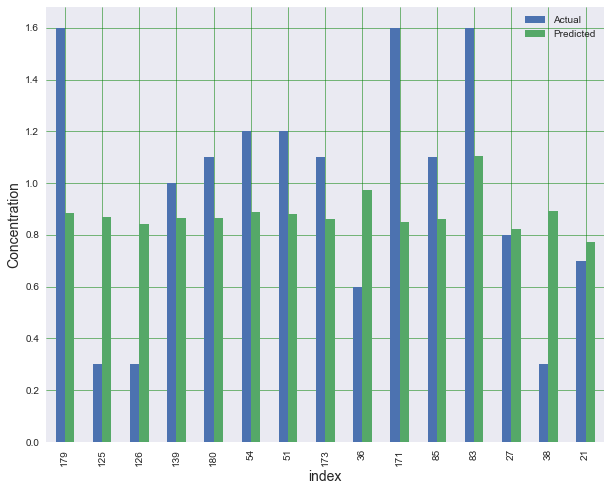


Residuals Plot


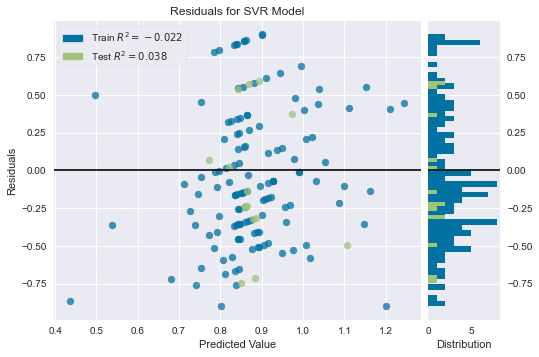

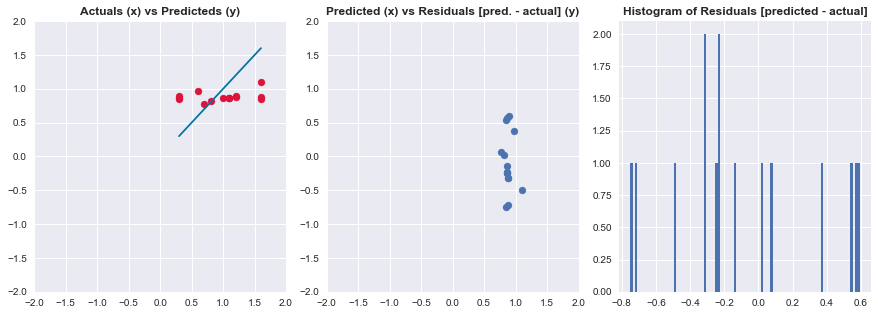

Cross-Validation Scoring
Mean Mean Absolute Error: 0.38
Median Mean Absolute Error: 0.38
Mean R^2: -0.113
Median R^2: -0.074
Max R^2: -0.048
Min R^2: -0.206


In [197]:
# Parameter tuned SVR with reduced and transformed data
model = SVR(C=10, epsilon=0.9)
train_model(model, X=x_sqrt2_m, y=y_sqrt2_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.18
RMSE:  0.43
R-Squared:  0.05
MAE (in original units): 0.37
Accuracy (MAE): 61.8 %
Accuracy (RMSE): 55.51 %
Median Absolute Error (in original units): 0.25
Residual Skew: 0.2
Residual Kurtosis: -1.04


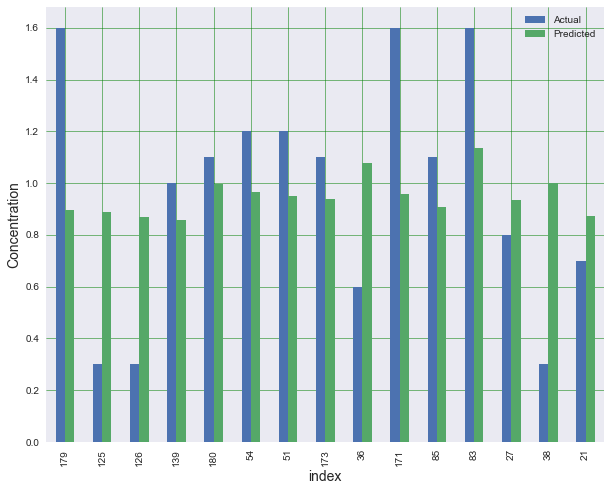


Residuals Plot


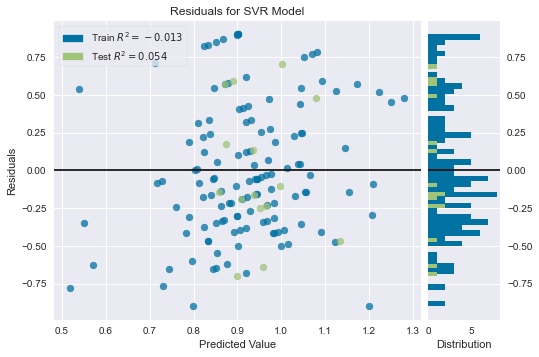

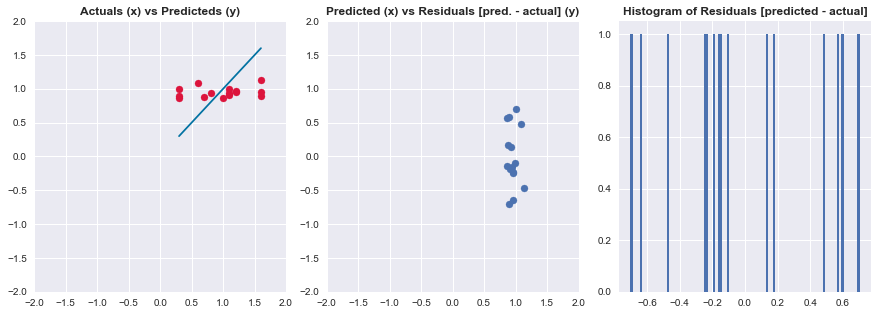

Cross-Validation Scoring
Mean Mean Absolute Error: 0.37
Median Mean Absolute Error: 0.38
Mean R^2: -0.097
Median R^2: -0.053
Max R^2: -0.04
Min R^2: -0.289


In [198]:
# Parameter tuned SVR with transformed data
model = SVR(C=10, epsilon=0.9)
train_model(model, X=x_sqrt_m, y=y_sqrt_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

MSE:  0.19
RMSE:  0.43
R-Squared:  0.04
MAE (in original units): 0.37
Accuracy (MAE): 61.52 %
Accuracy (RMSE): 55.16 %
Median Absolute Error (in original units): 0.32
Residual Skew: 0.24
Residual Kurtosis: -1.0


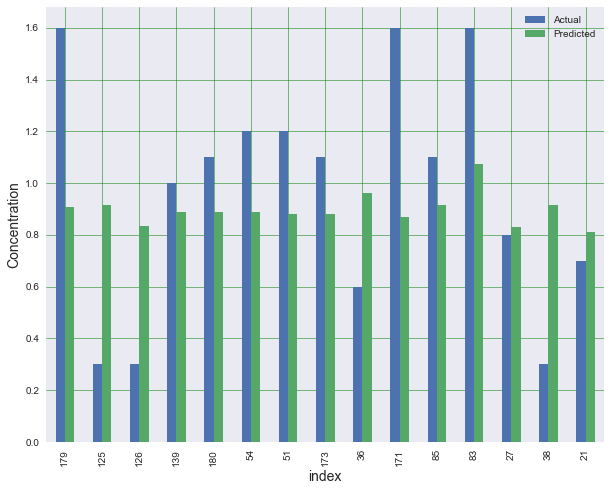


Residuals Plot


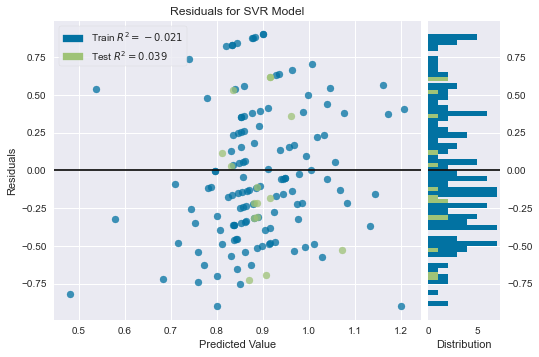

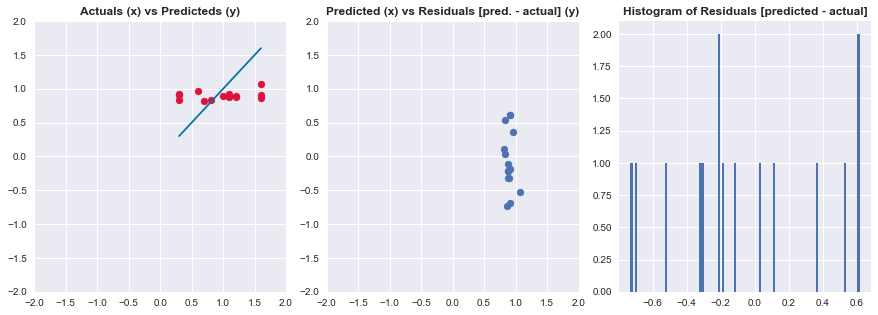

Cross-Validation Scoring
Mean Mean Absolute Error: 0.38
Median Mean Absolute Error: 0.37
Mean R^2: -0.103
Median R^2: -0.061
Max R^2: -0.048
Min R^2: -0.178


In [199]:
# Parameter tuned SVR with reduced data
model = SVR(C=10, epsilon=0.9)
train_model(model, X=x_vif_m, y=y_vif_m, cv_folds_int=5, x_left=-2, x_right=2, y_bottom=-2, y_top=2)

### Test the selected model with hold-out dataset

In [166]:
# Test data

xtest=x_sqrt2_test
ytest=y_sqrt2_test

print(xtest.shape)

(37, 15)


MSE:  0.04
RMSE:  0.2
R-Squared:  0.814
MAE (in original units): 0.17
Accuracy (MAE): 81.48 %
Accuracy (RMSE): 77.83 %


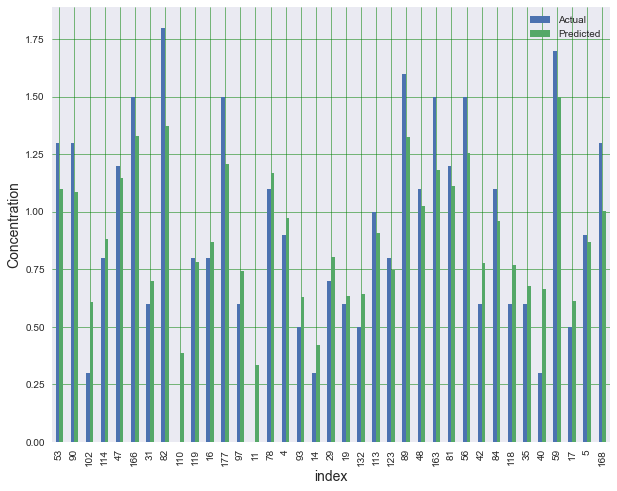

In [465]:
# Best performed model Random Forest Regressor is tested on:

final_model = RandomForestRegressor(random_state=random_state)
final_model.fit(xtest, ytest)
y_pred = final_model.predict(xtest)

MSE = mse(ytest, y_pred)
RMSE = np.sqrt(MSE)
R_squared = r2_score(ytest, y_pred)

print("MSE: ", np.round(MSE,2))
print("RMSE: ", np.round(RMSE, 2))
print("R-Squared: ", np.round(R_squared, 4))
print("MAE (in original units): "+str(round(mean_absolute_error((ytest),(y_pred)),2)))
print('Accuracy (MAE):', 100 - round(metrics.mean_absolute_error(ytest, y_pred) / ytest.mean()*100, 2), '%')
print('Accuracy (RMSE):', 100 - round(np.sqrt(metrics.mean_squared_error(ytest, y_pred)) / ytest.mean()*100, 2), '%')


dfm = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
dfm.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylabel('Concentration', fontsize = 14)
plt.xlabel('index', fontsize = 14)
#plt.title(,fontsize = 18, y = 1.03)
#plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Links_in_L3'),
  Text(0, 1, 'Links_in_L4'),
  Text(0, 2, 'Avg_word_length'),
  Text(0, 3, 'Gender'),
  Text(0, 4, 'Repeated_word'),
  Text(0, 5, 'Age'),
  Text(0, 6, 'Coverage_animal'),
  Text(0, 7, 'Fraction_in_lvc'),
  Text(0, 8, 'Jaccard_L4'),
  Text(0, 9, 'Links_in_L2'),
  Text(0, 10, 'Intelligence_score'),
  Text(0, 11, 'Degree_centrality'),
  Text(0, 12, 'Jaccard_L1'),
  Text(0, 13, 'Links_in_L1'),
  Text(0, 14, 'Coverage_lvc')])

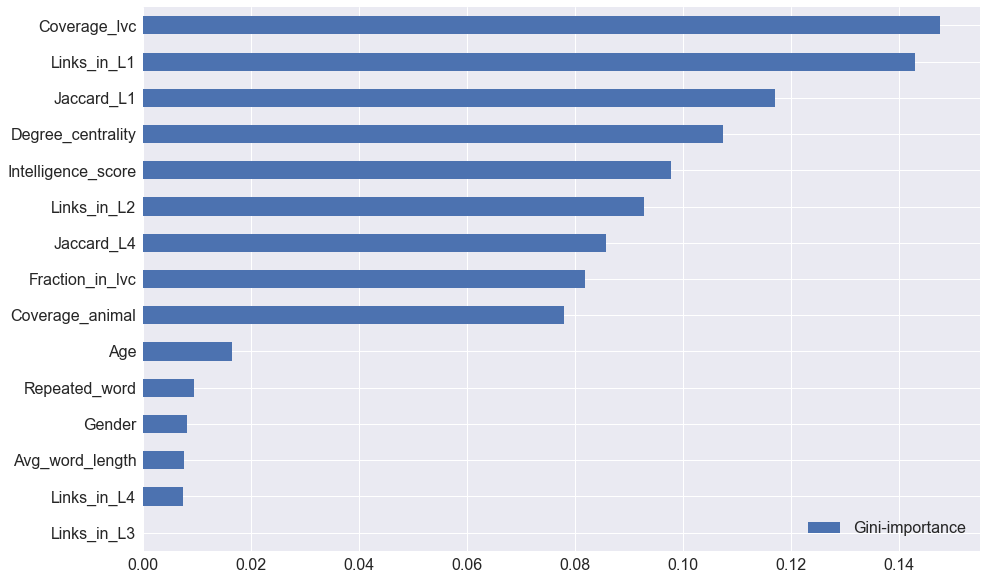

In [168]:
feats = {} # a dict to hold feature_name: feature_importance
for importance,feature in zip(final_model.feature_importances_,xtest.columns,):
        feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='barh',  figsize=(15,10),fontsize = 20)
plt.legend(loc=4,fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)